In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from currency_converter import CurrencyConverter
from matplotlib import pyplot as plt

# Clustering Analysis Tools
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# Content for the Bokeh Models
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

### Pre-processing Helper Functions

In [2]:
# Currency Converter (developed by Jingjing)
def convert_others_to_usd(symbol:str, old_value:float):
    #currency rates are found in the website: https://www.xe.com/currencyconverter/convert/?Amount=1&From=DEM&To=USD
    currencies = {
        'DEM': 0.61261302,
        'FRF': 0.182659,
        'ITL': 0.000618802,
        'BEF': 0.0297018,
        'ESP': 0.00720113,
        'ATS': 0.0870742, 
        'FIM': 0.201517,
        'CLP': 0.00142245,
        'NGN': 0.0026280674,
        'ARS': 0.010775668,
        'DOP': 0.017537532
    }

    if symbol in currencies:
        converted_value = currencies[symbol] * old_value
    else:
        converted_value = c.convert(old_value, symbol, 'USD')
    
    return converted_value

# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")
    
# Function to convert to lowercase
def lower_case(input_str):
    input_str = input_str.lower()

    return(input_str)

## Pre-processing of all Data for analysis

### First the 'Movies' dataset that contains generic information about the films

In [3]:
# First Read it in
movies_df = pd.read_csv('IMDb movies.csv')

# Rename Columns and convert data types where appropriate
movies_df = movies_df.astype(
    {
     'duration' : 'float',
     'avg_vote' : 'float',
     'votes' : 'float',
#      'budget' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'usa_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'worlwide_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
     'metascore' : 'float',
     'reviews_from_users' : 'float',
     'reviews_from_critics' : 'float'
    }).rename(columns=
    {'imdb_title_id' : 'title_id',
     'reviews_from_users' : 'user_reviews',
     'reviews_from_critics' : 'critic_reviews',
     'worlwide_gross_income' : 'ww_gross_income'
    })

# Drop the redundant 'title_id' field and set it as the index
movies_df = movies_df.set_index(movies_df['title_id']).rename(columns={'title_id' : 'REMOVE'}).drop(columns=['REMOVE'])

# Found a bad row that didn't contain an int for a year (or a year formatted as such)
movies_df = movies_df.drop(index=['tt8206668'], axis=1)
movies_df = movies_df.astype({'year' : 'int'})

# We also don't want any older films to keep the data relatively current
movies_df = movies_df[movies_df['year'] > 1969]

# Only consider films with over 10000 votes
movies_df = movies_df[movies_df['votes'] >= 1000]

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (25221, 21) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'ww_gross_income', 'metascore',
       'user_reviews', 'critic_reviews'],
      dtype='object')


title  original_title  year date_published  \
title_id                                                         
tt0035423  Kate & Leopold  Kate & Leopold  2001     2002-03-01   
tt0054724          Zombie          Zombie  1971     1971-10-29   

                              genre  duration country         language  \
title_id                                                                 
tt0035423  Comedy, Fantasy, Romance     118.0     USA  English, French   
tt0054724                    Horror      92.0     USA          English   

                director                        writer  ...  \
title_id                                                ...   
tt0035423  James Mangold  Steven Rogers, James Mangold  ...   
tt0054724     Del Tenney                    Del Tenney  ...   

                                                      actors  \
title_id                                                       
tt0035423  Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...   
tt0054724  William Joyce, Heather Hewitt, Walter Coy, Dan...   

                                                 description avg_vote  \
title_id                                                                
tt0035423  An English Duke from 1876 is inadvertedly drag...      6.4   
tt0054724  A cancer researcher on a remote Caribbean isla...      3.5   

             votes      budget usa_gross_income ww_gross_income metascore  \
title_id                                                                    
tt0035423  77852.0  $ 48000000       $ 47121859      $ 76019048      44.0   
tt0054724   1214.0         NaN              NaN             NaN       NaN   

           user_reviews  critic_reviews  
title_id                                 
tt0035423         341.0           115.0  
tt0054724          56.0            40.0  

[2 rows x 21 columns]

#### Currency Conversion; based on Jingjing's Pre-processing

In [4]:
# Currency Converter
c = CurrencyConverter()

movies_df.dropna(inplace = True)

# For each of the dollar amount attributes, we will be converting to USD
movies_df['budget_symbol'], movies_df['budget_loc_currency'] = movies_df['budget'].str.split(' ', 1).str
movies_df['budget_symbol'] = movies_df['budget_symbol'].str.replace('$','USD')
movies_df['budget_symbol'] = movies_df['budget_symbol'].str.replace('RUR','RUB')
movies_df['budget_loc_currency'] = movies_df['budget_loc_currency'].astype(float)
movies_df['budget_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['budget_symbol'], movies_df['budget_loc_currency']), axis=1)

movies_df['usa_income_symbol'], movies_df['usa_income_loc_currency'] = movies_df['usa_gross_income'].str.split(' ', 1).str
movies_df['usa_income_symbol'] = movies_df['usa_income_symbol'].str.replace('$','USD')
movies_df['usa_income_symbol'] = movies_df['usa_income_symbol'].str.replace('RUR','RUB')
movies_df['usa_income_loc_currency'] = movies_df['usa_income_loc_currency'].astype(float)
movies_df['usa_income_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['usa_income_symbol'], movies_df['usa_income_loc_currency']), axis=1)

movies_df['worldwide_income_symbol'], movies_df['worldwide_income_loc_currency'] = movies_df['ww_gross_income'].str.split(' ', 1).str
movies_df['worldwide_income_symbol'] = movies_df['worldwide_income_symbol'].str.replace('$','USD')
movies_df['worldwide_income_symbol'] = movies_df['worldwide_income_symbol'].str.replace('RUR','RUB')
movies_df['worldwide_income_loc_currency'] = movies_df['worldwide_income_loc_currency'].astype(float)
movies_df['worldwide_income_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['worldwide_income_symbol'], movies_df['worldwide_income_loc_currency']), axis=1)

# Now Remove the redundant columns since we only want the USD ones
movies_df = movies_df.drop(
    columns=['usa_gross_income', 'ww_gross_income', 'budget',
             'budget_loc_currency', 'usa_income_loc_currency',
             'worldwide_income_loc_currency', 'budget_symbol',
             'usa_income_symbol', 'worldwide_income_symbol'
            ]
)

movies_df = movies_df.rename(
    columns={'budget_usd_currency' : 'budget', 'usa_income_usd_currency' : 'usa_income', 'worldwide_income_usd_currency' : 'worldwide_income'}
)

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys
C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  del sys.path[0]
C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


Shape: (6315, 21) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'metascore', 'user_reviews', 'critic_reviews', 'budget', 'usa_income',
       'worldwide_income'],
      dtype='object')


title             original_title  year  \
title_id                                                              
tt0035423           Kate & Leopold             Kate & Leopold  2001   
tt0065134  Gli avvoltoi hanno fame  Two Mules for Sister Sara  1970   

          date_published                     genre  duration      country  \
title_id                                                                    
tt0035423     2002-03-01  Comedy, Fantasy, Romance     118.0          USA   
tt0065134     1970-12-05   Adventure, Romance, War     116.0  USA, Mexico   

                                  language       director  \
title_id                                                    
tt0035423                  English, French  James Mangold   
tt0065134  English, Spanish, French, Latin     Don Siegel   

                                  writer  ...  \
title_id                                  ...   
tt0035423   Steven Rogers, James Mangold  ...   
tt0065134  Budd Boetticher, Albert Maltz  ...   

                                                      actors  \
title_id                                                       
tt0035423  Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...   
tt0065134  Shirley MacLaine, Clint Eastwood, Manolo Fábre...   

                                                 description avg_vote  \
title_id                                                                
tt0035423  An English Duke from 1876 is inadvertedly drag...      6.4   
tt0065134  Nun Sara (Shirley MacLaine) is on the run in M...      7.0   

             votes  metascore  user_reviews  critic_reviews      budget  \
title_id                                                                  
tt0035423  77852.0       44.0         341.0           115.0  48000000.0   
tt0065134  23223.0       62.0          79.0            39.0   2500000.0   

           usa_income  worldwide_income  
title_id                                 
tt0035423  47121859.0        76019048.0  
tt0065134   5050000.0         5050000.0  

[2 rows x 21 columns]

#### Counts of Interest

In [5]:
movies_df['genre_count'] = movies_df['genre'].apply(lambda x: len(x.strip().split()))
movies_df['language_count'] = movies_df['language'].apply(lambda x: len(x.strip().split()))
movies_df['actor_count'] = movies_df['actors'].apply(lambda x: len(x.strip().split()))
movies_df['director_count'] = movies_df['director'].apply(lambda x: len(x.strip().split()))
movies_df['writer_count'] = movies_df['writer'].apply(lambda x: len(x.strip().split()))

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

Shape: (6315, 26) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'metascore', 'user_reviews', 'critic_reviews', 'budget', 'usa_income',
       'worldwide_income', 'genre_count', 'language_count', 'actor_count',
       'director_count', 'writer_count'],
      dtype='object')


title             original_title  year  \
title_id                                                              
tt0035423           Kate & Leopold             Kate & Leopold  2001   
tt0065134  Gli avvoltoi hanno fame  Two Mules for Sister Sara  1970   

          date_published                     genre  duration      country  \
title_id                                                                    
tt0035423     2002-03-01  Comedy, Fantasy, Romance     118.0          USA   
tt0065134     1970-12-05   Adventure, Romance, War     116.0  USA, Mexico   

                                  language       director  \
title_id                                                    
tt0035423                  English, French  James Mangold   
tt0065134  English, Spanish, French, Latin     Don Siegel   

                                  writer  ... user_reviews critic_reviews  \
title_id                                  ...                               
tt0035423   Steven Rogers, James Mangold  ...        341.0          115.0   
tt0065134  Budd Boetticher, Albert Maltz  ...         79.0           39.0   

               budget  usa_income  worldwide_income  genre_count  \
title_id                                                           
tt0035423  48000000.0  47121859.0        76019048.0            3   
tt0065134   2500000.0   5050000.0         5050000.0            3   

           language_count  actor_count  director_count  writer_count  
title_id                                                              
tt0035423               2           30               2             4  
tt0065134               4           32               2             4  

[2 rows x 26 columns]

### Now for the Ratings Dataset

In [6]:
ratings_df = pd.read_csv('IMDb ratings.csv')

# Update the index to the title_id
ratings_df = ratings_df.set_index(ratings_df['imdb_title_id']).rename(columns={'imdb_title_id' : 'REMOVE'}).drop(columns=['REMOVE'])

# Also drop any movies that aren't in the movies dataframe we made
preservedindex = movies_df.index
droppingindex = ratings_df.drop(index=preservedindex).index
ratings_df = ratings_df.drop(index=droppingindex)

ratings_df.index = ratings_df.index.rename('title_id')

print(ratings_df.shape)
print(ratings_df.columns)
ratings_df.head(3)

(6315, 48)
Index(['weighted_average_vote', 'total_votes', 'mean_vote', 'median_vote',
       'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
       'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_avg_vote',
       'allgenders_0age_votes', 'allgenders_18age_avg_vote',
       'allgenders_18age_votes', 'allgenders_30age_avg_vote',
       'allgenders_30age_votes', 'allgenders_45age_avg_vote',
       'allgenders_45age_votes', 'males_allages_avg_vote',
       'males_allages_votes', 'males_0age_avg_vote', 'males_0age_votes',
       'males_18age_avg_vote', 'males_18age_votes', 'males_30age_avg_vote',
       'males_30age_votes', 'males_45age_avg_vote', 'males_45age_votes',
       'females_allages_avg_vote', 'females_allages_votes',
       'females_0age_avg_vote', 'females_0age_votes', 'females_18age_avg_vote',
       'females_18age_votes', 'females_30age_avg_vote', 'females_30age_votes',
       'females_45age_avg_vote', 'females_45age_votes',
       'top1000_vote

weighted_average_vote  total_votes  mean_vote  median_vote  \
title_id                                                                
tt0035423                    6.4        77852        6.6          7.0   
tt0065134                    7.0        23223        7.1          7.0   
tt0065377                    6.6        17068        6.7          7.0   

           votes_10  votes_9  votes_8  votes_7  votes_6  votes_5  ...  \
title_id                                                          ...   
tt0035423      5169     4046    10663    21076    19837     9669  ...   
tt0065134      1465     1482     4997     9084     4204     1267  ...   
tt0065377      1151      962     2630     5216     3912     1783  ...   

           females_30age_avg_vote  females_30age_votes  \
title_id                                                 
tt0035423                     6.5              15654.0   
tt0065134                     7.2                707.0   
tt0065377                     6.5                496.0   

           females_45age_avg_vote  females_45age_votes  top1000_voters_rating  \
title_id                                                                        
tt0035423                     6.7               3753.0                    6.1   
tt0065134                     7.2                786.0                    7.0   
tt0065377                     7.0                870.0                    6.4   

           top1000_voters_votes  us_voters_rating  us_voters_votes  \
title_id                                                             
tt0035423                 468.0               6.4          14831.0   
tt0065134                 455.0               7.1           5857.0   
tt0065377                 435.0               6.7           5331.0   

           non_us_voters_rating  non_us_voters_votes  
title_id                                              
tt0035423                   6.3              38534.0  
tt0065134                   6.9              10364.0  
tt0065377                   6.5               6653.0  

[3 rows x 48 columns]

### There are a few noteworthy items we can take a look at in the scores data

In [7]:
# The average ratings between the demographics and the overall totals
ratings_avg = ratings_df.drop(
    columns=['votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
             'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_votes',
             'allgenders_18age_votes', 'allgenders_30age_votes', 'allgenders_45age_votes',
             'allgenders_18age_votes', 'males_allages_votes', 'males_0age_votes',
             'males_18age_votes', 'males_30age_votes', 'males_45age_votes',
             'females_allages_votes','females_0age_votes','females_18age_votes',
             'females_30age_votes','females_45age_votes', 'top1000_voters_votes',
             'non_us_voters_votes', 'us_voters_votes','total_votes'
            ])

print(ratings_avg.shape)
print(ratings_avg.columns)
ratings_avg.head(4)

(6315, 20)
Index(['weighted_average_vote', 'mean_vote', 'median_vote',
       'allgenders_0age_avg_vote', 'allgenders_18age_avg_vote',
       'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
       'males_allages_avg_vote', 'males_0age_avg_vote', 'males_18age_avg_vote',
       'males_30age_avg_vote', 'males_45age_avg_vote',
       'females_allages_avg_vote', 'females_0age_avg_vote',
       'females_18age_avg_vote', 'females_30age_avg_vote',
       'females_45age_avg_vote', 'top1000_voters_rating', 'us_voters_rating',
       'non_us_voters_rating'],
      dtype='object')


weighted_average_vote  mean_vote  median_vote  \
title_id                                                   
tt0035423                    6.4        6.6          7.0   
tt0065134                    7.0        7.1          7.0   
tt0065377                    6.6        6.7          7.0   
tt0065421                    7.1        7.3          7.0   

           allgenders_0age_avg_vote  allgenders_18age_avg_vote  \
title_id                                                         
tt0035423                       5.4                        6.6   
tt0065134                       7.4                        7.2   
tt0065377                       6.5                        6.5   
tt0065421                       7.3                        7.3   

           allgenders_30age_avg_vote  allgenders_45age_avg_vote  \
title_id                                                          
tt0035423                        6.3                        6.4   
tt0065134                        7.0                        7.0   
tt0065377                        6.5                        6.7   
tt0065421                        7.0                        7.1   

           males_allages_avg_vote  males_0age_avg_vote  males_18age_avg_vote  \
title_id                                                                       
tt0035423                     6.3                  5.0                   6.5   
tt0065134                     7.0                  7.3                   7.2   
tt0065377                     6.6                  NaN                   6.6   
tt0065421                     6.9                  6.8                   7.1   

           males_30age_avg_vote  males_45age_avg_vote  \
title_id                                                
tt0035423                   6.2                   6.3   
tt0065134                   7.0                   7.0   
tt0065377                   6.5                   6.7   
tt0065421                   6.9                   7.0   

           females_allages_avg_vote  females_0age_avg_vote  \
title_id                                                     
tt0035423                       6.6                    6.6   
tt0065134                       7.2                    9.0   
tt0065377                       6.8                    6.5   
tt0065421                       7.6                    8.2   

           females_18age_avg_vote  females_30age_avg_vote  \
title_id                                                    
tt0035423                     6.7                     6.5   
tt0065134                     7.3                     7.2   
tt0065377                     6.3                     6.5   
tt0065421                     7.7                     7.4   

           females_45age_avg_vote  top1000_voters_rating  us_voters_rating  \
title_id                                                                     
tt0035423                     6.7                    6.1               6.4   
tt0065134                     7.2                    7.0               7.1   
tt0065377                     7.0                    6.4               6.7   
tt0065421                     7.6                    6.8               7.0   

           non_us_voters_rating  
title_id                         
tt0035423                   6.3  
tt0065134                   6.9  
tt0065377                   6.5  
tt0065421                   7.1

In [8]:
# The demographic counts as tallies
demograph_tallies = ratings_df.drop(
    columns=['allgenders_0age_avg_vote',
             'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
             'allgenders_18age_avg_vote', 'males_allages_avg_vote', 'males_0age_avg_vote',
             'males_18age_avg_vote', 'males_30age_avg_vote', 'males_45age_avg_vote',
             'females_allages_avg_vote','females_0age_avg_vote','females_18age_avg_vote',
             'females_30age_avg_vote','females_45age_avg_vote', 'top1000_voters_rating',
             'non_us_voters_rating', 'us_voters_rating', 'weighted_average_vote', 'mean_vote',
             'median_vote'
            ])

# Since these are tallies, it's okay to fill with 0's (unlike with ratings averages where undefined is safer than a numeric value)
demograph_tallies = demograph_tallies.fillna(0.0)

print(demograph_tallies.shape)
print(demograph_tallies.columns)
demograph_tallies.head(4)

(6315, 28)
Index(['total_votes', 'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6',
       'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       'allgenders_0age_votes', 'allgenders_18age_votes',
       'allgenders_30age_votes', 'allgenders_45age_votes',
       'males_allages_votes', 'males_0age_votes', 'males_18age_votes',
       'males_30age_votes', 'males_45age_votes', 'females_allages_votes',
       'females_0age_votes', 'females_18age_votes', 'females_30age_votes',
       'females_45age_votes', 'top1000_voters_votes', 'us_voters_votes',
       'non_us_voters_votes'],
      dtype='object')


total_votes  votes_10  votes_9  votes_8  votes_7  votes_6  votes_5  \
title_id                                                                        
tt0035423        77852      5169     4046    10663    21076    19837     9669   
tt0065134        23223      1465     1482     4997     9084     4204     1267   
tt0065377        17068      1151      962     2630     5216     3912     1783   
tt0065421        91085      9770     7779    19193    29819    15543     5576   

           votes_4  votes_3  votes_2  ...  males_30age_votes  \
title_id                              ...                      
tt0035423     3933     1720      880  ...            21538.0   
tt0065134      367      157       76  ...             7315.0   
tt0065377      695      346      182  ...             4155.0   
tt0065421     1878      766      366  ...            22176.0   

           males_45age_votes  females_allages_votes  females_0age_votes  \
title_id                                                                  
tt0035423             8149.0                27328.0                 5.0   
tt0065134             7071.0                 1777.0                 2.0   
tt0065377             6355.0                 1507.0                 2.0   
tt0065421             6486.0                24951.0                27.0   

           females_18age_votes  females_30age_votes  females_45age_votes  \
title_id                                                                   
tt0035423               6811.0              15654.0               3753.0   
tt0065134                218.0                707.0                786.0   
tt0065377                 89.0                496.0                870.0   
tt0065421              10869.0              10907.0               1687.0   

           top1000_voters_votes  us_voters_votes  non_us_voters_votes  
title_id                                                               
tt0035423                 468.0          14831.0              38534.0  
tt0065134                 455.0           5857.0              10364.0  
tt0065377                 435.0           5331.0               6653.0  
tt0065421                 519.0          16831.0              39688.0  

[4 rows x 28 columns]

In [9]:
# The spread of the vote count without demographics
demograph_percents = ratings_df.drop(
    columns=['median_vote', 'allgenders_0age_avg_vote',
             'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
             'allgenders_18age_avg_vote', 'males_allages_avg_vote', 'males_0age_avg_vote',
             'males_18age_avg_vote', 'males_30age_avg_vote', 'males_45age_avg_vote',
             'females_allages_avg_vote','females_0age_avg_vote','females_18age_avg_vote',
             'females_30age_avg_vote','females_45age_avg_vote', 'top1000_voters_rating',
             'non_us_voters_rating', 'us_voters_rating', 'weighted_average_vote', 'mean_vote',
            ])

# Since these are percentages, it's okay to fill with 0's (unlike with ratings averages where undefined is safer than a numeric value)
demograph_percents = demograph_percents.fillna(0.0)

# Basically divide every column's entries by the respective total votes
demograph_percents['votes_10'] = demograph_percents['votes_10'] / demograph_percents['total_votes']
demograph_percents['votes_1'] = demograph_percents['votes_1'] / demograph_percents['total_votes']
demograph_percents['votes_2'] = demograph_percents['votes_2'] / demograph_percents['total_votes']
demograph_percents['votes_3'] = demograph_percents['votes_3'] / demograph_percents['total_votes']
demograph_percents['votes_4'] = demograph_percents['votes_4'] / demograph_percents['total_votes']
demograph_percents['votes_5'] = demograph_percents['votes_5'] / demograph_percents['total_votes']
demograph_percents['votes_6'] = demograph_percents['votes_6'] / demograph_percents['total_votes']
demograph_percents['votes_7'] = demograph_percents['votes_7'] / demograph_percents['total_votes']
demograph_percents['votes_8'] = demograph_percents['votes_8'] / demograph_percents['total_votes']
demograph_percents['votes_9'] = demograph_percents['votes_9'] / demograph_percents['total_votes']
demograph_percents['allgenders_0age_votes'] = demograph_percents['allgenders_0age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_18age_votes'] = demograph_percents['allgenders_18age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_30age_votes'] = demograph_percents['allgenders_30age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_45age_votes'] = demograph_percents['allgenders_45age_votes'] / demograph_percents['total_votes']
demograph_percents['males_allages_votes'] = demograph_percents['males_allages_votes'] / demograph_percents['total_votes']
demograph_percents['males_0age_votes'] = demograph_percents['males_0age_votes'] / demograph_percents['total_votes']
demograph_percents['males_18age_votes'] = demograph_percents['males_18age_votes'] / demograph_percents['total_votes']
demograph_percents['males_30age_votes'] = demograph_percents['males_30age_votes'] / demograph_percents['total_votes']
demograph_percents['males_45age_votes'] = demograph_percents['males_45age_votes'] / demograph_percents['total_votes']
demograph_percents['females_allages_votes'] = demograph_percents['females_allages_votes'] / demograph_percents['total_votes']
demograph_percents['females_0age_votes'] = demograph_percents['females_0age_votes'] / demograph_percents['total_votes']
demograph_percents['females_18age_votes'] = demograph_percents['females_18age_votes'] / demograph_percents['total_votes']
demograph_percents['females_30age_votes'] = demograph_percents['females_30age_votes'] / demograph_percents['total_votes']
demograph_percents['females_45age_votes'] = demograph_percents['females_45age_votes'] / demograph_percents['total_votes']
demograph_percents['top1000_voters_votes'] = demograph_percents['top1000_voters_votes'] / demograph_percents['total_votes']
demograph_percents['us_voters_votes'] = demograph_percents['us_voters_votes'] / demograph_percents['total_votes']
demograph_percents['non_us_voters_votes'] = demograph_percents['non_us_voters_votes'] / demograph_percents['total_votes']

# Rename to avoid confusion with the tallies data
demograph_percents = demograph_percents.rename(columns={
    'votes_10' : 'votes_10_percent',
    'votes_1' : 'votes_1_percent',
    'votes_2' : 'votes_2_percent',
    'votes_3' : 'votes_3_percent',
    'votes_4' : 'votes_4_percent',
    'votes_5' : 'votes_5_percent',
    'votes_6' : 'votes_6_percent',
    'votes_7' : 'votes_7_percent',
    'votes_8' : 'votes_8_percent',
    'votes_9' : 'votes_9_percent',
    'allgenders_0age_votes' : 'allgenders_0age_votes_percent',
    'allgenders_18age_votes' : 'allgenders_18age_votes_percent',
    'allgenders_30age_votes' : 'allgenders_30age_votes_percent',
    'allgenders_45age_votes' : 'allgenders_45age_votes_percent',
    'males_allages_votes' : 'males_allages_votes_percent',
    'males_0age_votes' : 'males_0age_votes_percent',
    'males_18age_votes' : 'males_18age_votes_percent',
    'males_30age_votes' : 'males_30age_votes_percent',
    'males_45age_votes' : 'males_45age_votes_percent',
    'females_allages_votes' : 'females_allages_votes_percent',
    'females_0age_votes' : 'females_0age_votes_percent',
    'females_18age_votes' : 'females_18age_votes_percent',
    'females_30age_votes' : 'females_30age_votes_percent',
    'females_45age_votes' : 'females_45age_votes_percent',
    'top1000_voters_votes' : 'top1000_voters_votes_percent',
    'us_voters_votes' : 'us_voters_votes_percent',
    'non_us_voters_votes' : 'non_us_voters_votes_percent',
})

# Don't need the total amount for this part
demograph_percents = demograph_percents.drop(columns=['total_votes'])

print(demograph_percents.shape)
print(demograph_percents.columns)
demograph_percents.head(4)

(6315, 27)
Index(['votes_10_percent', 'votes_9_percent', 'votes_8_percent',
       'votes_7_percent', 'votes_6_percent', 'votes_5_percent',
       'votes_4_percent', 'votes_3_percent', 'votes_2_percent',
       'votes_1_percent', 'allgenders_0age_votes_percent',
       'allgenders_18age_votes_percent', 'allgenders_30age_votes_percent',
       'allgenders_45age_votes_percent', 'males_allages_votes_percent',
       'males_0age_votes_percent', 'males_18age_votes_percent',
       'males_30age_votes_percent', 'males_45age_votes_percent',
       'females_allages_votes_percent', 'females_0age_votes_percent',
       'females_18age_votes_percent', 'females_30age_votes_percent',
       'females_45age_votes_percent', 'top1000_voters_votes_percent',
       'us_voters_votes_percent', 'non_us_voters_votes_percent'],
      dtype='object')


votes_10_percent  votes_9_percent  votes_8_percent  \
title_id                                                        
tt0035423          0.066395         0.051970         0.136965   
tt0065134          0.063084         0.063816         0.215175   
tt0065377          0.067436         0.056363         0.154090   
tt0065421          0.107262         0.085404         0.210715   

           votes_7_percent  votes_6_percent  votes_5_percent  votes_4_percent  \
title_id                                                                        
tt0035423         0.270719         0.254804         0.124197         0.050519   
tt0065134         0.391164         0.181027         0.054558         0.015803   
tt0065377         0.305601         0.229201         0.104464         0.040719   
tt0065421         0.327376         0.170643         0.061218         0.020618   

           votes_3_percent  votes_2_percent  votes_1_percent  ...  \
title_id                                                      ...   
tt0035423         0.022093         0.011303         0.011034  ...   
tt0065134         0.006761         0.003273         0.005340  ...   
tt0065377         0.020272         0.010663         0.011191  ...   
tt0065421         0.008410         0.004018         0.004337  ...   

           males_30age_votes_percent  males_45age_votes_percent  \
title_id                                                          
tt0035423                   0.276653                   0.104673   
tt0065134                   0.314989                   0.304483   
tt0065377                   0.243438                   0.372334   
tt0065421                   0.243465                   0.071208   

           females_allages_votes_percent  females_0age_votes_percent  \
title_id                                                               
tt0035423                       0.351025                    0.000064   
tt0065134                       0.076519                    0.000086   
tt0065377                       0.088294                    0.000117   
tt0065421                       0.273931                    0.000296   

           females_18age_votes_percent  females_30age_votes_percent  \
title_id                                                              
tt0035423                     0.087487                     0.201074   
tt0065134                     0.009387                     0.030444   
tt0065377                     0.005214                     0.029060   
tt0065421                     0.119328                     0.119745   

           females_45age_votes_percent  top1000_voters_votes_percent  \
title_id                                                               
tt0035423                     0.048207                      0.006011   
tt0065134                     0.033846                      0.019593   
tt0065377                     0.050973                      0.025486   
tt0065421                     0.018521                      0.005698   

           us_voters_votes_percent  non_us_voters_votes_percent  
title_id                                                         
tt0035423                 0.190502                     0.494965  
tt0065134                 0.252207                     0.446282  
tt0065377                 0.312339                     0.389794  
tt0065421                 0.184783                     0.435725  

[4 rows x 27 columns]

#### Create a base 'movies' dataframe without any non-numeric data

In [10]:
# Create a Copy to avid resetting the whole notebook (and have full grammar avaialble for the interactive cluster)
movies = movies_df.drop(columns=['avg_vote', 'votes', 'user_reviews', 'critic_reviews', 'date_published', 'genre', 'country', 'language', 'description', 'original_title', 'director', 'writer', 'actors', 'production_company', 'title'])
movies.head(2)

year  duration  metascore      budget  usa_income  \
title_id                                                       
tt0035423  2001     118.0       44.0  48000000.0  47121859.0   
tt0065134  1970     116.0       62.0   2500000.0   5050000.0   

           worldwide_income  genre_count  language_count  actor_count  \
title_id                                                                
tt0035423        76019048.0            3               2           30   
tt0065134         5050000.0            3               4           32   

           director_count  writer_count  
title_id                                 
tt0035423               2             4  
tt0065134               2             4

##### Now make one DataFrame per 'potentially interesting' collection of the scores

In [11]:
ratings_collection = ratings_avg.join(movies, on='title_id')
tallies_collection = demograph_tallies.join(movies, on='title_id')
demogrp_collection = demograph_percents.join(movies, on='title_id')

ratings_and_tallies = ratings_collection.join(demograph_tallies, on='title_id')
ratings_and_demogrp = ratings_collection.join(demograph_percents, on='title_id')
tallies_and_demogrp = tallies_collection.join(demograph_percents, on='title_id')

all_attributes = ratings_and_tallies.join(demograph_percents, on='title_id').dropna()

ratings_collection = ratings_collection.dropna()
tallies_collection = tallies_collection.dropna()
demogrp_collection = demogrp_collection.dropna()
ratings_and_tallies = ratings_and_tallies.dropna()
ratings_and_demogrp = ratings_and_demogrp.dropna()
tallies_and_demogrp = tallies_and_demogrp.dropna()

print(ratings_collection.shape)
print(tallies_collection.shape)
print(demogrp_collection.shape)
print(ratings_and_tallies.shape)
print(ratings_and_demogrp.shape)
print(tallies_and_demogrp.shape)
print(all_attributes.shape)
print(all_attributes.columns)

(4730, 31)
(6315, 39)
(6315, 38)
(4730, 59)
(4730, 58)
(6315, 66)
(4730, 86)
Index(['weighted_average_vote', 'mean_vote', 'median_vote',
       'allgenders_0age_avg_vote', 'allgenders_18age_avg_vote',
       'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
       'males_allages_avg_vote', 'males_0age_avg_vote', 'males_18age_avg_vote',
       'males_30age_avg_vote', 'males_45age_avg_vote',
       'females_allages_avg_vote', 'females_0age_avg_vote',
       'females_18age_avg_vote', 'females_30age_avg_vote',
       'females_45age_avg_vote', 'top1000_voters_rating', 'us_voters_rating',
       'non_us_voters_rating', 'year', 'duration', 'metascore', 'budget',
       'usa_income', 'worldwide_income', 'genre_count', 'language_count',
       'actor_count', 'director_count', 'writer_count', 'total_votes',
       'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
       'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_votes',
       'allgenders_18age_votes', 

# Now for the K-means Clustering

We don't know how useful each of the datasets could be, so let's first determine whether to use a particular dataset or not.  To do this, we will compare each of the collections we defined in the last cell using a cluster evaluation measure.  We'll use the 'movies' dataframe as the non-specialized set and perform K-means clustering on the data after embedding it with t-SNE.

The cluster evaluation measure available to use is the Silhouette score.  This is a measure of the mean intra-cluster distance to the cluster's center ('a') and the mean nearest-cluster distance (b).  It is defined as: __(b - a / max(b, a))__.  The closer the number is to 0, the more likely there is an overlap.  A negative score indicates that the clusters have more overlap than cohesion and a positive number indicates a mix of good separation and good intra-cluster cohesion.  The maximum 'best' silhouette score is 1, though this is an unlikely occurrence given the size and dimensionality of our data.

The helper functions below will be used to repeatedly create a list of scores for varying levels of K.

In [12]:
# Creates the numpy data in a format we can put inside a t-SNE model
def create_np_data(df):
    lists = []

    for ratio in df:
        feat = df[ratio]
        col_data = []
    
        for item in feat:
            col_data.append(item)
        
        lists.append(col_data)

    tot_data = []

    for i in range(df.count().min()):
        row_data = []

        for j in range(len(lists)):
            row_data.append(lists[j][i])
        
        tot_data.append(row_data)

    return(np.array(tot_data).reshape(df.count().min(), len(lists)))

# Creates a list of the silhouette scores for a given df
def create_silhouette_score_lists(df, lowend, highend):
    np_array = create_np_data(df)
    
    print(np_array.shape)
    
    # Create the scores lists
    silhouette_scores = [] # a cluster separation score: (b - a) / max(b, a)

    for k in range(lowend, highend):
        kmeans_model = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
        kmeans_model_fit = kmeans_model.fit(np_array)
        k_labels = kmeans_model_fit.labels_

        silhouette_scores.append(metrics.silhouette_score(np_array, k_labels, metric='euclidean'))

    print(f"Done! {len(silhouette_scores)}")
    
    # Finally, return it!
    return(silhouette_scores)

#### Running the K-means Clustering
Keep in mind this step takes around \__min to complete

In [13]:
%%time
# Get all the scores
movies_sil_scores = create_silhouette_score_lists(movies, 2, 20)
ratings_sil_scores = create_silhouette_score_lists(ratings_collection, 2, 20)
tallies_sil_scores = create_silhouette_score_lists(tallies_collection, 2, 20)
demogrp_sil_scores = create_silhouette_score_lists(demogrp_collection, 2, 20)
ratings_and_tallies_sil_scores = create_silhouette_score_lists(ratings_and_tallies, 2, 20)
ratings_and_demogrp_sil_scores = create_silhouette_score_lists(ratings_and_demogrp, 2, 20)
tallies_and_demogrp_sil_scores = create_silhouette_score_lists(tallies_and_demogrp, 2, 20)
all_data_sil_scores = create_silhouette_score_lists(all_attributes, 2, 20)

(6315, 11)
Initialization complete
Iteration 0, inertia 1.171761703832194e+20
Iteration 1, inertia 9.79299797760426e+19
Iteration 2, inertia 9.589429599511678e+19
Iteration 3, inertia 9.521201373881775e+19
Iteration 4, inertia 9.484672559780902e+19
Iteration 5, inertia 9.463015840540856e+19
Iteration 6, inertia 9.45037154624228e+19
Iteration 7, inertia 9.447872286815612e+19
Iteration 8, inertia 9.446472222286646e+19
Iteration 9, inertia 9.446111987427475e+19
Iteration 10, inertia 9.446003294742479e+19
Iteration 11, inertia 9.445929740594694e+19
Iteration 12, inertia 9.445790673741785e+19
Iteration 13, inertia 9.44574785062539e+19
Iteration 14, inertia 9.445687520362888e+19
Iteration 15, inertia 9.445635862725788e+19
Iteration 16, inertia 9.445596701506825e+19
Iteration 17, inertia 9.44551280605716e+19
Iteration 18, inertia 9.445413412063648e+19
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 1.2209253618659805e+20
Iteration 1, inertia 1.05971

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 4, inertia 9.633349506161633e+19
Iteration 5, inertia 9.538583433589981e+19
Iteration 6, inertia 9.49737795536664e+19
Iteration 7, inertia 9.470569335121252e+19
Iteration 8, inertia 9.452459171720354e+19
Iteration 9, inertia 9.448388032638997e+19
Iteration 10, inertia 9.446846408169189e+19
Iteration 11, inertia 9.446111987427475e+19
Iteration 12, inertia 9.44600329474248e+19
Iteration 13, inertia 9.445929740594694e+19
Iteration 14, inertia 9.445790673741785e+19
Iteration 15, inertia 9.445747850625388e+19
Iteration 16, inertia 9.44568752036289e+19
Iteration 17, inertia 9.445635862725788e+19
Iteration 18, inertia 9.445596701506825e+19
Iteration 19, inertia 9.44551280605716e+19
Iteration 20, inertia 9.445413412063647e+19
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 1.1329445148852132e+20
Iteration 1, inertia 9.565481137201983e+19
Iteration 2, inertia 9.509709873445247e+19
Iteration 3, inertia 9.477641412048108e+19
Iteration 4, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 7.972849539232763e+19
Iteration 1, inertia 5.3315774591043985e+19
Iteration 2, inertia 5.21920647238688e+19
Iteration 3, inertia 5.16442898510164e+19
Iteration 4, inertia 5.148100358634359e+19
Iteration 5, inertia 5.140349652737429e+19
Iteration 6, inertia 5.137005216983536e+19
Iteration 7, inertia 5.1360372960964755e+19
Iteration 8, inertia 5.134751631414815e+19
Iteration 9, inertia 5.134043644541432e+19
Converged at iteration 9: center shift 221791095850.8487 within tolerance 343168367951.11554.
Initialization complete
Iteration 0, inertia 7.247167020891401e+19
Iteration 1, inertia 5.827351667015683e+19
Iteration 2, inertia 5.588286547474092e+19
Iteration 3, inertia 5.444609182682025e+19
Iteration 4, inertia 5.313743796288676e+19
Iteration 5, inertia 5.233387878059001e+19
Iteration 6, inertia 5.191144262589718e+19
Iteration 7, inertia 5.161791341652077e+19
Iteration 8, inertia 5.150309201030643e+19
Iteration 9, inertia 5.143120028994285e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.369448867279389e+19
Iteration 1, inertia 3.743801047300114e+19
Iteration 2, inertia 3.700007453459864e+19
Iteration 3, inertia 3.6848213244537516e+19
Iteration 4, inertia 3.6791367195261014e+19
Iteration 5, inertia 3.677526321387096e+19
Iteration 6, inertia 3.6766364708081025e+19
Iteration 7, inertia 3.6755617605673275e+19
Iteration 8, inertia 3.6750256553007743e+19
Iteration 9, inertia 3.674751192072821e+19
Iteration 10, inertia 3.674556332936055e+19
Iteration 11, inertia 3.6743979281241674e+19
Iteration 12, inertia 3.674328419160026e+19
Iteration 13, inertia 3.674296460206246e+19
Iteration 14, inertia 3.6742782156495393e+19
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 3.870092567205016e+19
Iteration 1, inertia 3.694587914588962e+19
Iteration 2, inertia 3.6887461479274435e+19
Iteration 3, inertia 3.6863628103725773e+19
Iteration 4, inertia 3.6850236421899956e+19
Iteration 5, inertia 3.6844186

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.585510598445066e+19
Iteration 1, inertia 2.6728025155133563e+19
Iteration 2, inertia 2.61808211332789e+19
Iteration 3, inertia 2.6032122862018208e+19
Iteration 4, inertia 2.5981827814528557e+19
Iteration 5, inertia 2.5951604057693377e+19
Iteration 6, inertia 2.5912069360806265e+19
Iteration 7, inertia 2.5879929674773205e+19
Iteration 8, inertia 2.5853446762725487e+19
Iteration 9, inertia 2.5824017148431438e+19
Iteration 10, inertia 2.5754454790682046e+19
Iteration 11, inertia 2.5749065534118126e+19
Iteration 12, inertia 2.5745806340924584e+19
Iteration 13, inertia 2.574437913627434e+19
Converged at iteration 13: center shift 279341036329.01276 within tolerance 343168367951.11554.
Initialization complete
Iteration 0, inertia 3.740342856687784e+19
Iteration 1, inertia 2.9438691494737666e+19
Iteration 2, inertia 2.907415374152201e+19
Iteration 3, inertia 2.875458277603424e+19
Iteration 4, inertia 2.8422966069015925e+19
Iteration 5, inertia 2.

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.3341772481275638e+19
Iteration 1, inertia 2.2719490174548378e+19
Iteration 2, inertia 2.1437804347699024e+19
Iteration 3, inertia 2.117144985616524e+19
Iteration 4, inertia 2.0885065684603388e+19
Iteration 5, inertia 2.081877569293841e+19
Iteration 6, inertia 2.0794808835164303e+19
Iteration 7, inertia 2.077082019098269e+19
Iteration 8, inertia 2.0687586659003404e+19
Iteration 9, inertia 2.0589244226008334e+19
Iteration 10, inertia 2.0343112266333905e+19
Iteration 11, inertia 2.026361261188e+19
Iteration 12, inertia 2.025286480332313e+19
Iteration 13, inertia 2.0243641096825364e+19
Iteration 14, inertia 2.0238609366286983e+19
Iteration 15, inertia 2.018451755298862e+19
Iteration 16, inertia 2.0182748073552527e+19
Iteration 17, inertia 2.0179314911751303e+19
Iteration 18, inertia 2.0175480372237005e+19
Iteration 19, inertia 2.0174410084807606e+19
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 3.1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.4122140001292075e+19
Iteration 1, inertia 1.705885488726259e+19
Iteration 2, inertia 1.6646623749850882e+19
Iteration 3, inertia 1.654390627406248e+19
Iteration 4, inertia 1.6529238371312509e+19
Iteration 5, inertia 1.6522715425649623e+19
Iteration 6, inertia 1.6520747393952252e+19
Iteration 7, inertia 1.651992710508572e+19
Converged at iteration 7: center shift 297273508362.81146 within tolerance 343168367951.11554.
Initialization complete
Iteration 0, inertia 2.5052411063816528e+19
Iteration 1, inertia 1.8363706727652915e+19
Iteration 2, inertia 1.7989168925756377e+19
Iteration 3, inertia 1.7721517071315714e+19
Iteration 4, inertia 1.7536229229160219e+19
Iteration 5, inertia 1.738733466500561e+19
Iteration 6, inertia 1.7212813919969817e+19
Iteration 7, inertia 1.707733973332067e+19
Iteration 8, inertia 1.6992763053786006e+19
Iteration 9, inertia 1.6866630848727552e+19
Iteration 10, inertia 1.679146945249727e+19
Iteration 11, inertia 1.67

Iteration 35, inertia 1.6528882841471062e+19
Iteration 36, inertia 1.6504939685735406e+19
Iteration 37, inertia 1.646707031855216e+19
Iteration 38, inertia 1.6439840279806663e+19
Iteration 39, inertia 1.6415956244042617e+19
Iteration 40, inertia 1.6406754530893429e+19
Iteration 41, inertia 1.6394650727435469e+19
Iteration 42, inertia 1.6379367323702366e+19
Iteration 43, inertia 1.6371229207259697e+19
Iteration 44, inertia 1.636512010690264e+19
Iteration 45, inertia 1.635854127567413e+19
Iteration 46, inertia 1.6352245218989427e+19
Iteration 47, inertia 1.6348137922608087e+19
Iteration 48, inertia 1.6345758045610068e+19
Iteration 49, inertia 1.6344640538901737e+19
Iteration 50, inertia 1.6343462930673662e+19
Iteration 51, inertia 1.6342875385389265e+19
Iteration 52, inertia 1.6342341159817918e+19
Iteration 53, inertia 1.6341486630742678e+19
Converged at iteration 53: center shift 340231246832.13464 within tolerance 343168367951.11554.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7642403766915174e+19
Iteration 1, inertia 1.4318964472574493e+19
Iteration 2, inertia 1.4092654500285587e+19
Iteration 3, inertia 1.4010777085130527e+19
Iteration 4, inertia 1.397413174671968e+19
Iteration 5, inertia 1.395369512443901e+19
Iteration 6, inertia 1.3948064576593025e+19
Iteration 7, inertia 1.3945314821558522e+19
Iteration 8, inertia 1.3941059505413177e+19
Iteration 9, inertia 1.3940070020116074e+19
Iteration 10, inertia 1.3939668424588462e+19
Iteration 11, inertia 1.393910327504222e+19
Iteration 12, inertia 1.3938765359810159e+19
Iteration 13, inertia 1.3938291076666898e+19
Iteration 14, inertia 1.3937972424921362e+19
Converged at iteration 14: center shift 259810390900.36444 within tolerance 343168367951.11554.
Initialization complete
Iteration 0, inertia 1.9260776462841274e+19
Iteration 1, inertia 1.518663704404409e+19
Iteration 2, inertia 1.4482652699613315e+19
Iteration 3, inertia 1.433765744503271e+19
Iteration 4, inertia

Iteration 2, inertia 1.5295829942531434e+19
Iteration 3, inertia 1.494469583663537e+19
Iteration 4, inertia 1.4680662266536425e+19
Iteration 5, inertia 1.45342584755588e+19
Iteration 6, inertia 1.4457708957076908e+19
Iteration 7, inertia 1.4416908162344544e+19
Iteration 8, inertia 1.4377037134522325e+19
Iteration 9, inertia 1.434736104796688e+19
Iteration 10, inertia 1.4326042363520465e+19
Iteration 11, inertia 1.4300320636599226e+19
Iteration 12, inertia 1.4276781745802523e+19
Iteration 13, inertia 1.4265746121018358e+19
Iteration 14, inertia 1.4251849280801628e+19
Iteration 15, inertia 1.4145855950282252e+19
Iteration 16, inertia 1.401985683690955e+19
Iteration 17, inertia 1.3976224214315665e+19
Iteration 18, inertia 1.3960049887666897e+19
Iteration 19, inertia 1.395423545834778e+19
Iteration 20, inertia 1.395241391260308e+19
Converged at iteration 20: center shift 131468666331.62274 within tolerance 343168367951.11554.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.15312893319017e+19
Iteration 1, inertia 1.3911023769018415e+19
Iteration 2, inertia 1.3520512625416968e+19
Iteration 3, inertia 1.342709530626382e+19
Iteration 4, inertia 1.3397471667448644e+19
Iteration 5, inertia 1.3379964297637476e+19
Iteration 6, inertia 1.3366635699379497e+19
Iteration 7, inertia 1.3358765758646553e+19
Iteration 8, inertia 1.3356129388511881e+19
Iteration 9, inertia 1.3352788404975888e+19
Iteration 10, inertia 1.334897577102107e+19
Iteration 11, inertia 1.3344154667423007e+19
Iteration 12, inertia 1.3328013852641716e+19
Iteration 13, inertia 1.3315905332645542e+19
Iteration 14, inertia 1.3303553417838486e+19
Iteration 15, inertia 1.3290327851505826e+19
Iteration 16, inertia 1.3273350953906233e+19
Iteration 17, inertia 1.326261514726986e+19
Iteration 18, inertia 1.3251806194355374e+19
Iteration 19, inertia 1.3240373947600749e+19
Iteration 20, inertia 1.3228867051659497e+19
Iteration 21, inertia 1.320823437753396e+19
It

Iteration 1, inertia 1.2937719983839324e+19
Iteration 2, inertia 1.2732784048639853e+19
Iteration 3, inertia 1.26790559256105e+19
Iteration 4, inertia 1.2653134842254983e+19
Iteration 5, inertia 1.263472852381672e+19
Iteration 6, inertia 1.262310047591236e+19
Iteration 7, inertia 1.261992804840921e+19
Iteration 8, inertia 1.2618341040350106e+19
Iteration 9, inertia 1.2616600877684777e+19
Iteration 10, inertia 1.2614764115720544e+19
Iteration 11, inertia 1.2613738646429534e+19
Iteration 12, inertia 1.2613264443378342e+19
Converged at iteration 12: center shift 38532931875.03836 within tolerance 343168367951.11554.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.9031817773398884e+19
Iteration 1, inertia 1.3538121227335666e+19
Iteration 2, inertia 1.2936579463333767e+19
Iteration 3, inertia 1.2482653508466954e+19
Iteration 4, inertia 1.2178317990771364e+19
Iteration 5, inertia 1.189546588486635e+19
Iteration 6, inertia 1.174217750778413e+19
Iteration 7, inertia 1.1550028075827565e+19
Iteration 8, inertia 1.1465968019903064e+19
Iteration 9, inertia 1.141945808231486e+19
Iteration 10, inertia 1.1391089211590156e+19
Iteration 11, inertia 1.1368029036152297e+19
Iteration 12, inertia 1.134778853197518e+19
Iteration 13, inertia 1.1334631703439686e+19
Iteration 14, inertia 1.132570594686234e+19
Iteration 15, inertia 1.1319096502301057e+19
Iteration 16, inertia 1.1315028505575442e+19
Iteration 17, inertia 1.1312541785487192e+19
Iteration 18, inertia 1.1310416627381369e+19
Iteration 19, inertia 1.1309120839628964e+19
Iteration 20, inertia 1.1307897597482721e+19
Iteration 21, inertia 1.1306717486188556e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6774576582268215e+19
Iteration 1, inertia 1.187446091285064e+19
Iteration 2, inertia 1.1578410531742128e+19
Iteration 3, inertia 1.1464353021066467e+19
Iteration 4, inertia 1.1411981272957166e+19
Iteration 5, inertia 1.1384893348602884e+19
Iteration 6, inertia 1.1356258217459331e+19
Iteration 7, inertia 1.1339549481449994e+19
Iteration 8, inertia 1.1328480799026764e+19
Iteration 9, inertia 1.1322710342526362e+19
Iteration 10, inertia 1.1320006082608966e+19
Iteration 11, inertia 1.131678193231853e+19
Iteration 12, inertia 1.131218226906512e+19
Iteration 13, inertia 1.1309833734127503e+19
Iteration 14, inertia 1.1307253883754996e+19
Iteration 15, inertia 1.1304210343428241e+19
Iteration 16, inertia 1.1299535687260867e+19
Iteration 17, inertia 1.129396700521216e+19
Iteration 18, inertia 1.1290534410150144e+19
Iteration 19, inertia 1.1287176222068324e+19
Iteration 20, inertia 1.1281279783677706e+19
Iteration 21, inertia 1.1278896198789777e+19


Initialization complete
Iteration 0, inertia 1.5093859242319004e+19
Iteration 1, inertia 1.181661876353979e+19
Iteration 2, inertia 1.1413099918170413e+19
Iteration 3, inertia 1.1293314318684252e+19
Iteration 4, inertia 1.1247311958028823e+19
Iteration 5, inertia 1.1218491784537823e+19
Iteration 6, inertia 1.119432390405371e+19
Iteration 7, inertia 1.1177151767363262e+19
Iteration 8, inertia 1.1165602481762126e+19
Iteration 9, inertia 1.116188771475741e+19
Iteration 10, inertia 1.1157251952102705e+19
Iteration 11, inertia 1.115485269948769e+19
Iteration 12, inertia 1.1152936507594777e+19
Iteration 13, inertia 1.1149635270271183e+19
Iteration 14, inertia 1.1146383181142112e+19
Iteration 15, inertia 1.114445366138243e+19
Iteration 16, inertia 1.1142899775795956e+19
Iteration 17, inertia 1.1141458576979173e+19
Iteration 18, inertia 1.1140901112891597e+19
Converged at iteration 18: center shift 216859293637.7821 within tolerance 343168367951.11554.
Initialization complete
Iteration 0, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3087692445080465e+19
Iteration 1, inertia 1.0469096763649018e+19
Iteration 2, inertia 1.026928398411507e+19
Iteration 3, inertia 1.0208969319332162e+19
Iteration 4, inertia 1.01659044999042e+19
Iteration 5, inertia 1.0153484770239623e+19
Iteration 6, inertia 1.0147419171565826e+19
Iteration 7, inertia 1.0143709566257863e+19
Iteration 8, inertia 1.013856894368099e+19
Iteration 9, inertia 1.0132873570613035e+19
Iteration 10, inertia 1.0120947753370685e+19
Iteration 11, inertia 1.0112809144277533e+19
Iteration 12, inertia 1.0100795651835595e+19
Iteration 13, inertia 1.009626704589423e+19
Iteration 14, inertia 1.0094542410741012e+19
Iteration 15, inertia 1.009408407882055e+19
Iteration 16, inertia 1.0092861963312253e+19
Iteration 17, inertia 1.0091503683042288e+19
Iteration 18, inertia 1.0090713352298158e+19
Iteration 19, inertia 1.0090167562084395e+19
Iteration 20, inertia 1.0089983479737143e+19
Converged at iteration 20: center shift 2800610

Iteration 17, inertia 1.0214697461203753e+19
Iteration 18, inertia 1.0213393686019656e+19
Iteration 19, inertia 1.0213011705944422e+19
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 1.3208417237829986e+19
Iteration 1, inertia 1.0770037395437588e+19
Iteration 2, inertia 1.0497105794408854e+19
Iteration 3, inertia 1.0419407712296122e+19
Iteration 4, inertia 1.039837887627588e+19
Iteration 5, inertia 1.037766986605805e+19
Iteration 6, inertia 1.034974681060884e+19
Iteration 7, inertia 1.0336946023324353e+19
Iteration 8, inertia 1.0322210949400904e+19
Iteration 9, inertia 1.0314702447080999e+19
Iteration 10, inertia 1.0311570326122449e+19
Iteration 11, inertia 1.0309059603396956e+19
Iteration 12, inertia 1.0305575766949378e+19
Iteration 13, inertia 1.0302123719497804e+19
Iteration 14, inertia 1.0300200933851345e+19
Iteration 15, inertia 1.0299157263692546e+19
Iteration 16, inertia 1.0297936964585552e+19
Iteration 17, inertia 1.0296937882264568e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2535548381792477e+19
Iteration 1, inertia 1.074937051565103e+19
Iteration 2, inertia 1.0442441471292307e+19
Iteration 3, inertia 1.024598228934995e+19
Iteration 4, inertia 1.0054400481886214e+19
Iteration 5, inertia 9.973427210863972e+18
Iteration 6, inertia 9.933937188177785e+18
Iteration 7, inertia 9.916388212956529e+18
Iteration 8, inertia 9.903272697057444e+18
Iteration 9, inertia 9.896310796439996e+18
Iteration 10, inertia 9.891707599178924e+18
Iteration 11, inertia 9.884575800943698e+18
Iteration 12, inertia 9.874995136568625e+18
Iteration 13, inertia 9.855984713890163e+18
Iteration 14, inertia 9.845874434311324e+18
Iteration 15, inertia 9.829623922998745e+18
Iteration 16, inertia 9.817123159081665e+18
Iteration 17, inertia 9.800584013134877e+18
Iteration 18, inertia 9.793697447185252e+18
Iteration 19, inertia 9.79331548899026e+18
Iteration 20, inertia 9.792855212599185e+18
Iteration 21, inertia 9.791669378132687e+18
Iteration 22, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1959015217348393e+19
Iteration 1, inertia 9.807173876270543e+18
Iteration 2, inertia 9.486014078527754e+18
Iteration 3, inertia 9.380437354143932e+18
Iteration 4, inertia 9.347043852858612e+18
Iteration 5, inertia 9.329469196071248e+18
Iteration 6, inertia 9.308750770569312e+18
Iteration 7, inertia 9.272940759234183e+18
Iteration 8, inertia 9.240327784247142e+18
Iteration 9, inertia 9.207604722114181e+18
Iteration 10, inertia 9.181033141352e+18
Iteration 11, inertia 9.165331362490131e+18
Iteration 12, inertia 9.150524710448929e+18
Iteration 13, inertia 9.13766388441524e+18
Iteration 14, inertia 9.130707870079399e+18
Iteration 15, inertia 9.125786689745648e+18
Iteration 16, inertia 9.121393751537025e+18
Iteration 17, inertia 9.118329690227372e+18
Iteration 18, inertia 9.116738758002053e+18
Iteration 19, inertia 9.115304330446033e+18
Iteration 20, inertia 9.11399835545647e+18
Iteration 21, inertia 9.112850805374835e+18
Iteration 22, inertia 

Iteration 25, inertia 9.228319907469652e+18
Iteration 26, inertia 9.227921719852646e+18
Iteration 27, inertia 9.227482789075489e+18
Iteration 28, inertia 9.226561411218983e+18
Iteration 29, inertia 9.226121875903515e+18
Iteration 30, inertia 9.225247708684456e+18
Iteration 31, inertia 9.223220513219166e+18
Iteration 32, inertia 9.219812519562705e+18
Iteration 33, inertia 9.213275679563633e+18
Iteration 34, inertia 9.204897030309382e+18
Iteration 35, inertia 9.196219973949078e+18
Iteration 36, inertia 9.18412098699719e+18
Iteration 37, inertia 9.169494057113225e+18
Iteration 38, inertia 9.158218616929346e+18
Iteration 39, inertia 9.15436884377517e+18
Iteration 40, inertia 9.150594660511111e+18
Iteration 41, inertia 9.146635766368438e+18
Iteration 42, inertia 9.140102509547843e+18
Iteration 43, inertia 9.135185157226713e+18
Iteration 44, inertia 9.130716119680383e+18
Iteration 45, inertia 9.127476955961856e+18
Iteration 46, inertia 9.1261051309976e+18
Iteration 47, inertia 9.125040406220

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0929434526227743e+19
Iteration 1, inertia 9.08630305820043e+18
Iteration 2, inertia 8.860037889523294e+18
Iteration 3, inertia 8.74789245641859e+18
Iteration 4, inertia 8.701678757774143e+18
Iteration 5, inertia 8.665295967446062e+18
Iteration 6, inertia 8.642173048320597e+18
Iteration 7, inertia 8.628168329657217e+18
Iteration 8, inertia 8.61372786536671e+18
Iteration 9, inertia 8.602531115357184e+18
Iteration 10, inertia 8.596097638290907e+18
Iteration 11, inertia 8.591878040046916e+18
Iteration 12, inertia 8.587481352257666e+18
Iteration 13, inertia 8.585362748338884e+18
Iteration 14, inertia 8.583391019860769e+18
Iteration 15, inertia 8.582268117832307e+18
Iteration 16, inertia 8.581219472570266e+18
Iteration 17, inertia 8.579815813815828e+18
Iteration 18, inertia 8.579231531399492e+18
Iteration 19, inertia 8.578465149150425e+18
Iteration 20, inertia 8.577982591722487e+18
Iteration 21, inertia 8.577684288294688e+18
Converged at iterati

Iteration 8, inertia 8.842232562019638e+18
Iteration 9, inertia 8.836513986188365e+18
Iteration 10, inertia 8.827587795188936e+18
Iteration 11, inertia 8.822703600031889e+18
Iteration 12, inertia 8.817974431444229e+18
Iteration 13, inertia 8.815894329014232e+18
Iteration 14, inertia 8.812127004893506e+18
Iteration 15, inertia 8.803879192825829e+18
Iteration 16, inertia 8.784779523309174e+18
Iteration 17, inertia 8.764565841747333e+18
Iteration 18, inertia 8.74428505504958e+18
Iteration 19, inertia 8.733554841514637e+18
Iteration 20, inertia 8.73038119654828e+18
Iteration 21, inertia 8.721111292805602e+18
Iteration 22, inertia 8.711715680247849e+18
Iteration 23, inertia 8.701330386719977e+18
Iteration 24, inertia 8.686352349720507e+18
Iteration 25, inertia 8.673454585822641e+18
Iteration 26, inertia 8.665394914125679e+18
Iteration 27, inertia 8.65682324514081e+18
Iteration 28, inertia 8.650309640108404e+18
Iteration 29, inertia 8.645524943272061e+18
Iteration 30, inertia 8.6405333392650

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0238800824482238e+19
Iteration 1, inertia 8.454727890436973e+18
Iteration 2, inertia 8.127603367135553e+18
Iteration 3, inertia 8.011998163112564e+18
Iteration 4, inertia 7.956145190655744e+18
Iteration 5, inertia 7.929891823713481e+18
Iteration 6, inertia 7.916975321061769e+18
Iteration 7, inertia 7.908766927296422e+18
Iteration 8, inertia 7.901719012976181e+18
Iteration 9, inertia 7.898377222680121e+18
Iteration 10, inertia 7.897070165869519e+18
Iteration 11, inertia 7.895798150579262e+18
Iteration 12, inertia 7.895126184095588e+18
Iteration 13, inertia 7.894651482468833e+18
Iteration 14, inertia 7.894181343295408e+18
Iteration 15, inertia 7.893657340977757e+18
Iteration 16, inertia 7.892815172340984e+18
Iteration 17, inertia 7.892059756864052e+18
Iteration 18, inertia 7.890963373312913e+18
Iteration 19, inertia 7.890264222253538e+18
Iteration 20, inertia 7.889965173394518e+18
Iteration 21, inertia 7.889546689027386e+18
Iteration 22, ine

Iteration 5, inertia 8.175784307734146e+18
Iteration 6, inertia 8.166945210443289e+18
Iteration 7, inertia 8.157203840077814e+18
Iteration 8, inertia 8.149096311716004e+18
Iteration 9, inertia 8.144311336212105e+18
Iteration 10, inertia 8.137701449433782e+18
Iteration 11, inertia 8.131032655524689e+18
Iteration 12, inertia 8.123072389268114e+18
Iteration 13, inertia 8.116700134372825e+18
Iteration 14, inertia 8.113321699337264e+18
Iteration 15, inertia 8.110978542524682e+18
Iteration 16, inertia 8.109124761015266e+18
Iteration 17, inertia 8.108880962032906e+18
Converged at iteration 17: center shift 11890382483.508814 within tolerance 343168367951.11554.
Initialization complete
Iteration 0, inertia 1.0952934374106278e+19
Iteration 1, inertia 9.120008385484244e+18
Iteration 2, inertia 8.855482787468906e+18
Iteration 3, inertia 8.757910452166227e+18
Iteration 4, inertia 8.719779124773017e+18
Iteration 5, inertia 8.696155641388885e+18
Iteration 6, inertia 8.682435336883332e+18
Iteration 7

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.653238312004166e+18
Iteration 1, inertia 8.445709103659609e+18
Iteration 2, inertia 8.166542608885039e+18
Iteration 3, inertia 8.027582110516276e+18
Iteration 4, inertia 7.942445524109469e+18
Iteration 5, inertia 7.873303660886769e+18
Iteration 6, inertia 7.816211632721489e+18
Iteration 7, inertia 7.779615710780627e+18
Iteration 8, inertia 7.761225096699261e+18
Iteration 9, inertia 7.741979306479411e+18
Iteration 10, inertia 7.733119194517773e+18
Iteration 11, inertia 7.72676261379766e+18
Iteration 12, inertia 7.722264898510174e+18
Iteration 13, inertia 7.720642234790046e+18
Iteration 14, inertia 7.719815347582284e+18
Iteration 15, inertia 7.719305005972694e+18
Iteration 16, inertia 7.71894631061471e+18
Iteration 17, inertia 7.718663301239281e+18
Iteration 18, inertia 7.718395831875527e+18
Iteration 19, inertia 7.71803871467264e+18
Iteration 20, inertia 7.71787335043388e+18
Converged at iteration 20: center shift 171697439199.78232 within 

Iteration 8, inertia 8.089595102223136e+18
Iteration 9, inertia 8.069488610957356e+18
Iteration 10, inertia 8.058303670120274e+18
Iteration 11, inertia 8.049894228387331e+18
Iteration 12, inertia 8.046820224377142e+18
Iteration 13, inertia 8.045464106823821e+18
Iteration 14, inertia 8.042993303888041e+18
Iteration 15, inertia 8.040787633416624e+18
Iteration 16, inertia 8.036672972487862e+18
Iteration 17, inertia 8.032252821612773e+18
Iteration 18, inertia 8.025682412557528e+18
Iteration 19, inertia 8.017349720099204e+18
Iteration 20, inertia 8.007081779368351e+18
Iteration 21, inertia 7.997846708073534e+18
Iteration 22, inertia 7.986920481296207e+18
Iteration 23, inertia 7.975223084145873e+18
Iteration 24, inertia 7.967420864635075e+18
Iteration 25, inertia 7.96261307108125e+18
Iteration 26, inertia 7.95871716167762e+18
Iteration 27, inertia 7.954857703387594e+18
Iteration 28, inertia 7.952956067419961e+18
Iteration 29, inertia 7.95173264293962e+18
Iteration 30, inertia 7.9502910845127

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.035639225138391e+19
Iteration 1, inertia 7.953714796066804e+18
Iteration 2, inertia 7.71707567121038e+18
Iteration 3, inertia 7.650984905234359e+18
Iteration 4, inertia 7.602832534331237e+18
Iteration 5, inertia 7.57048608349816e+18
Iteration 6, inertia 7.554189193953865e+18
Iteration 7, inertia 7.537747118955847e+18
Iteration 8, inertia 7.527468398718693e+18
Iteration 9, inertia 7.51127337269204e+18
Iteration 10, inertia 7.502466287342557e+18
Iteration 11, inertia 7.497622654939372e+18
Iteration 12, inertia 7.494412048286894e+18
Iteration 13, inertia 7.490768528444963e+18
Iteration 14, inertia 7.488406020048759e+18
Iteration 15, inertia 7.486759501204546e+18
Iteration 16, inertia 7.485758215405204e+18
Iteration 17, inertia 7.484808820577885e+18
Iteration 18, inertia 7.483825245587568e+18
Iteration 19, inertia 7.482789359547201e+18
Iteration 20, inertia 7.482391375731336e+18
Converged at iteration 20: center shift 74098983638.7539 within t

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0516964920634202e+19
Iteration 1, inertia 7.546216388135796e+18
Iteration 2, inertia 7.340226839003575e+18
Iteration 3, inertia 7.277212244906827e+18
Iteration 4, inertia 7.237237177222896e+18
Iteration 5, inertia 7.212159133186281e+18
Iteration 6, inertia 7.186566448232345e+18
Iteration 7, inertia 7.15245819866705e+18
Iteration 8, inertia 7.118548980695644e+18
Iteration 9, inertia 7.08554358329353e+18
Iteration 10, inertia 7.064972240297363e+18
Iteration 11, inertia 7.05994583477326e+18
Iteration 12, inertia 7.055832634491273e+18
Iteration 13, inertia 7.053173570397387e+18
Iteration 14, inertia 7.052419503458786e+18
Iteration 15, inertia 7.050641710306682e+18
Iteration 16, inertia 7.047547878100924e+18
Iteration 17, inertia 7.045547288819974e+18
Iteration 18, inertia 7.044196022474273e+18
Iteration 19, inertia 7.043317872270664e+18
Iteration 20, inertia 7.042860691100393e+18
Iteration 21, inertia 7.042174301406109e+18
Iteration 22, inerti

Iteration 12, inertia 6.978148145845531e+18
Iteration 13, inertia 6.972364564851019e+18
Iteration 14, inertia 6.967682924827632e+18
Iteration 15, inertia 6.963624230813721e+18
Iteration 16, inertia 6.961507134365593e+18
Iteration 17, inertia 6.960174383177235e+18
Iteration 18, inertia 6.959354393781755e+18
Iteration 19, inertia 6.957039915146867e+18
Iteration 20, inertia 6.953776442932905e+18
Iteration 21, inertia 6.950907624516024e+18
Iteration 22, inertia 6.949015451976542e+18
Iteration 23, inertia 6.946591176266805e+18
Iteration 24, inertia 6.943933819256034e+18
Iteration 25, inertia 6.941835624034644e+18
Iteration 26, inertia 6.940535167074094e+18
Iteration 27, inertia 6.939542678440665e+18
Iteration 28, inertia 6.938935728278857e+18
Iteration 29, inertia 6.938451898332534e+18
Converged at iteration 29: center shift 263120454361.98328 within tolerance 343168367951.11554.
Initialization complete
Iteration 0, inertia 9.796786289240537e+18
Iteration 1, inertia 7.909296335460425e+18
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 7, inertia 8.749964144820114e+19
Iteration 8, inertia 8.749844414178825e+19
Iteration 9, inertia 8.749702202057836e+19
Iteration 10, inertia 8.74920691744844e+19
Iteration 11, inertia 8.748374119709223e+19
Iteration 12, inertia 8.746600896669766e+19
Iteration 13, inertia 8.745972744736408e+19
Iteration 14, inertia 8.745030327893778e+19
Iteration 15, inertia 8.744271347817962e+19
Iteration 16, inertia 8.744236072049171e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 1.5738204401763897e+20
Iteration 1, inertia 9.964491841607603e+19
Iteration 2, inertia 9.231557176792683e+19
Iteration 3, inertia 8.928778412939908e+19
Iteration 4, inertia 8.81108790060947e+19
Iteration 5, inertia 8.769809242117274e+19
Iteration 6, inertia 8.754986735116981e+19
Iteration 7, inertia 8.750993525227836e+19
Iteration 8, inertia 8.749964144820114e+19
Iteration 9, inertia 8.749844414178825e+19
Iteration 10, inertia 8.749702202057836e+19
Iteration 11, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.0968981645725884e+19
Iteration 1, inertia 4.980955706108246e+19
Iteration 2, inertia 4.869888092644888e+19
Iteration 3, inertia 4.843046962006838e+19
Iteration 4, inertia 4.8300113664073654e+19
Iteration 5, inertia 4.822017951180242e+19
Iteration 6, inertia 4.81934548894514e+19
Iteration 7, inertia 4.818179581431686e+19
Iteration 8, inertia 4.8168999126946865e+19
Iteration 9, inertia 4.815272142677694e+19
Iteration 10, inertia 4.8146526029503594e+19
Iteration 11, inertia 4.813558836271486e+19
Iteration 12, inertia 4.8130300727347585e+19
Iteration 13, inertia 4.812857891614226e+19
Iteration 14, inertia 4.812732149829793e+19
Iteration 15, inertia 4.812674429526584e+19
Iteration 16, inertia 4.812635405945674e+19
Converged at iteration 16: center shift 39713578029.64154 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 7.443867488441803e+19
Iteration 1, inertia 6.356107078773679e+19
Iteration 2, inertia 5.8867147

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.96146995062608e+19
Iteration 1, inertia 3.5362712835403473e+19
Iteration 2, inertia 3.5252143095170245e+19
Iteration 3, inertia 3.5197805651322503e+19
Iteration 4, inertia 3.517625666020105e+19
Iteration 5, inertia 3.515300270787142e+19
Iteration 6, inertia 3.5116705070671348e+19
Iteration 7, inertia 3.509105154567762e+19
Iteration 8, inertia 3.5054893257833902e+19
Iteration 9, inertia 3.500932574024102e+19
Iteration 10, inertia 3.4966237849122832e+19
Iteration 11, inertia 3.4917937116272296e+19
Iteration 12, inertia 3.487236700081684e+19
Iteration 13, inertia 3.4837500924500713e+19
Iteration 14, inertia 3.4823016909813273e+19
Iteration 15, inertia 3.481456833274776e+19
Iteration 16, inertia 3.480291237869047e+19
Iteration 17, inertia 3.4787780007056843e+19
Iteration 18, inertia 3.4763608448755536e+19
Iteration 19, inertia 3.4735530848147513e+19
Iteration 20, inertia 3.4706245790844195e+19
Iteration 21, inertia 3.4678049213671862e+19
Itera

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.9598495642203116e+19
Iteration 1, inertia 2.5068049821989024e+19
Iteration 2, inertia 2.4447737467508953e+19
Iteration 3, inertia 2.4325957902572847e+19
Iteration 4, inertia 2.4268289837868155e+19
Iteration 5, inertia 2.4214466636099875e+19
Iteration 6, inertia 2.4160049219978203e+19
Iteration 7, inertia 2.4136077987404853e+19
Iteration 8, inertia 2.4122284786915176e+19
Iteration 9, inertia 2.41172645342529e+19
Iteration 10, inertia 2.411651142811291e+19
Iteration 11, inertia 2.411638442380028e+19
Converged at iteration 11: center shift 7134365493.18636 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 3.278339800912773e+19
Iteration 1, inertia 2.5375103251423613e+19
Iteration 2, inertia 2.5166893754509107e+19
Iteration 3, inertia 2.506180665337583e+19
Iteration 4, inertia 2.4971767930540253e+19
Iteration 5, inertia 2.469595682030053e+19
Iteration 6, inertia 2.452274899745034e+19
Iteration 7, inertia 2.443705

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.4108449869554577e+19
Iteration 1, inertia 2.3257863844579426e+19
Iteration 2, inertia 2.171209770755426e+19
Iteration 3, inertia 2.0191435972558275e+19
Iteration 4, inertia 1.965118457913425e+19
Iteration 5, inertia 1.9525907825873785e+19
Iteration 6, inertia 1.9471452499625628e+19
Iteration 7, inertia 1.9448007653831254e+19
Iteration 8, inertia 1.943447649558486e+19
Iteration 9, inertia 1.942442229636085e+19
Iteration 10, inertia 1.9417891204777685e+19
Iteration 11, inertia 1.9415144248753635e+19
Iteration 12, inertia 1.941337971540921e+19
Iteration 13, inertia 1.941095020146716e+19
Iteration 14, inertia 1.9404610511992254e+19
Iteration 15, inertia 1.9400023067569455e+19
Iteration 16, inertia 1.9393291997356765e+19
Iteration 17, inertia 1.9389368608350175e+19
Iteration 18, inertia 1.93882526816463e+19
Converged at iteration 18: center shift 76321337757.27843 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 

Iteration 2, inertia 1.9781220499998876e+19
Iteration 3, inertia 1.93522520649219e+19
Iteration 4, inertia 1.911993246998093e+19
Iteration 5, inertia 1.8966659710389064e+19
Iteration 6, inertia 1.890461405577889e+19
Iteration 7, inertia 1.887139798853776e+19
Iteration 8, inertia 1.8845621998518526e+19
Iteration 9, inertia 1.8806803622336647e+19
Iteration 10, inertia 1.8785859266334224e+19
Iteration 11, inertia 1.8771668596153225e+19
Iteration 12, inertia 1.876324359332955e+19
Iteration 13, inertia 1.8761666480499503e+19
Iteration 14, inertia 1.876136129783432e+19
Iteration 15, inertia 1.8761078489833116e+19
Converged at iteration 15: center shift 121325184828.40274 within tolerance 151084220843.2059.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.170485525786126e+19
Iteration 1, inertia 1.6072794380376027e+19
Iteration 2, inertia 1.596522073031379e+19
Iteration 3, inertia 1.5902701285369045e+19
Iteration 4, inertia 1.586301029712186e+19
Iteration 5, inertia 1.5824612585720777e+19
Iteration 6, inertia 1.5785852895145157e+19
Iteration 7, inertia 1.5765231237768983e+19
Iteration 8, inertia 1.5749281954857255e+19
Iteration 9, inertia 1.5733173812864727e+19
Iteration 10, inertia 1.5715096443072242e+19
Iteration 11, inertia 1.5679483006206448e+19
Iteration 12, inertia 1.565076095577754e+19
Iteration 13, inertia 1.5626897176847129e+19
Iteration 14, inertia 1.5619299289097953e+19
Iteration 15, inertia 1.5612048809837955e+19
Iteration 16, inertia 1.5608019413057274e+19
Iteration 17, inertia 1.5604672896083513e+19
Iteration 18, inertia 1.5601854478932812e+19
Iteration 19, inertia 1.559948716834467e+19
Iteration 20, inertia 1.559696413832814e+19
Iteration 21, inertia 1.5595807387966708e+19
It

Iteration 0, inertia 2.3301819644420428e+19
Iteration 1, inertia 1.6126844370291198e+19
Iteration 2, inertia 1.5899209258462036e+19
Iteration 3, inertia 1.5764165266213601e+19
Iteration 4, inertia 1.571231205806571e+19
Iteration 5, inertia 1.566005087283392e+19
Iteration 6, inertia 1.562815499455659e+19
Iteration 7, inertia 1.561509006623669e+19
Iteration 8, inertia 1.5605239697928094e+19
Iteration 9, inertia 1.5600029058416216e+19
Iteration 10, inertia 1.5596723327965989e+19
Iteration 11, inertia 1.5593396390927133e+19
Iteration 12, inertia 1.558618544837923e+19
Iteration 13, inertia 1.5575908667483054e+19
Iteration 14, inertia 1.556785249657936e+19
Iteration 15, inertia 1.5560030548082336e+19
Iteration 16, inertia 1.5556712507775453e+19
Iteration 17, inertia 1.5555316968697623e+19
Iteration 18, inertia 1.5553044110357852e+19
Iteration 19, inertia 1.5551776665360525e+19
Iteration 20, inertia 1.555092116440306e+19
Iteration 21, inertia 1.555006317451198e+19
Iteration 22, inertia 1.5548

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7531140272073286e+19
Iteration 1, inertia 1.5452601103537758e+19
Iteration 2, inertia 1.517756742733145e+19
Iteration 3, inertia 1.5065947782213941e+19
Iteration 4, inertia 1.497147080168078e+19
Iteration 5, inertia 1.4834025372581495e+19
Iteration 6, inertia 1.469500079136056e+19
Iteration 7, inertia 1.4630301836933851e+19
Iteration 8, inertia 1.4574265153094e+19
Iteration 9, inertia 1.4534270694890174e+19
Iteration 10, inertia 1.4482572471906351e+19
Iteration 11, inertia 1.4434832466226704e+19
Iteration 12, inertia 1.4399699739677923e+19
Iteration 13, inertia 1.436865472077327e+19
Iteration 14, inertia 1.4344149900305973e+19
Iteration 15, inertia 1.431485789316065e+19
Iteration 16, inertia 1.4283409559470242e+19
Iteration 17, inertia 1.4256902951411276e+19
Iteration 18, inertia 1.4237974131682783e+19
Iteration 19, inertia 1.4226503317378488e+19
Iteration 20, inertia 1.4221772763232274e+19
Iteration 21, inertia 1.4219054689222668e+19
Iter

Iteration 39, inertia 1.3510966165394377e+19
Iteration 40, inertia 1.348687033030582e+19
Iteration 41, inertia 1.3462532681449978e+19
Iteration 42, inertia 1.3432723938477752e+19
Iteration 43, inertia 1.3394980494028716e+19
Iteration 44, inertia 1.3379503010536188e+19
Iteration 45, inertia 1.3364219780920373e+19
Iteration 46, inertia 1.3348170820945922e+19
Iteration 47, inertia 1.3241114646345562e+19
Iteration 48, inertia 1.3114398815800404e+19
Iteration 49, inertia 1.3069096544708096e+19
Iteration 50, inertia 1.3052145008073144e+19
Iteration 51, inertia 1.304488723215451e+19
Iteration 52, inertia 1.3041604378288214e+19
Iteration 53, inertia 1.3039431640782846e+19
Iteration 54, inertia 1.3037613634918736e+19
Iteration 55, inertia 1.303664000846494e+19
Iteration 56, inertia 1.3035691738946443e+19
Iteration 57, inertia 1.3035397645239718e+19
Iteration 58, inertia 1.3035142221993787e+19
Converged at iteration 58: center shift 134314608644.39905 within tolerance 151084220843.2059.
Initiali

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.185596562746179e+19
Iteration 1, inertia 1.531610746763915e+19
Iteration 2, inertia 1.3521041627512486e+19
Iteration 3, inertia 1.2989420566295347e+19
Iteration 4, inertia 1.2659433086249023e+19
Iteration 5, inertia 1.2383607807997143e+19
Iteration 6, inertia 1.2253179951118647e+19
Iteration 7, inertia 1.2150742212683995e+19
Iteration 8, inertia 1.208569702301391e+19
Iteration 9, inertia 1.2033156252937396e+19
Iteration 10, inertia 1.2003298055308095e+19
Iteration 11, inertia 1.1985685832663771e+19
Iteration 12, inertia 1.19679466582629e+19
Iteration 13, inertia 1.1952714561371957e+19
Iteration 14, inertia 1.1939871235420801e+19
Iteration 15, inertia 1.192834569119004e+19
Iteration 16, inertia 1.1918414551120177e+19
Iteration 17, inertia 1.190610458654869e+19
Iteration 18, inertia 1.1893441376001931e+19
Iteration 19, inertia 1.1883271530764974e+19
Iteration 20, inertia 1.1872818914657896e+19
Iteration 21, inertia 1.186442251707261e+19
Iter

Iteration 0, inertia 1.902501165394373e+19
Iteration 1, inertia 1.2844924459785452e+19
Iteration 2, inertia 1.2507033216527733e+19
Iteration 3, inertia 1.234541516614893e+19
Iteration 4, inertia 1.2227889232543558e+19
Iteration 5, inertia 1.2155748638657907e+19
Iteration 6, inertia 1.2070864710161721e+19
Iteration 7, inertia 1.2007495979383951e+19
Iteration 8, inertia 1.1956333151844061e+19
Iteration 9, inertia 1.1914763913656314e+19
Iteration 10, inertia 1.1895401310049987e+19
Iteration 11, inertia 1.1886211148220877e+19
Iteration 12, inertia 1.1878181991671642e+19
Iteration 13, inertia 1.1872064361489963e+19
Iteration 14, inertia 1.1869960782716674e+19
Iteration 15, inertia 1.1864147367252894e+19
Iteration 16, inertia 1.1858067582131417e+19
Iteration 17, inertia 1.1856292220342559e+19
Converged at iteration 17: strict convergence.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.362263507524544e+19
Iteration 1, inertia 1.178810653425766e+19
Iteration 2, inertia 1.1622531449225114e+19
Iteration 3, inertia 1.158040651611548e+19
Iteration 4, inertia 1.155872902381503e+19
Iteration 5, inertia 1.1541968971803845e+19
Iteration 6, inertia 1.1528033598334556e+19
Iteration 7, inertia 1.151928460649322e+19
Iteration 8, inertia 1.1512756611122674e+19
Iteration 9, inertia 1.1505580602549072e+19
Iteration 10, inertia 1.1500157758626177e+19
Iteration 11, inertia 1.1495134925516325e+19
Iteration 12, inertia 1.149048145082281e+19
Iteration 13, inertia 1.1488496001291653e+19
Iteration 14, inertia 1.1488016077284846e+19
Converged at iteration 14: center shift 128873711663.86292 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 1.5664121877255836e+19
Iteration 1, inertia 1.1242279285654868e+19
Iteration 2, inertia 1.0781238114057589e+19
Iteration 3, inertia 1.0700108855432233e+19
Iteration 4, inertia 1

Iteration 26, inertia 1.0605783168435773e+19
Iteration 27, inertia 1.060446071010113e+19
Iteration 28, inertia 1.0602653766809604e+19
Iteration 29, inertia 1.0601868403149214e+19
Iteration 30, inertia 1.0601455447991144e+19
Converged at iteration 30: center shift 24440356994.309326 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 1.5854065388055923e+19
Iteration 1, inertia 1.2087841533712206e+19
Iteration 2, inertia 1.168695394912091e+19
Iteration 3, inertia 1.1470182202656158e+19
Iteration 4, inertia 1.1328484147281824e+19
Iteration 5, inertia 1.124973319250086e+19
Iteration 6, inertia 1.1199787975397468e+19
Iteration 7, inertia 1.1160931885167596e+19
Iteration 8, inertia 1.1138135002186936e+19
Iteration 9, inertia 1.1122830616468767e+19
Iteration 10, inertia 1.110726427637335e+19
Iteration 11, inertia 1.1095544033266692e+19
Iteration 12, inertia 1.1087807103279753e+19
Iteration 13, inertia 1.1080017267070865e+19
Iteration 14, inertia 1.1074542501169318

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.316714617468979e+19
Iteration 1, inertia 1.1388672699029465e+19
Iteration 2, inertia 1.126284688525957e+19
Iteration 3, inertia 1.1168693285781598e+19
Iteration 4, inertia 1.0954103787121113e+19
Iteration 5, inertia 1.0737547892066107e+19
Iteration 6, inertia 1.0611096595758873e+19
Iteration 7, inertia 1.0548365600386263e+19
Iteration 8, inertia 1.0510359903759118e+19
Iteration 9, inertia 1.0473980539607448e+19
Iteration 10, inertia 1.0441301139765256e+19
Iteration 11, inertia 1.042281788625186e+19
Iteration 12, inertia 1.038193734879907e+19
Iteration 13, inertia 1.0348858341482865e+19
Iteration 14, inertia 1.031300080019339e+19
Iteration 15, inertia 1.0285352410644685e+19
Iteration 16, inertia 1.0269845443835042e+19
Iteration 17, inertia 1.026240307431759e+19
Iteration 18, inertia 1.025510886459286e+19
Iteration 19, inertia 1.0237365030169657e+19
Iteration 20, inertia 1.0232377496643879e+19
Iteration 21, inertia 1.022770171235403e+19
Iter

Initialization complete
Iteration 0, inertia 1.3293461231082285e+19
Iteration 1, inertia 1.0879001659643822e+19
Iteration 2, inertia 1.0524324642883688e+19
Iteration 3, inertia 1.0374382393332165e+19
Iteration 4, inertia 1.0282814361548784e+19
Iteration 5, inertia 1.0184836733249546e+19
Iteration 6, inertia 1.0130103977945532e+19
Iteration 7, inertia 1.0100082735420969e+19
Iteration 8, inertia 1.0080560925165115e+19
Iteration 9, inertia 1.0064132630254424e+19
Iteration 10, inertia 1.0046131041919255e+19
Iteration 11, inertia 1.0029205480309223e+19
Iteration 12, inertia 1.0012102615452516e+19
Iteration 13, inertia 9.998442778651374e+18
Iteration 14, inertia 9.989232990329952e+18
Iteration 15, inertia 9.981061861868814e+18
Iteration 16, inertia 9.97493197613975e+18
Iteration 17, inertia 9.970441643142787e+18
Iteration 18, inertia 9.966373460856713e+18
Iteration 19, inertia 9.963482636608213e+18
Iteration 20, inertia 9.961612093928366e+18
Iteration 21, inertia 9.959257356977005e+18
Iterat

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3480266783988111e+19
Iteration 1, inertia 9.793154970770545e+18
Iteration 2, inertia 9.430905068331543e+18
Iteration 3, inertia 9.394386358860476e+18
Iteration 4, inertia 9.380267990428717e+18
Iteration 5, inertia 9.37621983747324e+18
Iteration 6, inertia 9.372532509752609e+18
Iteration 7, inertia 9.368930384483076e+18
Iteration 8, inertia 9.367377427824724e+18
Iteration 9, inertia 9.366996556663783e+18
Iteration 10, inertia 9.366853049176496e+18
Iteration 11, inertia 9.366724835720081e+18
Iteration 12, inertia 9.366530804261962e+18
Iteration 13, inertia 9.366382367640048e+18
Converged at iteration 13: center shift 138135708631.12146 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 1.2477393779881478e+19
Iteration 1, inertia 9.731635055447605e+18
Iteration 2, inertia 9.51870065087505e+18
Iteration 3, inertia 9.413277366322373e+18
Iteration 4, inertia 9.357695889012732e+18
Iteration 5, inertia 9.3172660617938

Iteration 22, inertia 9.49145205242337e+18
Iteration 23, inertia 9.489552467871242e+18
Iteration 24, inertia 9.487785426458817e+18
Iteration 25, inertia 9.486934556708805e+18
Iteration 26, inertia 9.486330910946206e+18
Iteration 27, inertia 9.486091653073314e+18
Converged at iteration 27: center shift 114437202108.80016 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 1.19180719470056e+19
Iteration 1, inertia 9.962589827756026e+18
Iteration 2, inertia 9.727038928645163e+18
Iteration 3, inertia 9.659656222867077e+18
Iteration 4, inertia 9.643233692635744e+18
Iteration 5, inertia 9.63792817152258e+18
Iteration 6, inertia 9.63583326133908e+18
Iteration 7, inertia 9.634987158090344e+18
Converged at iteration 7: center shift 117165679655.44194 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 1.3299325326304311e+19
Iteration 1, inertia 1.0011161567877104e+19
Iteration 2, inertia 9.765614024836241e+18
Iteration 3, inertia 9.69726

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2528179717187301e+19
Iteration 1, inertia 9.572949532683158e+18
Iteration 2, inertia 9.100637211601874e+18
Iteration 3, inertia 8.922995770052726e+18
Iteration 4, inertia 8.871538522402885e+18
Iteration 5, inertia 8.853021483458634e+18
Iteration 6, inertia 8.843078293190698e+18
Iteration 7, inertia 8.834864826763879e+18
Iteration 8, inertia 8.82873376470188e+18
Iteration 9, inertia 8.821786889953732e+18
Iteration 10, inertia 8.815316021923458e+18
Iteration 11, inertia 8.80767812742617e+18
Iteration 12, inertia 8.801411626183388e+18
Iteration 13, inertia 8.797173025146377e+18
Iteration 14, inertia 8.794082202019162e+18
Iteration 15, inertia 8.793008433130128e+18
Iteration 16, inertia 8.792289120647465e+18
Iteration 17, inertia 8.791900219621004e+18
Iteration 18, inertia 8.79141960935772e+18
Converged at iteration 18: center shift 91496067316.7141 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 1.333988277651

Iteration 0, inertia 1.3307886284333185e+19
Iteration 1, inertia 1.0506056217457746e+19
Iteration 2, inertia 1.014266747075025e+19
Iteration 3, inertia 9.970594524307894e+18
Iteration 4, inertia 9.85110894447259e+18
Iteration 5, inertia 9.715170030929816e+18
Iteration 6, inertia 9.573563264037485e+18
Iteration 7, inertia 9.447956002811357e+18
Iteration 8, inertia 9.33328153064255e+18
Iteration 9, inertia 9.223453498757157e+18
Iteration 10, inertia 9.145872677370827e+18
Iteration 11, inertia 9.07011394456113e+18
Iteration 12, inertia 9.011782176066297e+18
Iteration 13, inertia 8.98510297550492e+18
Iteration 14, inertia 8.955463286754989e+18
Iteration 15, inertia 8.944978787414953e+18
Iteration 16, inertia 8.933486159231054e+18
Iteration 17, inertia 8.919666991696484e+18
Iteration 18, inertia 8.903521584106522e+18
Iteration 19, inertia 8.886566092503919e+18
Iteration 20, inertia 8.874771004257742e+18
Iteration 21, inertia 8.865765519241546e+18
Iteration 22, inertia 8.858898807654981e+18


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0989108456658401e+19
Iteration 1, inertia 9.590709710068666e+18
Iteration 2, inertia 9.257493997410249e+18
Iteration 3, inertia 9.05188823006583e+18
Iteration 4, inertia 8.901230458458406e+18
Iteration 5, inertia 8.737489885055824e+18
Iteration 6, inertia 8.679927326171295e+18
Iteration 7, inertia 8.669975791492087e+18
Iteration 8, inertia 8.6581016815604e+18
Iteration 9, inertia 8.647754102636965e+18
Iteration 10, inertia 8.642888628370503e+18
Iteration 11, inertia 8.640092114534618e+18
Iteration 12, inertia 8.637255446480821e+18
Iteration 13, inertia 8.635151782806911e+18
Iteration 14, inertia 8.634206132241788e+18
Iteration 15, inertia 8.633163789951242e+18
Iteration 16, inertia 8.631980496312849e+18
Iteration 17, inertia 8.63100945484263e+18
Iteration 18, inertia 8.63037735149408e+18
Iteration 19, inertia 8.630100365977255e+18
Converged at iteration 19: center shift 45877410106.40317 within tolerance 151084220843.2059.
Initialization c

Iteration 11, inertia 8.291712552074507e+18
Iteration 12, inertia 8.290336506965894e+18
Iteration 13, inertia 8.289555622459042e+18
Iteration 14, inertia 8.289049333159331e+18
Iteration 15, inertia 8.288884247237032e+18
Iteration 16, inertia 8.288646166034776e+18
Iteration 17, inertia 8.28851771980841e+18
Converged at iteration 17: center shift 34775428446.537025 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 1.1753628349563623e+19
Iteration 1, inertia 9.011570721522431e+18
Iteration 2, inertia 8.741070367482835e+18
Iteration 3, inertia 8.650548410769851e+18
Iteration 4, inertia 8.537428288960714e+18
Iteration 5, inertia 8.440854958607282e+18
Iteration 6, inertia 8.404571778855876e+18
Iteration 7, inertia 8.39842543575116e+18
Iteration 8, inertia 8.396326219592308e+18
Iteration 9, inertia 8.395052373900202e+18
Iteration 10, inertia 8.393818451254616e+18
Iteration 11, inertia 8.393323685503412e+18
Iteration 12, inertia 8.392878231524207e+18
Iteration 13

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.821181099130354e+18
Iteration 1, inertia 8.596517107100078e+18
Iteration 2, inertia 8.470921393440073e+18
Iteration 3, inertia 8.419503238694651e+18
Iteration 4, inertia 8.384080018939774e+18
Iteration 5, inertia 8.362464171829982e+18
Iteration 6, inertia 8.342478127537337e+18
Iteration 7, inertia 8.32596153104582e+18
Iteration 8, inertia 8.308816256268631e+18
Iteration 9, inertia 8.290176325804927e+18
Iteration 10, inertia 8.267345841177311e+18
Iteration 11, inertia 8.237685732241184e+18
Iteration 12, inertia 8.217135737919492e+18
Iteration 13, inertia 8.200938475161038e+18
Iteration 14, inertia 8.184662520131105e+18
Iteration 15, inertia 8.167694852091309e+18
Iteration 16, inertia 8.152815958861067e+18
Iteration 17, inertia 8.144896519707496e+18
Iteration 18, inertia 8.140441824204919e+18
Iteration 19, inertia 8.135996534181943e+18
Iteration 20, inertia 8.131121174989287e+18
Iteration 21, inertia 8.1255935807606e+18
Iteration 22, inertia

Iteration 19, inertia 8.469972117686602e+18
Iteration 20, inertia 8.469433687633147e+18
Iteration 21, inertia 8.469113464953041e+18
Iteration 22, inertia 8.46893593860582e+18
Iteration 23, inertia 8.468837961072664e+18
Iteration 24, inertia 8.468767019313273e+18
Converged at iteration 24: strict convergence.
Initialization complete
Iteration 0, inertia 1.1083677359424262e+19
Iteration 1, inertia 8.556965499966898e+18
Iteration 2, inertia 8.292322104607186e+18
Iteration 3, inertia 8.201502937158625e+18
Iteration 4, inertia 8.156519318930801e+18
Iteration 5, inertia 8.125273323532854e+18
Iteration 6, inertia 8.098736122630408e+18
Iteration 7, inertia 8.069174701626228e+18
Iteration 8, inertia 8.046202800231294e+18
Iteration 9, inertia 8.034946208191716e+18
Iteration 10, inertia 8.030150230644935e+18
Iteration 11, inertia 8.008023916824997e+18
Iteration 12, inertia 7.985543393254007e+18
Iteration 13, inertia 7.974512800945576e+18
Iteration 14, inertia 7.967806560566997e+18
Iteration 15, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.060810112601575e+19
Iteration 1, inertia 7.871412009272185e+18
Iteration 2, inertia 7.621773620210157e+18
Iteration 3, inertia 7.541487154056833e+18
Iteration 4, inertia 7.494289175174599e+18
Iteration 5, inertia 7.475880390538046e+18
Iteration 6, inertia 7.471527047108036e+18
Iteration 7, inertia 7.469133736670811e+18
Iteration 8, inertia 7.464338007839891e+18
Iteration 9, inertia 7.462296182462678e+18
Iteration 10, inertia 7.461063598189607e+18
Iteration 11, inertia 7.460086418725939e+18
Iteration 12, inertia 7.459260868364726e+18
Iteration 13, inertia 7.458330539455023e+18
Iteration 14, inertia 7.456712485479474e+18
Iteration 15, inertia 7.454787963910362e+18
Iteration 16, inertia 7.453692108722943e+18
Iteration 17, inertia 7.453105739653223e+18
Iteration 18, inertia 7.452500753456492e+18
Iteration 19, inertia 7.452321947674259e+18
Iteration 20, inertia 7.451625770604971e+18
Iteration 21, inertia 7.450912000931367e+18
Iteration 22, iner

Iteration 0, inertia 9.698261339679408e+18
Iteration 1, inertia 8.171242300709681e+18
Iteration 2, inertia 7.944767020263974e+18
Iteration 3, inertia 7.866906867371795e+18
Iteration 4, inertia 7.827962013971999e+18
Iteration 5, inertia 7.811123643435455e+18
Iteration 6, inertia 7.794305032582564e+18
Iteration 7, inertia 7.78460412529272e+18
Iteration 8, inertia 7.777185861316006e+18
Iteration 9, inertia 7.771404739111269e+18
Iteration 10, inertia 7.766380010068184e+18
Iteration 11, inertia 7.762775472549121e+18
Iteration 12, inertia 7.760769842873725e+18
Iteration 13, inertia 7.758983588868082e+18
Iteration 14, inertia 7.75528043468233e+18
Iteration 15, inertia 7.750897123321822e+18
Iteration 16, inertia 7.747929180679547e+18
Iteration 17, inertia 7.745509302129241e+18
Iteration 18, inertia 7.744090496127258e+18
Iteration 19, inertia 7.74336652833985e+18
Iteration 20, inertia 7.74302422256597e+18
Iteration 21, inertia 7.742898940875229e+18
Converged at iteration 21: center shift 581604

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.044167765315206e+18
Iteration 1, inertia 7.531548505905409e+18
Iteration 2, inertia 7.368779286338526e+18
Iteration 3, inertia 7.255306600418811e+18
Iteration 4, inertia 7.224838831093895e+18
Iteration 5, inertia 7.208930418104392e+18
Iteration 6, inertia 7.197869864117359e+18
Iteration 7, inertia 7.19154600667435e+18
Iteration 8, inertia 7.186695975077273e+18
Iteration 9, inertia 7.181306049453884e+18
Iteration 10, inertia 7.174116551062562e+18
Iteration 11, inertia 7.166001849923651e+18
Iteration 12, inertia 7.157547069894314e+18
Iteration 13, inertia 7.149538777199758e+18
Iteration 14, inertia 7.144966194074733e+18
Iteration 15, inertia 7.142467530122445e+18
Iteration 16, inertia 7.140015500956566e+18
Iteration 17, inertia 7.136690849306904e+18
Iteration 18, inertia 7.132906514073197e+18
Iteration 19, inertia 7.129479573333998e+18
Iteration 20, inertia 7.127002723415732e+18
Iteration 21, inertia 7.125737708441735e+18
Iteration 22, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.173815920867449e+18
Iteration 1, inertia 7.453258572216962e+18
Iteration 2, inertia 7.195237440854608e+18
Iteration 3, inertia 7.143214219990997e+18
Iteration 4, inertia 7.107737764317553e+18
Iteration 5, inertia 7.070023275736317e+18
Iteration 6, inertia 7.029511751360443e+18
Iteration 7, inertia 6.992308867846439e+18
Iteration 8, inertia 6.950052505651508e+18
Iteration 9, inertia 6.914855781315914e+18
Iteration 10, inertia 6.902602167606963e+18
Iteration 11, inertia 6.892190008341186e+18
Iteration 12, inertia 6.885994842394222e+18
Iteration 13, inertia 6.882821845006035e+18
Iteration 14, inertia 6.882263265549968e+18
Iteration 15, inertia 6.881434020373918e+18
Iteration 16, inertia 6.880295427784438e+18
Iteration 17, inertia 6.878072053469551e+18
Iteration 18, inertia 6.875632326199967e+18
Iteration 19, inertia 6.872840005198336e+18
Iteration 20, inertia 6.870995598850033e+18
Iteration 21, inertia 6.870383819431951e+18
Iteration 22, iner

Iteration 17, inertia 6.755683840384705e+18
Iteration 18, inertia 6.755457289777317e+18
Converged at iteration 18: center shift 139019493507.17697 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 8.950363343949768e+18
Iteration 1, inertia 7.767170308469415e+18
Iteration 2, inertia 7.358386812000014e+18
Iteration 3, inertia 7.168518631211862e+18
Iteration 4, inertia 7.015132169202286e+18
Iteration 5, inertia 6.958120999293114e+18
Iteration 6, inertia 6.903639447241768e+18
Iteration 7, inertia 6.856259058040858e+18
Iteration 8, inertia 6.835886676527492e+18
Iteration 9, inertia 6.831086090113605e+18
Iteration 10, inertia 6.829301289187946e+18
Iteration 11, inertia 6.828363202582879e+18
Iteration 12, inertia 6.827859245530898e+18
Iteration 13, inertia 6.82763951630924e+18
Iteration 14, inertia 6.827304004726484e+18
Iteration 15, inertia 6.827016032504423e+18
Iteration 16, inertia 6.826906861978369e+18
Converged at iteration 16: center shift 77027100325.4615

Iteration 19, inertia 6.785827989977402e+18
Iteration 20, inertia 6.781048993952343e+18
Iteration 21, inertia 6.778379115758708e+18
Iteration 22, inertia 6.776930883540311e+18
Iteration 23, inertia 6.776866197824798e+18
Converged at iteration 23: center shift 66382028840.73688 within tolerance 151084220843.2059.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.560119951663108e+18
Iteration 1, inertia 7.746234394014962e+18
Iteration 2, inertia 7.463697757729492e+18
Iteration 3, inertia 7.329435892505368e+18
Iteration 4, inertia 7.248632229934356e+18
Iteration 5, inertia 7.204255644680289e+18
Iteration 6, inertia 7.178444838363244e+18
Iteration 7, inertia 7.157703588708104e+18
Iteration 8, inertia 7.148450893161688e+18
Iteration 9, inertia 7.143892704490267e+18
Iteration 10, inertia 7.139202070789445e+18
Iteration 11, inertia 7.134409602108386e+18
Iteration 12, inertia 7.129698739329787e+18
Iteration 13, inertia 7.124690715826192e+18
Iteration 14, inertia 7.121042047542238e+18
Iteration 15, inertia 7.118442972001058e+18
Iteration 16, inertia 7.117382400716944e+18
Iteration 17, inertia 7.11673983724466e+18
Iteration 18, inertia 7.115907861774504e+18
Iteration 19, inertia 7.115126014654301e+18
Iteration 20, inertia 7.114347309278529e+18
Iteration 21, inertia 7.113742492420419e+18
Iteration 22, inert

Iteration 42, inertia 6.590469013609846e+18
Iteration 43, inertia 6.58992261628656e+18
Iteration 44, inertia 6.589853508048801e+18
Converged at iteration 44: center shift 61103645381.176285 within tolerance 151084220843.2059.
Initialization complete
Iteration 0, inertia 9.333078051530244e+18
Iteration 1, inertia 7.137158421528713e+18
Iteration 2, inertia 6.908282928645006e+18
Iteration 3, inertia 6.832022303103224e+18
Iteration 4, inertia 6.795399835207002e+18
Iteration 5, inertia 6.777250771017139e+18
Iteration 6, inertia 6.755814385080368e+18
Iteration 7, inertia 6.733862053880584e+18
Iteration 8, inertia 6.715896450109863e+18
Iteration 9, inertia 6.702074558847727e+18
Iteration 10, inertia 6.693566877308081e+18
Iteration 11, inertia 6.681951269603923e+18
Iteration 12, inertia 6.669628357251254e+18
Iteration 13, inertia 6.662266317144051e+18
Iteration 14, inertia 6.660853751925131e+18
Iteration 15, inertia 6.660323574045588e+18
Iteration 16, inertia 6.660234577281675e+18
Iteration 17

Done! 18
(6315, 39)
Initialization complete
Iteration 0, inertia 1.675679861434761e+20
Iteration 1, inertia 1.1739406011944981e+20
Iteration 2, inertia 1.0304952999412985e+20
Iteration 3, inertia 9.795190702794773e+19
Iteration 4, inertia 9.601153809178008e+19
Iteration 5, inertia 9.536045506955348e+19
Iteration 6, inertia 9.504928676850793e+19
Iteration 7, inertia 9.478258218719152e+19
Iteration 8, inertia 9.467769885750534e+19
Iteration 9, inertia 9.462437899942678e+19
Iteration 10, inertia 9.45699046710844e+19
Iteration 11, inertia 9.450266977932676e+19
Iteration 12, inertia 9.445669741188648e+19
Iteration 13, inertia 9.445094084142406e+19
Iteration 14, inertia 9.444972090639981e+19
Iteration 15, inertia 9.444882997026857e+19
Iteration 16, inertia 9.44477119663927e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 1.2017577216319886e+20
Iteration 1, inertia 9.877735205432261e+19
Iteration 2, inertia 9.614416997453675e+19
Iteration 3, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 1.2942766204848144e+20
Iteration 1, inertia 1.0974014122187017e+20
Iteration 2, inertia 1.013019610858418e+20
Iteration 3, inertia 9.696615655038157e+19
Iteration 4, inertia 9.556765342928368e+19
Iteration 5, inertia 9.508569999268009e+19
Iteration 6, inertia 9.4751201839822e+19
Iteration 7, inertia 9.457699028775028e+19
Iteration 8, inertia 9.44969886962165e+19
Iteration 9, inertia 9.447349941263132e+19
Iteration 10, inertia 9.446262687261924e+19
Iteration 11, inertia 9.446065188071332e+19
Iteration 12, inertia 9.446034319025647e+19
Iteration 13, inertia 9.445960709285855e+19
Iteration 14, inertia 9.44582163279436e+19
Iteration 15, inertia 9.445778806616805e+19
Iteration 16, inertia 9.445718466255364e+19
Iteration 17, inertia 9.445666823375061e+19
Iteration 18, inertia 9.445627674822294e+19
Iteration 19, inertia 9.445543780708393e+19
Iteration 20, inertia 9.445444386647658e+19
Converged at iter

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 7.473441908804862e+19
Iteration 1, inertia 6.50698507896064e+19
Iteration 2, inertia 5.9201288614223815e+19
Iteration 3, inertia 5.59175628544736e+19
Iteration 4, inertia 5.400152475101772e+19
Iteration 5, inertia 5.280460551105021e+19
Iteration 6, inertia 5.202085433072773e+19
Iteration 7, inertia 5.162897597290263e+19
Iteration 8, inertia 5.147053641363354e+19
Iteration 9, inertia 5.1403776095216976e+19
Iteration 10, inertia 5.137033154036259e+19
Iteration 11, inertia 5.136065322367274e+19
Iteration 12, inertia 5.13477966832233e+19
Iteration 13, inertia 5.134071681037601e+19
Iteration 14, inertia 5.134024161466688e+19
Iteration 15, inertia 5.1340027458953626e+19
Iteration 16, inertia 5.13398746456591e+19
Converged at iteration 16: center shift 26542787382.41526 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 6.436190588773651e+19
Iteration 1, inertia 5.4911081252768784e+19
Iteration 2, inertia 5.35233962326

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.258708943410953e+19
Iteration 1, inertia 3.754862217398817e+19
Iteration 2, inertia 3.718022139915398e+19
Iteration 3, inertia 3.7042071668652425e+19
Iteration 4, inertia 3.699309246386049e+19
Iteration 5, inertia 3.69535256526946e+19
Iteration 6, inertia 3.6928502219153056e+19
Iteration 7, inertia 3.691368379990055e+19
Iteration 8, inertia 3.690640088726635e+19
Iteration 9, inertia 3.690362429126282e+19
Iteration 10, inertia 3.6902582753995235e+19
Converged at iteration 10: center shift 44038549375.87822 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 4.493698124298603e+19
Iteration 1, inertia 3.909952724033039e+19
Iteration 2, inertia 3.813914117834213e+19
Iteration 3, inertia 3.7669383269986574e+19
Iteration 4, inertia 3.733387263530601e+19
Iteration 5, inertia 3.7147249853363855e+19
Iteration 6, inertia 3.704997796173036e+19
Iteration 7, inertia 3.698773683362508e+19
Iteration 8, inertia 3.6954548713830

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.214656336824452e+19
Iteration 1, inertia 2.6015706019738743e+19
Iteration 2, inertia 2.5879372850049593e+19
Iteration 3, inertia 2.5817599016212025e+19
Iteration 4, inertia 2.5776822737367716e+19
Iteration 5, inertia 2.576122354240032e+19
Iteration 6, inertia 2.5754876183568e+19
Iteration 7, inertia 2.5752081272349778e+19
Iteration 8, inertia 2.5747640765949964e+19
Iteration 9, inertia 2.5746105930426233e+19
Iteration 10, inertia 2.574529731467103e+19
Iteration 11, inertia 2.57446348127378e+19
Iteration 12, inertia 2.574404748655694e+19
Converged at iteration 12: center shift 67318531864.57144 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 3.70193645207876e+19
Iteration 1, inertia 2.8597466069199794e+19
Iteration 2, inertia 2.749866055552279e+19
Iteration 3, inertia 2.703431421250564e+19
Iteration 4, inertia 2.6618512877076177e+19
Iteration 5, inertia 2.632733509252453e+19
Iteration 6, inertia 2.6174471283

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.4024206942081462e+19
Iteration 1, inertia 2.5314825071887045e+19
Iteration 2, inertia 2.4619524684826825e+19
Iteration 3, inertia 2.4233109177147503e+19
Iteration 4, inertia 2.3906096484145037e+19
Iteration 5, inertia 2.359339773119035e+19
Iteration 6, inertia 2.332655003408211e+19
Iteration 7, inertia 2.317044595750509e+19
Iteration 8, inertia 2.30171261524034e+19
Iteration 9, inertia 2.2864298897713414e+19
Iteration 10, inertia 2.262843481408774e+19
Iteration 11, inertia 2.2115185837041332e+19
Iteration 12, inertia 2.163491846222477e+19
Iteration 13, inertia 2.1481141486940156e+19
Iteration 14, inertia 2.1377348158432436e+19
Iteration 15, inertia 2.128344818610248e+19
Iteration 16, inertia 2.1167723787957567e+19
Iteration 17, inertia 2.105677145783324e+19
Iteration 18, inertia 2.0946555971910463e+19
Iteration 19, inertia 2.0934404494966063e+19
Iteration 20, inertia 2.0926424166654116e+19
Iteration 21, inertia 2.0920636807372313e+19
Itera

Iteration 28, inertia 2.0800058211291443e+19
Converged at iteration 28: center shift 88379347999.60516 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 2.8396366413402284e+19
Iteration 1, inertia 2.0977918843533804e+19
Iteration 2, inertia 2.0629496399738933e+19
Iteration 3, inertia 2.041976294625288e+19
Iteration 4, inertia 2.031666098494364e+19
Iteration 5, inertia 2.027296996925609e+19
Iteration 6, inertia 2.0264408762860327e+19
Iteration 7, inertia 2.0259902471142474e+19
Iteration 8, inertia 2.025629800606246e+19
Iteration 9, inertia 2.0255731505757286e+19
Converged at iteration 9: center shift 79682256849.1805 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 3.604809188317267e+19
Iteration 1, inertia 2.471639220092211e+19
Iteration 2, inertia 2.414014471199874e+19
Iteration 3, inertia 2.381558206209522e+19
Iteration 4, inertia 2.353552897935436e+19
Iteration 5, inertia 2.330917866034083e+19
Iteration 6, inertia 2.3148

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.3026221191295152e+19
Iteration 1, inertia 2.2009799484667605e+19
Iteration 2, inertia 1.9239477807326777e+19
Iteration 3, inertia 1.791126281553063e+19
Iteration 4, inertia 1.732974878515575e+19
Iteration 5, inertia 1.6957198458671423e+19
Iteration 6, inertia 1.6771164908778103e+19
Iteration 7, inertia 1.6680626868424313e+19
Iteration 8, inertia 1.662953532738621e+19
Iteration 9, inertia 1.6604179220303344e+19
Iteration 10, inertia 1.658321540332926e+19
Iteration 11, inertia 1.654485268563871e+19
Iteration 12, inertia 1.6513535784250171e+19
Iteration 13, inertia 1.6487313778733384e+19
Iteration 14, inertia 1.6457760983573774e+19
Iteration 15, inertia 1.643369279730917e+19
Iteration 16, inertia 1.641104858051152e+19
Iteration 17, inertia 1.6401330773857346e+19
Iteration 18, inertia 1.6388167195795073e+19
Iteration 19, inertia 1.6373853552540946e+19
Iteration 20, inertia 1.6367124417262604e+19
Iteration 21, inertia 1.6361017327237655e+19
Ite

Iteration 11, inertia 1.6695593712859908e+19
Iteration 12, inertia 1.6680311927762057e+19
Iteration 13, inertia 1.6673000752393865e+19
Iteration 14, inertia 1.6668976198781833e+19
Iteration 15, inertia 1.6659614082222047e+19
Iteration 16, inertia 1.661461462776521e+19
Iteration 17, inertia 1.6560628187709792e+19
Iteration 18, inertia 1.6540642625547241e+19
Iteration 19, inertia 1.6532249964217563e+19
Iteration 20, inertia 1.6523472738283747e+19
Iteration 21, inertia 1.6519445646337157e+19
Iteration 22, inertia 1.651700797230849e+19
Iteration 23, inertia 1.6514054831360596e+19
Iteration 24, inertia 1.651296664709318e+19
Iteration 25, inertia 1.6512652363102845e+19
Converged at iteration 25: center shift 36307683802.07219 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 2.252414500158991e+19
Iteration 1, inertia 1.8128033440928629e+19
Iteration 2, inertia 1.7592816362071904e+19
Iteration 3, inertia 1.7385398332204018e+19
Iteration 4, inertia 1.731826460978

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.5088816331051504e+19
Iteration 1, inertia 1.9928135828729704e+19
Iteration 2, inertia 1.871972346757591e+19
Iteration 3, inertia 1.737922905947933e+19
Iteration 4, inertia 1.683180290814073e+19
Iteration 5, inertia 1.6471388075748575e+19
Iteration 6, inertia 1.6167448730660588e+19
Iteration 7, inertia 1.6064493380806818e+19
Iteration 8, inertia 1.5966106896536805e+19
Iteration 9, inertia 1.581698004296186e+19
Iteration 10, inertia 1.5538201553123854e+19
Iteration 11, inertia 1.5304911889241475e+19
Iteration 12, inertia 1.5167711437777668e+19
Iteration 13, inertia 1.5071106035072287e+19
Iteration 14, inertia 1.5009502812909146e+19
Iteration 15, inertia 1.4997868627862102e+19
Iteration 16, inertia 1.4986782485705685e+19
Iteration 17, inertia 1.4979613904297525e+19
Iteration 18, inertia 1.497064075066959e+19
Iteration 19, inertia 1.4964070632060439e+19
Iteration 20, inertia 1.4953291301221059e+19
Iteration 21, inertia 1.4936574087918725e+19
I

Iteration 6, inertia 1.3964141563700883e+19
Iteration 7, inertia 1.3960513046384753e+19
Iteration 8, inertia 1.3959318826803044e+19
Iteration 9, inertia 1.3957355496777431e+19
Iteration 10, inertia 1.3955448769030377e+19
Iteration 11, inertia 1.3953798047988883e+19
Iteration 12, inertia 1.3953551926809895e+19
Converged at iteration 12: center shift 13637657123.966385 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 2.0203422290021052e+19
Iteration 1, inertia 1.50728150596613e+19
Iteration 2, inertia 1.455796998643898e+19
Iteration 3, inertia 1.4321930749819574e+19
Iteration 4, inertia 1.4178759080611256e+19
Iteration 5, inertia 1.408499742960215e+19
Iteration 6, inertia 1.4035623215874839e+19
Iteration 7, inertia 1.4001411876108978e+19
Iteration 8, inertia 1.3978677969210526e+19
Iteration 9, inertia 1.3961769222419243e+19
Iteration 10, inertia 1.3951173468169271e+19
Iteration 11, inertia 1.3946005855215182e+19
Iteration 12, inertia 1.394335607987239e+19


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8417581699266648e+19
Iteration 1, inertia 1.4938648346630476e+19
Iteration 2, inertia 1.4486005022580423e+19
Iteration 3, inertia 1.428146364337315e+19
Iteration 4, inertia 1.4114960804375988e+19
Iteration 5, inertia 1.3976728014410074e+19
Iteration 6, inertia 1.3884706626839087e+19
Iteration 7, inertia 1.3775224561853807e+19
Iteration 8, inertia 1.3681926356930329e+19
Iteration 9, inertia 1.357504205771072e+19
Iteration 10, inertia 1.3472610659799452e+19
Iteration 11, inertia 1.3364424600517532e+19
Iteration 12, inertia 1.328539361380134e+19
Iteration 13, inertia 1.323593658849587e+19
Iteration 14, inertia 1.3209439082806524e+19
Iteration 15, inertia 1.3187960163364366e+19
Iteration 16, inertia 1.3163906680836033e+19
Iteration 17, inertia 1.3152218850935368e+19
Iteration 18, inertia 1.3144169916714858e+19
Iteration 19, inertia 1.3133779166313695e+19
Iteration 20, inertia 1.3130225350848733e+19
Iteration 21, inertia 1.3128429165247906e+19


Initialization complete
Iteration 0, inertia 1.8910906563824804e+19
Iteration 1, inertia 1.4097383816893532e+19
Iteration 2, inertia 1.3230109449755226e+19
Iteration 3, inertia 1.285520956521138e+19
Iteration 4, inertia 1.27440108132236e+19
Iteration 5, inertia 1.2699064746073557e+19
Iteration 6, inertia 1.2670846716617992e+19
Iteration 7, inertia 1.2652114829880142e+19
Iteration 8, inertia 1.2640000571679873e+19
Iteration 9, inertia 1.2633115897661417e+19
Iteration 10, inertia 1.262882009868749e+19
Iteration 11, inertia 1.2624487982483026e+19
Iteration 12, inertia 1.2621285648695015e+19
Iteration 13, inertia 1.2620003901255612e+19
Iteration 14, inertia 1.2619747725804351e+19
Converged at iteration 14: center shift 27840299396.033592 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 1.946213010334835e+19
Iteration 1, inertia 1.4465595514982705e+19
Iteration 2, inertia 1.3891986832530565e+19
Iteration 3, inertia 1.3689178351368258e+19
Iteration 4, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.675733968477557e+19
Iteration 1, inertia 1.2293732399991736e+19
Iteration 2, inertia 1.1918900136828955e+19
Iteration 3, inertia 1.1801970062891678e+19
Iteration 4, inertia 1.1689700539349375e+19
Iteration 5, inertia 1.1588702790473126e+19
Iteration 6, inertia 1.153508972678431e+19
Iteration 7, inertia 1.149804458825354e+19
Iteration 8, inertia 1.145728210915297e+19
Iteration 9, inertia 1.1425121718423378e+19
Iteration 10, inertia 1.138710115687635e+19
Iteration 11, inertia 1.1365343249859547e+19
Iteration 12, inertia 1.1349832868562833e+19
Iteration 13, inertia 1.1338740407899589e+19
Iteration 14, inertia 1.1331307347803693e+19
Iteration 15, inertia 1.1324670099095177e+19
Iteration 16, inertia 1.1320998503675595e+19
Iteration 17, inertia 1.1318908354729322e+19
Iteration 18, inertia 1.131496406243126e+19
Iteration 19, inertia 1.1311720116748833e+19
Iteration 20, inertia 1.130868273769739e+19
Iteration 21, inertia 1.1306884526597181e+19
Ite

Iteration 0, inertia 1.6746113555700939e+19
Iteration 1, inertia 1.2946298986868621e+19
Iteration 2, inertia 1.2573646965126812e+19
Iteration 3, inertia 1.222297400186759e+19
Iteration 4, inertia 1.2046082326689423e+19
Iteration 5, inertia 1.1960555656658362e+19
Iteration 6, inertia 1.1906507972645876e+19
Iteration 7, inertia 1.1863274721208707e+19
Iteration 8, inertia 1.1835555498437425e+19
Iteration 9, inertia 1.1813108292130767e+19
Iteration 10, inertia 1.1796627852417931e+19
Iteration 11, inertia 1.1787291079609692e+19
Iteration 12, inertia 1.178496845663071e+19
Iteration 13, inertia 1.178359050092542e+19
Iteration 14, inertia 1.1782915261754952e+19
Iteration 15, inertia 1.1782534281102725e+19
Iteration 16, inertia 1.1781978087237724e+19
Iteration 17, inertia 1.1781059700748104e+19
Iteration 18, inertia 1.1780678581820127e+19
Iteration 19, inertia 1.177996301811453e+19
Iteration 20, inertia 1.1778881523645116e+19
Iteration 21, inertia 1.1778325919150064e+19
Iteration 22, inertia 1.

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.599938337603415e+19
Iteration 1, inertia 1.1910719536506239e+19
Iteration 2, inertia 1.1685309744597991e+19
Iteration 3, inertia 1.162479814724703e+19
Iteration 4, inertia 1.1548195123931693e+19
Iteration 5, inertia 1.1492775523025605e+19
Iteration 6, inertia 1.1418797506565872e+19
Iteration 7, inertia 1.1313614063724724e+19
Iteration 8, inertia 1.1185388707454884e+19
Iteration 9, inertia 1.1093266352564615e+19
Iteration 10, inertia 1.1012473085805926e+19
Iteration 11, inertia 1.0937620240757617e+19
Iteration 12, inertia 1.09115739853804e+19
Iteration 13, inertia 1.0869577909476078e+19
Iteration 14, inertia 1.0843902510915805e+19
Iteration 15, inertia 1.0813937547588084e+19
Iteration 16, inertia 1.080132884622195e+19
Iteration 17, inertia 1.0793949922175175e+19
Iteration 18, inertia 1.078806417256167e+19
Iteration 19, inertia 1.0782014514737877e+19
Iteration 20, inertia 1.0777821600542413e+19
Iteration 21, inertia 1.0775255433151291e+19
It

Iteration 10, inertia 1.116902101194821e+19
Iteration 11, inertia 1.116435684087757e+19
Iteration 12, inertia 1.1159083991570289e+19
Iteration 13, inertia 1.1152997432348686e+19
Iteration 14, inertia 1.1147526627836656e+19
Iteration 15, inertia 1.1143612588737804e+19
Iteration 16, inertia 1.1141006588883677e+19
Iteration 17, inertia 1.1136704807839338e+19
Iteration 18, inertia 1.1130999865250273e+19
Iteration 19, inertia 1.1127776669479303e+19
Iteration 20, inertia 1.1126807416876732e+19
Iteration 21, inertia 1.1126331797338999e+19
Converged at iteration 21: center shift 91517299794.21097 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 1.5250335098386571e+19
Iteration 1, inertia 1.16778224266204e+19
Iteration 2, inertia 1.130430414272335e+19
Iteration 3, inertia 1.118756265986045e+19
Iteration 4, inertia 1.113659405952108e+19
Iteration 5, inertia 1.1119232087020812e+19
Iteration 6, inertia 1.111303536786821e+19
Iteration 7, inertia 1.110953760684716e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3982391526886701e+19
Iteration 1, inertia 1.0931778962901289e+19
Iteration 2, inertia 1.0637941345402026e+19
Iteration 3, inertia 1.0446079663375057e+19
Iteration 4, inertia 1.0362607725002332e+19
Iteration 5, inertia 1.030316803707413e+19
Iteration 6, inertia 1.0233341922928703e+19
Iteration 7, inertia 1.0197786407604818e+19
Iteration 8, inertia 1.0170613583105454e+19
Iteration 9, inertia 1.0147554134899485e+19
Iteration 10, inertia 1.0140264011884057e+19
Iteration 11, inertia 1.0136335881496324e+19
Iteration 12, inertia 1.0131621935592772e+19
Iteration 13, inertia 1.0128769226537464e+19
Iteration 14, inertia 1.0126817725235937e+19
Iteration 15, inertia 1.012534308684895e+19
Iteration 16, inertia 1.0124510259945882e+19
Iteration 17, inertia 1.012376677735225e+19
Iteration 18, inertia 1.0123525238961312e+19
Converged at iteration 18: center shift 49292444183.23716 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, ine

Iteration 6, inertia 1.030104192659611e+19
Iteration 7, inertia 1.0292485169584046e+19
Iteration 8, inertia 1.0283488898972948e+19
Iteration 9, inertia 1.0276265894232154e+19
Iteration 10, inertia 1.0267004911595063e+19
Iteration 11, inertia 1.025185366429076e+19
Iteration 12, inertia 1.0222009659471305e+19
Iteration 13, inertia 1.0182084717881653e+19
Iteration 14, inertia 1.0136018825957648e+19
Iteration 15, inertia 1.008507854514193e+19
Iteration 16, inertia 1.0056443045835878e+19
Iteration 17, inertia 1.0034204740390566e+19
Iteration 18, inertia 1.0017834251623453e+19
Iteration 19, inertia 1.000075368279673e+19
Iteration 20, inertia 9.990874901326432e+18
Iteration 21, inertia 9.983665922394393e+18
Iteration 22, inertia 9.979158936096696e+18
Iteration 23, inertia 9.974534573230842e+18
Iteration 24, inertia 9.969746912551657e+18
Iteration 25, inertia 9.96681033154062e+18
Iteration 26, inertia 9.963194593683622e+18
Iteration 27, inertia 9.960150392029088e+18
Iteration 28, inertia 9.958

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2881607948290626e+19
Iteration 1, inertia 1.0090005156955329e+19
Iteration 2, inertia 9.769246581682487e+18
Iteration 3, inertia 9.606123583972993e+18
Iteration 4, inertia 9.52648825795925e+18
Iteration 5, inertia 9.47509028725627e+18
Iteration 6, inertia 9.441968442684172e+18
Iteration 7, inertia 9.42791816407348e+18
Iteration 8, inertia 9.42157633564908e+18
Iteration 9, inertia 9.415620038064228e+18
Iteration 10, inertia 9.412730657773584e+18
Iteration 11, inertia 9.40999861798579e+18
Iteration 12, inertia 9.407884411415597e+18
Iteration 13, inertia 9.406451419555643e+18
Iteration 14, inertia 9.40528954226449e+18
Iteration 15, inertia 9.404294213445818e+18
Iteration 16, inertia 9.403392237547418e+18
Iteration 17, inertia 9.403278298312671e+18
Converged at iteration 17: center shift 3238087208.6007833 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 1.330191532180355e+19
Iteration 1, inertia 1.0919131744909

Iteration 0, inertia 1.4090437697456353e+19
Iteration 1, inertia 1.10996983216416e+19
Iteration 2, inertia 1.0586007896299715e+19
Iteration 3, inertia 1.0423875667000336e+19
Iteration 4, inertia 1.0344407141249331e+19
Iteration 5, inertia 1.028807550303218e+19
Iteration 6, inertia 1.024228952551308e+19
Iteration 7, inertia 1.0213879104788804e+19
Iteration 8, inertia 1.0179455144137673e+19
Iteration 9, inertia 1.0155761646074677e+19
Iteration 10, inertia 1.0132951321010098e+19
Iteration 11, inertia 1.0105587423383353e+19
Iteration 12, inertia 1.0082747944456407e+19
Iteration 13, inertia 1.0056661087412832e+19
Iteration 14, inertia 9.948005851390902e+18
Iteration 15, inertia 9.877780342414076e+18
Iteration 16, inertia 9.834437215069794e+18
Iteration 17, inertia 9.812146595839285e+18
Iteration 18, inertia 9.788248682456281e+18
Iteration 19, inertia 9.749545292626633e+18
Iteration 20, inertia 9.728831217474783e+18
Iteration 21, inertia 9.703611834204385e+18
Iteration 22, inertia 9.67092394

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.345599496493381e+19
Iteration 1, inertia 9.443126502046147e+18
Iteration 2, inertia 9.173568247037335e+18
Iteration 3, inertia 9.08157131555397e+18
Iteration 4, inertia 9.03671785093141e+18
Iteration 5, inertia 9.022118560912634e+18
Iteration 6, inertia 9.015308393368073e+18
Iteration 7, inertia 9.012330604707853e+18
Iteration 8, inertia 9.010478621189176e+18
Iteration 9, inertia 9.008756360337313e+18
Iteration 10, inertia 9.00788271674341e+18
Iteration 11, inertia 9.007357043941714e+18
Iteration 12, inertia 9.007034223359469e+18
Iteration 13, inertia 9.006829015381663e+18
Iteration 14, inertia 9.006733467247568e+18
Converged at iteration 14: center shift 464727086.0032004 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 1.2968799755190073e+19
Iteration 1, inertia 9.891033974661796e+18
Iteration 2, inertia 9.586564891660536e+18
Iteration 3, inertia 9.388509008856076e+18
Iteration 4, inertia 9.277927705521971

Iteration 13, inertia 9.029849494113892e+18
Iteration 14, inertia 9.019333008152684e+18
Iteration 15, inertia 9.006287663709458e+18
Iteration 16, inertia 8.992997392278676e+18
Iteration 17, inertia 8.983334268861818e+18
Iteration 18, inertia 8.978335177890391e+18
Iteration 19, inertia 8.974417436857681e+18
Iteration 20, inertia 8.971328429099793e+18
Iteration 21, inertia 8.968404993103127e+18
Iteration 22, inertia 8.966324964203458e+18
Iteration 23, inertia 8.962441707167811e+18
Iteration 24, inertia 8.959640357592084e+18
Iteration 25, inertia 8.958243581073221e+18
Iteration 26, inertia 8.95694665463924e+18
Iteration 27, inertia 8.955310027238268e+18
Iteration 28, inertia 8.954415756608307e+18
Iteration 29, inertia 8.953675994533684e+18
Iteration 30, inertia 8.952869596740635e+18
Iteration 31, inertia 8.952372681599461e+18
Iteration 32, inertia 8.951861269785347e+18
Iteration 33, inertia 8.951281711496709e+18
Iteration 34, inertia 8.950999083010647e+18
Iteration 35, inertia 8.950793975

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1396315717153722e+19
Iteration 1, inertia 9.151530892588788e+18
Iteration 2, inertia 8.885124336008022e+18
Iteration 3, inertia 8.751803628936053e+18
Iteration 4, inertia 8.687659367331468e+18
Iteration 5, inertia 8.657283390691806e+18
Iteration 6, inertia 8.639440837148847e+18
Iteration 7, inertia 8.620920837542837e+18
Iteration 8, inertia 8.603253916390957e+18
Iteration 9, inertia 8.583179993217714e+18
Iteration 10, inertia 8.56816219639364e+18
Iteration 11, inertia 8.555016985433379e+18
Iteration 12, inertia 8.543785013578503e+18
Iteration 13, inertia 8.537154204057867e+18
Iteration 14, inertia 8.533717671871869e+18
Iteration 15, inertia 8.530527062480109e+18
Iteration 16, inertia 8.527740334584201e+18
Iteration 17, inertia 8.523776935909889e+18
Iteration 18, inertia 8.520437242902651e+18
Iteration 19, inertia 8.518477064031494e+18
Iteration 20, inertia 8.516238920587085e+18
Iteration 21, inertia 8.513637523553613e+18
Iteration 22, iner

Initialization complete
Iteration 0, inertia 1.1339023077805263e+19
Iteration 1, inertia 9.248399726063706e+18
Iteration 2, inertia 9.019668136301707e+18
Iteration 3, inertia 8.940877348542213e+18
Iteration 4, inertia 8.852137490615143e+18
Iteration 5, inertia 8.805629623825289e+18
Iteration 6, inertia 8.780413316249601e+18
Iteration 7, inertia 8.761468331510438e+18
Iteration 8, inertia 8.747084820033348e+18
Iteration 9, inertia 8.737968241875236e+18
Iteration 10, inertia 8.726161421736948e+18
Iteration 11, inertia 8.711987540322431e+18
Iteration 12, inertia 8.693314263024675e+18
Iteration 13, inertia 8.68345716057421e+18
Iteration 14, inertia 8.677572330239704e+18
Iteration 15, inertia 8.66211052698209e+18
Iteration 16, inertia 8.634352059781574e+18
Iteration 17, inertia 8.600087623668446e+18
Iteration 18, inertia 8.541401058871627e+18
Iteration 19, inertia 8.500010324820391e+18
Iteration 20, inertia 8.468761835418037e+18
Iteration 21, inertia 8.445673736795676e+18
Iteration 22, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1425825319129686e+19
Iteration 1, inertia 9.219826343961469e+18
Iteration 2, inertia 8.873218212932798e+18
Iteration 3, inertia 8.728776697449633e+18
Iteration 4, inertia 8.663797097282256e+18
Iteration 5, inertia 8.62846368893095e+18
Iteration 6, inertia 8.607596283206493e+18
Iteration 7, inertia 8.58748614871146e+18
Iteration 8, inertia 8.572406807881413e+18
Iteration 9, inertia 8.553428212861414e+18
Iteration 10, inertia 8.535653813992801e+18
Iteration 11, inertia 8.511379570129575e+18
Iteration 12, inertia 8.48868888869271e+18
Iteration 13, inertia 8.462619583505816e+18
Iteration 14, inertia 8.440235383243281e+18
Iteration 15, inertia 8.419453496534699e+18
Iteration 16, inertia 8.406586771518915e+18
Iteration 17, inertia 8.400058138089693e+18
Iteration 18, inertia 8.393699082619563e+18
Iteration 19, inertia 8.387852486545683e+18
Iteration 20, inertia 8.380318104879879e+18
Iteration 21, inertia 8.375802437789787e+18
Iteration 22, inerti

Iteration 0, inertia 1.0757964449491427e+19
Iteration 1, inertia 8.19328895772284e+18
Iteration 2, inertia 8.02262564666653e+18
Iteration 3, inertia 7.976575246713438e+18
Iteration 4, inertia 7.954330678691218e+18
Iteration 5, inertia 7.935854897237037e+18
Iteration 6, inertia 7.9155082238179e+18
Iteration 7, inertia 7.90112860090316e+18
Iteration 8, inertia 7.898239469061136e+18
Iteration 9, inertia 7.89684763589183e+18
Iteration 10, inertia 7.895531604709584e+18
Iteration 11, inertia 7.893814254876249e+18
Iteration 12, inertia 7.893165210396979e+18
Iteration 13, inertia 7.892288373859828e+18
Iteration 14, inertia 7.892072654495357e+18
Iteration 15, inertia 7.891881888871891e+18
Iteration 16, inertia 7.891697951311992e+18
Iteration 17, inertia 7.891346462858925e+18
Iteration 18, inertia 7.89095005772855e+18
Iteration 19, inertia 7.890020676992889e+18
Iteration 20, inertia 7.888809720341858e+18
Iteration 21, inertia 7.88813614332239e+18
Iteration 22, inertia 7.887608667796614e+18
Itera

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.071630561988786e+19
Iteration 1, inertia 8.637314680143623e+18
Iteration 2, inertia 8.235955646580652e+18
Iteration 3, inertia 8.09599752235448e+18
Iteration 4, inertia 8.043738006901119e+18
Iteration 5, inertia 8.011011021835976e+18
Iteration 6, inertia 7.977760428531122e+18
Iteration 7, inertia 7.940488591545483e+18
Iteration 8, inertia 7.912441934797214e+18
Iteration 9, inertia 7.897710482092185e+18
Iteration 10, inertia 7.889794251961322e+18
Iteration 11, inertia 7.885319628863136e+18
Iteration 12, inertia 7.88277629331097e+18
Iteration 13, inertia 7.881526508284371e+18
Iteration 14, inertia 7.88003734884538e+18
Iteration 15, inertia 7.878883280414409e+18
Iteration 16, inertia 7.878364530047386e+18
Iteration 17, inertia 7.878154744548431e+18
Iteration 18, inertia 7.877742257872221e+18
Iteration 19, inertia 7.877381837531277e+18
Iteration 20, inertia 7.876439110158403e+18
Iteration 21, inertia 7.873238413092577e+18
Iteration 22, inertia

Iteration 15, inertia 8.220831341576467e+18
Iteration 16, inertia 8.207377922470653e+18
Iteration 17, inertia 8.19947654042641e+18
Iteration 18, inertia 8.194724129324102e+18
Iteration 19, inertia 8.191396784693969e+18
Iteration 20, inertia 8.189365905693037e+18
Iteration 21, inertia 8.187894882860854e+18
Iteration 22, inertia 8.187142913629151e+18
Iteration 23, inertia 8.186487136332945e+18
Iteration 24, inertia 8.185997622019129e+18
Iteration 25, inertia 8.185684318209272e+18
Iteration 26, inertia 8.185354255663805e+18
Iteration 27, inertia 8.185044092946729e+18
Iteration 28, inertia 8.184542665026118e+18
Iteration 29, inertia 8.183862630056718e+18
Iteration 30, inertia 8.183574635915112e+18
Iteration 31, inertia 8.183031619954781e+18
Iteration 32, inertia 8.181415747311634e+18
Iteration 33, inertia 8.178998884411276e+18
Iteration 34, inertia 8.177743313553891e+18
Iteration 35, inertia 8.176496734920653e+18
Iteration 36, inertia 8.174655298911968e+18
Iteration 37, inertia 8.171696054

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.844128518900228e+18
Iteration 1, inertia 8.400220415418873e+18
Iteration 2, inertia 8.113617545266695e+18
Iteration 3, inertia 7.941569057642237e+18
Iteration 4, inertia 7.858190702801776e+18
Iteration 5, inertia 7.802032817875263e+18
Iteration 6, inertia 7.774981433262606e+18
Iteration 7, inertia 7.760603132399764e+18
Iteration 8, inertia 7.753589165348933e+18
Iteration 9, inertia 7.747239104356042e+18
Iteration 10, inertia 7.73426923454145e+18
Iteration 11, inertia 7.726223674423487e+18
Iteration 12, inertia 7.719930598279705e+18
Iteration 13, inertia 7.716178211960419e+18
Iteration 14, inertia 7.713108175469229e+18
Iteration 15, inertia 7.709820448954462e+18
Iteration 16, inertia 7.70708278302795e+18
Iteration 17, inertia 7.704601930110128e+18
Iteration 18, inertia 7.698816256710082e+18
Iteration 19, inertia 7.691128524100543e+18
Iteration 20, inertia 7.683409564871294e+18
Iteration 21, inertia 7.675278616454521e+18
Iteration 22, inerti

Iteration 10, inertia 7.368486776062265e+18
Iteration 11, inertia 7.366757074090634e+18
Iteration 12, inertia 7.365028089022515e+18
Iteration 13, inertia 7.364096189998599e+18
Iteration 14, inertia 7.363953522362552e+18
Iteration 15, inertia 7.363868659295437e+18
Iteration 16, inertia 7.363817492317679e+18
Converged at iteration 16: center shift 30468170917.62948 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 9.282114598467279e+18
Iteration 1, inertia 8.170590740306065e+18
Iteration 2, inertia 7.995596842125926e+18
Iteration 3, inertia 7.829159636036089e+18
Iteration 4, inertia 7.716171503957751e+18
Iteration 5, inertia 7.651525598055407e+18
Iteration 6, inertia 7.614178449511171e+18
Iteration 7, inertia 7.579721973968581e+18
Iteration 8, inertia 7.545060988157062e+18
Iteration 9, inertia 7.504864784626732e+18
Iteration 10, inertia 7.475906370663186e+18
Iteration 11, inertia 7.453402129340956e+18
Iteration 12, inertia 7.446110143475879e+18
Iteration 13

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.274654569124477e+18
Iteration 1, inertia 7.368429592379694e+18
Iteration 2, inertia 7.139627641051389e+18
Iteration 3, inertia 7.046358498546088e+18
Iteration 4, inertia 7.009896863366067e+18
Iteration 5, inertia 6.993952332835694e+18
Iteration 6, inertia 6.982387425238692e+18
Iteration 7, inertia 6.975775923104188e+18
Iteration 8, inertia 6.972768133201691e+18
Iteration 9, inertia 6.969430306305999e+18
Iteration 10, inertia 6.967365915752308e+18
Iteration 11, inertia 6.966659444920359e+18
Iteration 12, inertia 6.96641416220785e+18
Iteration 13, inertia 6.966349781135813e+18
Converged at iteration 13: center shift 27122182111.86988 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 9.741475003852777e+18
Iteration 1, inertia 8.358769568965286e+18
Iteration 2, inertia 8.090041600704688e+18
Iteration 3, inertia 7.813928669309957e+18
Iteration 4, inertia 7.684488935736354e+18
Iteration 5, inertia 7.581231507360043

Iteration 33, inertia 7.067499034734935e+18
Iteration 34, inertia 7.066890408162239e+18
Iteration 35, inertia 7.066217083512718e+18
Iteration 36, inertia 7.065263203864319e+18
Iteration 37, inertia 7.064437066669312e+18
Iteration 38, inertia 7.063806542344574e+18
Iteration 39, inertia 7.062531829071923e+18
Iteration 40, inertia 7.061166175426124e+18
Iteration 41, inertia 7.06036386967603e+18
Iteration 42, inertia 7.060044753729348e+18
Iteration 43, inertia 7.059948755830934e+18
Converged at iteration 43: center shift 64483588173.83725 within tolerance 96791243621.58199.
Initialization complete
Iteration 0, inertia 9.74905840751406e+18
Iteration 1, inertia 8.124995188827642e+18
Iteration 2, inertia 7.886555927542955e+18
Iteration 3, inertia 7.755766395579407e+18
Iteration 4, inertia 7.686944320821229e+18
Iteration 5, inertia 7.654037805999129e+18
Iteration 6, inertia 7.598108175204621e+18
Iteration 7, inertia 7.528715264624409e+18
Iteration 8, inertia 7.477002760454563e+18
Iteration 9, 

Done! 18
(6315, 38)
Initialization complete
Iteration 0, inertia 1.6903475455380197e+20
Iteration 1, inertia 1.0931321341468223e+20
Iteration 2, inertia 1.0066667061036212e+20
Iteration 3, inertia 9.682055487691452e+19
Iteration 4, inertia 9.558180849690324e+19
Iteration 5, inertia 9.517572385991038e+19
Iteration 6, inertia 9.489556401249742e+19
Iteration 7, inertia 9.471268335695077e+19
Iteration 8, inertia 9.464353791294387e+19
Iteration 9, inertia 9.457605084544383e+19
Iteration 10, inertia 9.450235975636073e+19
Iteration 11, inertia 9.445638707925277e+19
Iteration 12, inertia 9.445063037601998e+19
Iteration 13, inertia 9.444941020539e+19
Iteration 14, inertia 9.444851920048633e+19
Iteration 15, inertia 9.444740119754352e+19
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 1.0220411607783086e+20
Iteration 1, inertia 9.56365160012785e+19
Iteration 2, inertia 9.509709873445246e+19
Iteration 3, inertia 9.47764141204811e+19
Iteration 4, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Iteration 10, inertia 9.445929740594692e+19
Iteration 11, inertia 9.445790673741785e+19
Iteration 12, inertia 9.445747850625391e+19
Iteration 13, inertia 9.44568752036289e+19
Iteration 14, inertia 9.445635862725786e+19
Iteration 15, inertia 9.445596701506827e+19
Iteration 16, inertia 9.44551280605716e+19
Iteration 17, inertia 9.445413412063648e+19
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 1.3029153903949003e+20
Iteration 1, inertia 9.65436712182097e+19
Iteration 2, inertia 9.543167117057537e+19
Iteration 3, inertia 9.501711737109886e+19
Iteration 4, inertia 9.472427740944953e+19
Iteration 5, inertia 9.453968624400857e+19
Iteration 6, inertia 9.448929752352517e+19
Iteration 7, inertia 9.447066470515397e+19
Iteration 8, inertia 9.446231679160022e+19
Iteration 9, inertia 9.446034175079601e+19
Iteration 10, inertia 9.446003294742479e+19
Iteration 11, inertia 9.445929740594694e+19
Iteration 12, inertia 9.445790673741785e+19
Iteration 13, ine

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.393432418667798e+19
Iteration 1, inertia 5.363483000914221e+19
Iteration 2, inertia 5.2478956203662705e+19
Iteration 3, inertia 5.1787943961917e+19
Iteration 4, inertia 5.15212639540825e+19
Iteration 5, inertia 5.141069480057454e+19
Iteration 6, inertia 5.1371765368505975e+19
Iteration 7, inertia 5.1361896380480315e+19
Iteration 8, inertia 5.134807783161762e+19
Iteration 9, inertia 5.134084058011813e+19
Iteration 10, inertia 5.133996079621015e+19
Converged at iteration 10: center shift 98844071212.3587 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 6.276345228507174e+19
Iteration 1, inertia 5.771320465797246e+19
Iteration 2, inertia 5.57110264031341e+19
Iteration 3, inertia 5.4300138651206e+19
Iteration 4, inertia 5.299487185789671e+19
Iteration 5, inertia 5.227617750725347e+19
Iteration 6, inertia 5.184725988762269e+19
Iteration 7, inertia 5.159526162878039e+19
Iteration 8, inertia 5.149908640566008e+19
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.2080212883453436e+19
Iteration 1, inertia 4.070694933509146e+19
Iteration 2, inertia 3.964584770854071e+19
Iteration 3, inertia 3.888355914214487e+19
Iteration 4, inertia 3.845173397533382e+19
Iteration 5, inertia 3.8313587989627216e+19
Iteration 6, inertia 3.82583302135267e+19
Iteration 7, inertia 3.8232660966110904e+19
Iteration 8, inertia 3.82257008740641e+19
Iteration 9, inertia 3.822342603740412e+19
Iteration 10, inertia 3.822312801055727e+19
Converged at iteration 10: center shift 25948126045.37822 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 5.488136085848761e+19
Iteration 1, inertia 3.862690122225116e+19
Iteration 2, inertia 3.794217609995845e+19
Iteration 3, inertia 3.77000552279563e+19
Iteration 4, inertia 3.750073225041105e+19
Iteration 5, inertia 3.739507737472015e+19
Iteration 6, inertia 3.733879454042786e+19
Iteration 7, inertia 3.7314034947844964e+19
Iteration 8, inertia 3.730169115249278e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.5601087665826144e+19
Iteration 1, inertia 3.424073927867881e+19
Iteration 2, inertia 3.1261192415575605e+19
Iteration 3, inertia 2.989097949250977e+19
Iteration 4, inertia 2.9099554784695206e+19
Iteration 5, inertia 2.8302698577910837e+19
Iteration 6, inertia 2.772664753911352e+19
Iteration 7, inertia 2.7308880920821928e+19
Iteration 8, inertia 2.687435414953759e+19
Iteration 9, inertia 2.6516294651864785e+19
Iteration 10, inertia 2.627679077679111e+19
Iteration 11, inertia 2.612153969613881e+19
Iteration 12, inertia 2.6044993751569334e+19
Iteration 13, inertia 2.598569036507507e+19
Iteration 14, inertia 2.595055293914073e+19
Iteration 15, inertia 2.593185741314822e+19
Iteration 16, inertia 2.59171196861912e+19
Iteration 17, inertia 2.5910999669999972e+19
Iteration 18, inertia 2.5907641421486256e+19
Iteration 19, inertia 2.590607844085427e+19
Iteration 20, inertia 2.5905316229353787e+19
Iteration 21, inertia 2.590480853989517e+19
Converged

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.0652689400124326e+19
Iteration 1, inertia 2.0838453959044493e+19
Iteration 2, inertia 2.0526808195705917e+19
Iteration 3, inertia 2.0406545630478307e+19
Iteration 4, inertia 2.034572105240733e+19
Iteration 5, inertia 2.031765038936025e+19
Iteration 6, inertia 2.0300879325281268e+19
Iteration 7, inertia 2.0293165133215556e+19
Iteration 8, inertia 2.028852446297321e+19
Iteration 9, inertia 2.028630043526981e+19
Iteration 10, inertia 2.0284647228529713e+19
Iteration 11, inertia 2.028313634617828e+19
Iteration 12, inertia 2.0280572312063218e+19
Iteration 13, inertia 2.0278596977214415e+19
Iteration 14, inertia 2.02700434347378e+19
Iteration 15, inertia 2.0257988049811395e+19
Iteration 16, inertia 2.025502248488866e+19
Iteration 17, inertia 2.0244790818224746e+19
Iteration 18, inertia 2.0227750139663258e+19
Iteration 19, inertia 2.020999108367677e+19
Iteration 20, inertia 2.019941178565718e+19
Iteration 21, inertia 2.0194710123361542e+19
Iterat

Iteration 43, inertia 2.077842344430614e+19
Iteration 44, inertia 2.076911356075555e+19
Iteration 45, inertia 2.0762949139587473e+19
Iteration 46, inertia 2.0760912931193856e+19
Iteration 47, inertia 2.075848993616847e+19
Iteration 48, inertia 2.0754461270746776e+19
Iteration 49, inertia 2.075061233569428e+19
Iteration 50, inertia 2.0746390193436566e+19
Iteration 51, inertia 2.0744852220363416e+19
Iteration 52, inertia 2.0743840760289722e+19
Iteration 53, inertia 2.0742731001465836e+19
Iteration 54, inertia 2.0741737741790646e+19
Iteration 55, inertia 2.0741194890952737e+19
Iteration 56, inertia 2.074094761380942e+19
Iteration 57, inertia 2.0740656484981744e+19
Iteration 58, inertia 2.0740476007488246e+19
Iteration 59, inertia 2.07402792109669e+19
Converged at iteration 59: center shift 42778501186.215515 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 3.158219869074882e+19
Iteration 1, inertia 2.4645735406460506e+19
Iteration 2, inertia 2.40787211657555

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.604572760682588e+19
Iteration 1, inertia 1.7150717910249122e+19
Iteration 2, inertia 1.6628072800185264e+19
Iteration 3, inertia 1.6467003051784983e+19
Iteration 4, inertia 1.636088722173727e+19
Iteration 5, inertia 1.6338598660548295e+19
Iteration 6, inertia 1.6337827676600875e+19
Iteration 7, inertia 1.6337529232127705e+19
Converged at iteration 7: center shift 19033725289.656178 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 2.419594593903321e+19
Iteration 1, inertia 1.717600250785494e+19
Iteration 2, inertia 1.661181789366054e+19
Iteration 3, inertia 1.64621999317006e+19
Iteration 4, inertia 1.639783594228458e+19
Iteration 5, inertia 1.636525540921822e+19
Iteration 6, inertia 1.6351167346309212e+19
Iteration 7, inertia 1.6344969246100543e+19
Iteration 8, inertia 1.6340064234320955e+19
Iteration 9, inertia 1.633865424499274e+19
Iteration 10, inertia 1.6338270093306753e+19
Iteration 11, inertia 1.63381343

Iteration 28, inertia 1.6840931831536894e+19
Iteration 29, inertia 1.672111633735374e+19
Iteration 30, inertia 1.6687502101815677e+19
Iteration 31, inertia 1.667940922811567e+19
Iteration 32, inertia 1.6672690174755416e+19
Iteration 33, inertia 1.6664876716597297e+19
Iteration 34, inertia 1.6623168394385904e+19
Iteration 35, inertia 1.6580703804193346e+19
Iteration 36, inertia 1.6546751238544058e+19
Iteration 37, inertia 1.6535765447373568e+19
Iteration 38, inertia 1.6526373545310507e+19
Iteration 39, inertia 1.652093296225992e+19
Iteration 40, inertia 1.6518440820864643e+19
Iteration 41, inertia 1.6515698387406305e+19
Iteration 42, inertia 1.6513019529808685e+19
Iteration 43, inertia 1.6512394609491548e+19
Converged at iteration 43: center shift 36307505947.14689 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 2.2414661849218822e+19
Iteration 1, inertia 1.777612234438796e+19
Iteration 2, inertia 1.7477112920116904e+19
Iteration 3, inertia 1.737701255160

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.107441012026915e+19
Iteration 1, inertia 1.531527823636238e+19
Iteration 2, inertia 1.4674363446465487e+19
Iteration 3, inertia 1.4497341939633187e+19
Iteration 4, inertia 1.4370288046175564e+19
Iteration 5, inertia 1.431644153003882e+19
Iteration 6, inertia 1.4276087075997483e+19
Iteration 7, inertia 1.4257849695719123e+19
Iteration 8, inertia 1.4247998634908733e+19
Iteration 9, inertia 1.4234966232133497e+19
Iteration 10, inertia 1.4230393888248893e+19
Iteration 11, inertia 1.4227053139909421e+19
Iteration 12, inertia 1.4224358105744876e+19
Iteration 13, inertia 1.4220693784444367e+19
Iteration 14, inertia 1.421897340107211e+19
Iteration 15, inertia 1.4218678270913544e+19
Converged at iteration 15: center shift 77411804923.90265 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 2.066662819020886e+19
Iteration 1, inertia 1.5603196389228057e+19
Iteration 2, inertia 1.529681124472776e+19
Iteration 3, inertia 1.

Iteration 16, inertia 1.3945242244397566e+19
Iteration 17, inertia 1.394323318101114e+19
Iteration 18, inertia 1.3942492262109006e+19
Iteration 19, inertia 1.3942130341915519e+19
Iteration 20, inertia 1.3941766044999823e+19
Iteration 21, inertia 1.3941024819692304e+19
Iteration 22, inertia 1.3939985426517283e+19
Iteration 23, inertia 1.393959744235142e+19
Iteration 24, inertia 1.3939248056103913e+19
Iteration 25, inertia 1.3939044878752975e+19
Converged at iteration 25: center shift 53938920926.14831 within tolerance 99338211775.3229.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7793827316107434e+19
Iteration 1, inertia 1.438604205115096e+19
Iteration 2, inertia 1.4025004568908059e+19
Iteration 3, inertia 1.388367904279328e+19
Iteration 4, inertia 1.3800355163380838e+19
Iteration 5, inertia 1.375457677192853e+19
Iteration 6, inertia 1.3726922752718205e+19
Iteration 7, inertia 1.3709050798309102e+19
Iteration 8, inertia 1.3693474903459144e+19
Iteration 9, inertia 1.3680224326766334e+19
Iteration 10, inertia 1.367412755161862e+19
Iteration 11, inertia 1.3668207365884047e+19
Iteration 12, inertia 1.3665008210988229e+19
Iteration 13, inertia 1.3662310695639536e+19
Iteration 14, inertia 1.3660758457573198e+19
Iteration 15, inertia 1.3660371745129826e+19
Iteration 16, inertia 1.3660177408051126e+19
Converged at iteration 16: center shift 71050954804.19478 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 2.0187922357304377e+19
Iteration 1, inertia 1.370467052579689e+19
Iteration 2, inertia 

Initialization complete
Iteration 0, inertia 1.7629095937620953e+19
Iteration 1, inertia 1.2903379966764714e+19
Iteration 2, inertia 1.2657543818180215e+19
Iteration 3, inertia 1.2623526655999855e+19
Iteration 4, inertia 1.2614678015401366e+19
Iteration 5, inertia 1.2612764315830479e+19
Iteration 6, inertia 1.2612508475038358e+19
Iteration 7, inertia 1.2612013778709166e+19
Iteration 8, inertia 1.261171286253064e+19
Iteration 9, inertia 1.2611638048172454e+19
Iteration 10, inertia 1.2611468056184328e+19
Converged at iteration 10: center shift 72424442483.09987 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 1.8141967499848253e+19
Iteration 1, inertia 1.397181285984638e+19
Iteration 2, inertia 1.3051059007995384e+19
Iteration 3, inertia 1.2761834128068571e+19
Iteration 4, inertia 1.2658265062355913e+19
Iteration 5, inertia 1.261168340350898e+19
Iteration 6, inertia 1.2594596917564799e+19
Iteration 7, inertia 1.2577930033105693e+19
Iteration 8, inertia 1.25

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6939673476879786e+19
Iteration 1, inertia 1.239003003767488e+19
Iteration 2, inertia 1.2090804109053876e+19
Iteration 3, inertia 1.2002657126348542e+19
Iteration 4, inertia 1.196366961709739e+19
Iteration 5, inertia 1.19401697582528e+19
Iteration 6, inertia 1.1927205772060895e+19
Iteration 7, inertia 1.1916357171178623e+19
Iteration 8, inertia 1.1901532952839637e+19
Iteration 9, inertia 1.1889413349285595e+19
Iteration 10, inertia 1.1879854004731208e+19
Iteration 11, inertia 1.1868173512290652e+19
Iteration 12, inertia 1.1856989149710981e+19
Iteration 13, inertia 1.18469310327412e+19
Iteration 14, inertia 1.184176990364702e+19
Iteration 15, inertia 1.1838077802475799e+19
Iteration 16, inertia 1.1834999057367577e+19
Iteration 17, inertia 1.1831698371364626e+19
Iteration 18, inertia 1.1827081600899512e+19
Iteration 19, inertia 1.1820108174871245e+19
Iteration 20, inertia 1.1815483382578317e+19
Iteration 21, inertia 1.1813783836396825e+19
Ite

Iteration 0, inertia 1.69295576633069e+19
Iteration 1, inertia 1.3249510147987704e+19
Iteration 2, inertia 1.2311748587926815e+19
Iteration 3, inertia 1.1985583720948322e+19
Iteration 4, inertia 1.172010069202024e+19
Iteration 5, inertia 1.1580784733677885e+19
Iteration 6, inertia 1.1554369966878554e+19
Iteration 7, inertia 1.1548165284375532e+19
Iteration 8, inertia 1.153791640823558e+19
Iteration 9, inertia 1.152168549137088e+19
Iteration 10, inertia 1.1517701674443213e+19
Iteration 11, inertia 1.1516035064468902e+19
Iteration 12, inertia 1.1507785585652503e+19
Iteration 13, inertia 1.1497601598765494e+19
Iteration 14, inertia 1.1488938442236373e+19
Iteration 15, inertia 1.1476325099916366e+19
Iteration 16, inertia 1.1410437438487878e+19
Iteration 17, inertia 1.1363123832322312e+19
Iteration 18, inertia 1.1341464536040542e+19
Iteration 19, inertia 1.1319650444945433e+19
Iteration 20, inertia 1.1314037330533263e+19
Iteration 21, inertia 1.1311602886499117e+19
Iteration 22, inertia 1.1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4735861658466138e+19
Iteration 1, inertia 1.1383733769539402e+19
Iteration 2, inertia 1.102765092427777e+19
Iteration 3, inertia 1.0884126053160466e+19
Iteration 4, inertia 1.081140748865119e+19
Iteration 5, inertia 1.0735778358894619e+19
Iteration 6, inertia 1.0700570947390665e+19
Iteration 7, inertia 1.0669840659045366e+19
Iteration 8, inertia 1.0645896083454929e+19
Iteration 9, inertia 1.0623501007368456e+19
Iteration 10, inertia 1.0608210733945897e+19
Iteration 11, inertia 1.0597091873177934e+19
Iteration 12, inertia 1.0583331141709378e+19
Iteration 13, inertia 1.0572726001379342e+19
Iteration 14, inertia 1.0564123768833112e+19
Iteration 15, inertia 1.0558051943989496e+19
Iteration 16, inertia 1.0552048730695162e+19
Iteration 17, inertia 1.0547727965666433e+19
Iteration 18, inertia 1.0545147640308711e+19
Iteration 19, inertia 1.054012839917027e+19
Iteration 20, inertia 1.0537291265224124e+19
Iteration 21, inertia 1.053590586461111e+19


Initialization complete
Iteration 0, inertia 1.5802311368530991e+19
Iteration 1, inertia 1.173306674979198e+19
Iteration 2, inertia 1.0987638368134932e+19
Iteration 3, inertia 1.0695756879143404e+19
Iteration 4, inertia 1.0607217462960286e+19
Iteration 5, inertia 1.0571522845970618e+19
Iteration 6, inertia 1.0558769683027814e+19
Iteration 7, inertia 1.0551617245527898e+19
Iteration 8, inertia 1.0545689483410915e+19
Iteration 9, inertia 1.0541895228687294e+19
Iteration 10, inertia 1.0539304761254914e+19
Iteration 11, inertia 1.0537474931949916e+19
Iteration 12, inertia 1.053552002105313e+19
Iteration 13, inertia 1.0534517235230116e+19
Iteration 14, inertia 1.053407757711937e+19
Iteration 15, inertia 1.0533936617677072e+19
Converged at iteration 15: center shift 48807572150.60091 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 1.6034225465295876e+19
Iteration 1, inertia 1.1736204264718033e+19
Iteration 2, inertia 1.0971483152355262e+19
Iteration 3, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4308754765820146e+19
Iteration 1, inertia 1.1774138462917984e+19
Iteration 2, inertia 1.1136029142857355e+19
Iteration 3, inertia 1.0788785147217428e+19
Iteration 4, inertia 1.0632856459284871e+19
Iteration 5, inertia 1.0522215430153476e+19
Iteration 6, inertia 1.046311781780063e+19
Iteration 7, inertia 1.0434880731408108e+19
Iteration 8, inertia 1.0402640910403738e+19
Iteration 9, inertia 1.0369705618195915e+19
Iteration 10, inertia 1.035216195140475e+19
Iteration 11, inertia 1.0333910043035871e+19
Iteration 12, inertia 1.0312583221260915e+19
Iteration 13, inertia 1.0293213494587871e+19
Iteration 14, inertia 1.0201195975459633e+19
Iteration 15, inertia 1.015077121929046e+19
Iteration 16, inertia 1.0118377525244109e+19
Iteration 17, inertia 1.0098302254175767e+19
Iteration 18, inertia 1.0087408394178382e+19
Iteration 19, inertia 1.0081460242180665e+19
Iteration 20, inertia 1.0077991955571167e+19
Iteration 21, inertia 1.0074005061908277e+19

Initialization complete
Iteration 0, inertia 1.7217589053752048e+19
Iteration 1, inertia 1.1886834692649142e+19
Iteration 2, inertia 1.0776195035290474e+19
Iteration 3, inertia 1.0302922975471866e+19
Iteration 4, inertia 1.0162741187846377e+19
Iteration 5, inertia 1.011901719404672e+19
Iteration 6, inertia 1.0074813571622048e+19
Iteration 7, inertia 1.0045174755000115e+19
Iteration 8, inertia 1.0028297657329089e+19
Iteration 9, inertia 1.0019638584279425e+19
Iteration 10, inertia 1.0018600248811035e+19
Converged at iteration 10: center shift 6638399596.066032 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 1.4100833671710702e+19
Iteration 1, inertia 1.1007566215733242e+19
Iteration 2, inertia 1.0590388699616377e+19
Iteration 3, inertia 1.0461447841425234e+19
Iteration 4, inertia 1.04074694707785e+19
Iteration 5, inertia 1.0356697752751917e+19
Iteration 6, inertia 1.0317255986459859e+19
Iteration 7, inertia 1.0281477647362273e+19
Iteration 8, inertia 1.02

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4089317643375559e+19
Iteration 1, inertia 1.0634070928589294e+19
Iteration 2, inertia 1.0203336607697893e+19
Iteration 3, inertia 9.984023012649648e+18
Iteration 4, inertia 9.878109051237827e+18
Iteration 5, inertia 9.834014808133868e+18
Iteration 6, inertia 9.806560022958318e+18
Iteration 7, inertia 9.781022408873863e+18
Iteration 8, inertia 9.763148810157445e+18
Iteration 9, inertia 9.751871041150513e+18
Iteration 10, inertia 9.741809189666839e+18
Iteration 11, inertia 9.738477842712711e+18
Iteration 12, inertia 9.734995442676105e+18
Iteration 13, inertia 9.728480127788452e+18
Iteration 14, inertia 9.724714053957868e+18
Iteration 15, inertia 9.72281818004132e+18
Iteration 16, inertia 9.721637929558993e+18
Iteration 17, inertia 9.720830645028248e+18
Iteration 18, inertia 9.719659805972064e+18
Iteration 19, inertia 9.718722154958445e+18
Iteration 20, inertia 9.718185824866062e+18
Iteration 21, inertia 9.717449752030292e+18
Iteration 22, in

Iteration 3, inertia 1.0217975796875543e+19
Iteration 4, inertia 1.0163328554575344e+19
Iteration 5, inertia 1.0122250156719796e+19
Iteration 6, inertia 1.0093807134726631e+19
Iteration 7, inertia 1.0078169765867117e+19
Iteration 8, inertia 1.0065872247466615e+19
Iteration 9, inertia 1.00553925040656e+19
Iteration 10, inertia 1.0045791430044518e+19
Iteration 11, inertia 1.003870522582032e+19
Iteration 12, inertia 1.0034424640869577e+19
Iteration 13, inertia 1.0031571016818002e+19
Iteration 14, inertia 1.0029038893244295e+19
Iteration 15, inertia 1.0027145088138836e+19
Iteration 16, inertia 1.0025278634455271e+19
Iteration 17, inertia 1.002371572793051e+19
Iteration 18, inertia 1.0022551471638508e+19
Iteration 19, inertia 1.0021684486682534e+19
Iteration 20, inertia 1.001997288467615e+19
Iteration 21, inertia 1.001766453172264e+19
Iteration 22, inertia 1.0015056296694223e+19
Iteration 23, inertia 1.0013440663679355e+19
Iteration 24, inertia 1.0012899351704474e+19
Iteration 25, inertia 1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2459033477324343e+19
Iteration 1, inertia 9.42895225530701e+18
Iteration 2, inertia 9.113380626475805e+18
Iteration 3, inertia 9.017775655293956e+18
Iteration 4, inertia 8.97006834900156e+18
Iteration 5, inertia 8.955918155768007e+18
Iteration 6, inertia 8.95172060950339e+18
Iteration 7, inertia 8.947916783082681e+18
Iteration 8, inertia 8.945738780991079e+18
Iteration 9, inertia 8.945249993053666e+18
Iteration 10, inertia 8.945104948392878e+18
Converged at iteration 10: center shift 31126824251.144302 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 1.3342694353296724e+19
Iteration 1, inertia 1.0276142682963927e+19
Iteration 2, inertia 9.871753682153544e+18
Iteration 3, inertia 9.6459204070126e+18
Iteration 4, inertia 9.458298981747245e+18
Iteration 5, inertia 9.32913696046068e+18
Iteration 6, inertia 9.220766186056949e+18
Iteration 7, inertia 9.151902163319539e+18
Iteration 8, inertia 9.103866352550288e+18


Iteration 0, inertia 1.2036538073952854e+19
Iteration 1, inertia 9.648438541359925e+18
Iteration 2, inertia 9.449667662570115e+18
Iteration 3, inertia 9.393530044872028e+18
Iteration 4, inertia 9.337833891170912e+18
Iteration 5, inertia 9.301567670821059e+18
Iteration 6, inertia 9.27834015686593e+18
Iteration 7, inertia 9.25289489960695e+18
Iteration 8, inertia 9.232798444414652e+18
Iteration 9, inertia 9.208066670864719e+18
Iteration 10, inertia 9.17502748385144e+18
Iteration 11, inertia 9.13668937289025e+18
Iteration 12, inertia 9.104481601387799e+18
Iteration 13, inertia 9.077438802156502e+18
Iteration 14, inertia 9.061602402489906e+18
Iteration 15, inertia 9.055739818731984e+18
Iteration 16, inertia 9.05343725019022e+18
Iteration 17, inertia 9.052713868721684e+18
Iteration 18, inertia 9.052494889325678e+18
Iteration 19, inertia 9.052399729799097e+18
Converged at iteration 19: center shift 93422258573.01772 within tolerance 99338211775.3229.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2473758890195583e+19
Iteration 1, inertia 9.666021163335952e+18
Iteration 2, inertia 9.21059390196527e+18
Iteration 3, inertia 9.042927594009654e+18
Iteration 4, inertia 8.98948244801818e+18
Iteration 5, inertia 8.96642753657663e+18
Iteration 6, inertia 8.953007153130984e+18
Iteration 7, inertia 8.938432249571528e+18
Iteration 8, inertia 8.93244455238652e+18
Iteration 9, inertia 8.92957542175588e+18
Iteration 10, inertia 8.925029017664528e+18
Iteration 11, inertia 8.922407725388975e+18
Iteration 12, inertia 8.921367653275349e+18
Iteration 13, inertia 8.920968682085701e+18
Iteration 14, inertia 8.920468863708681e+18
Iteration 15, inertia 8.920097421694939e+18
Iteration 16, inertia 8.919589034364105e+18
Converged at iteration 16: center shift 70315776838.40298 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 1.1978460160805992e+19
Iteration 1, inertia 9.057224050228219e+18
Iteration 2, inertia 8.884531195880332

Iteration 6, inertia 8.736087344031109e+18
Iteration 7, inertia 8.731370386629805e+18
Iteration 8, inertia 8.72729530385201e+18
Iteration 9, inertia 8.721768323965036e+18
Iteration 10, inertia 8.71789756725315e+18
Iteration 11, inertia 8.715051288464439e+18
Iteration 12, inertia 8.712773802129505e+18
Iteration 13, inertia 8.7114509861909e+18
Iteration 14, inertia 8.710023860497223e+18
Iteration 15, inertia 8.708350059562148e+18
Iteration 16, inertia 8.706042416019998e+18
Iteration 17, inertia 8.704020386165158e+18
Iteration 18, inertia 8.702140158622301e+18
Iteration 19, inertia 8.70070879799415e+18
Iteration 20, inertia 8.69978922853552e+18
Iteration 21, inertia 8.698615886571281e+18
Iteration 22, inertia 8.697617623906351e+18
Iteration 23, inertia 8.696708719539387e+18
Iteration 24, inertia 8.695882916274706e+18
Iteration 25, inertia 8.694794933188992e+18
Iteration 26, inertia 8.693846360078967e+18
Iteration 27, inertia 8.693290279073306e+18
Iteration 28, inertia 8.693071899704507e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.109043635041268e+19
Iteration 1, inertia 8.794141545368365e+18
Iteration 2, inertia 8.474858103241161e+18
Iteration 3, inertia 8.382073430479241e+18
Iteration 4, inertia 8.307452953102881e+18
Iteration 5, inertia 8.244558778895412e+18
Iteration 6, inertia 8.223413856705706e+18
Iteration 7, inertia 8.207710394588702e+18
Iteration 8, inertia 8.193401495403006e+18
Iteration 9, inertia 8.179818360526093e+18
Iteration 10, inertia 8.167259987087708e+18
Iteration 11, inertia 8.150557492073742e+18
Iteration 12, inertia 8.14112525098833e+18
Iteration 13, inertia 8.135479736591846e+18
Iteration 14, inertia 8.133183173725817e+18
Iteration 15, inertia 8.131843473794771e+18
Iteration 16, inertia 8.131158761194223e+18
Iteration 17, inertia 8.130529533771863e+18
Iteration 18, inertia 8.129778096079002e+18
Iteration 19, inertia 8.129328182560953e+18
Iteration 20, inertia 8.129071279578109e+18
Iteration 21, inertia 8.128937814433329e+18
Converged at iterat

Iteration 0, inertia 1.1055133994382924e+19
Iteration 1, inertia 9.061663105625829e+18
Iteration 2, inertia 8.775403725587044e+18
Iteration 3, inertia 8.654841748923172e+18
Iteration 4, inertia 8.586628422786519e+18
Iteration 5, inertia 8.545137001189856e+18
Iteration 6, inertia 8.518375586364073e+18
Iteration 7, inertia 8.505812548759449e+18
Iteration 8, inertia 8.500638968478916e+18
Iteration 9, inertia 8.49916538110763e+18
Iteration 10, inertia 8.498023500081202e+18
Iteration 11, inertia 8.497323673095271e+18
Iteration 12, inertia 8.496763514477137e+18
Iteration 13, inertia 8.496377465456815e+18
Iteration 14, inertia 8.496047934363767e+18
Iteration 15, inertia 8.495943785275718e+18
Converged at iteration 15: center shift 72101866599.84029 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 1.2382175189410044e+19
Iteration 1, inertia 9.46371356621203e+18
Iteration 2, inertia 9.311767333308666e+18
Iteration 3, inertia 9.197661427963177e+18
Iteration 4, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.104640630317588e+19
Iteration 1, inertia 8.454793398322458e+18
Iteration 2, inertia 8.026175868100687e+18
Iteration 3, inertia 7.9370243209276e+18
Iteration 4, inertia 7.899615756818792e+18
Iteration 5, inertia 7.878797333994838e+18
Iteration 6, inertia 7.871157732506598e+18
Iteration 7, inertia 7.867930527187223e+18
Iteration 8, inertia 7.864871141845488e+18
Iteration 9, inertia 7.861852046116394e+18
Iteration 10, inertia 7.857789547160907e+18
Iteration 11, inertia 7.851272307976973e+18
Iteration 12, inertia 7.843723373392013e+18
Iteration 13, inertia 7.841001702507276e+18
Iteration 14, inertia 7.839369726516997e+18
Iteration 15, inertia 7.838382094099045e+18
Iteration 16, inertia 7.836871250576185e+18
Iteration 17, inertia 7.83507975742672e+18
Iteration 18, inertia 7.833475456585259e+18
Iteration 19, inertia 7.832867622240873e+18
Iteration 20, inertia 7.832236766360509e+18
Iteration 21, inertia 7.830741844404343e+18
Iteration 22, inertia

Iteration 11, inertia 8.162914918481569e+18
Iteration 12, inertia 8.159626726336474e+18
Iteration 13, inertia 8.15805811328815e+18
Iteration 14, inertia 8.15722756499362e+18
Iteration 15, inertia 8.156217766284908e+18
Iteration 16, inertia 8.153988818212979e+18
Iteration 17, inertia 8.152351523911174e+18
Iteration 18, inertia 8.151430226696159e+18
Iteration 19, inertia 8.151035672901323e+18
Iteration 20, inertia 8.150690457270947e+18
Iteration 21, inertia 8.150106263850689e+18
Iteration 22, inertia 8.149440005326456e+18
Iteration 23, inertia 8.149097213438279e+18
Iteration 24, inertia 8.148498888175946e+18
Iteration 25, inertia 8.147521024323704e+18
Iteration 26, inertia 8.146830413692113e+18
Iteration 27, inertia 8.14515653230323e+18
Iteration 28, inertia 8.142936149900548e+18
Iteration 29, inertia 8.139958585685102e+18
Iteration 30, inertia 8.136763449685834e+18
Iteration 31, inertia 8.135739430795826e+18
Iteration 32, inertia 8.135193631884353e+18
Iteration 33, inertia 8.13479362176

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0499849871935003e+19
Iteration 1, inertia 8.460762200155103e+18
Iteration 2, inertia 8.173159788710735e+18
Iteration 3, inertia 8.009482874194245e+18
Iteration 4, inertia 7.878764366040378e+18
Iteration 5, inertia 7.823011591916499e+18
Iteration 6, inertia 7.793322854967746e+18
Iteration 7, inertia 7.777996898948146e+18
Iteration 8, inertia 7.763054586430039e+18
Iteration 9, inertia 7.754306833571363e+18
Iteration 10, inertia 7.747442283099137e+18
Iteration 11, inertia 7.743640906135265e+18
Iteration 12, inertia 7.740571325080122e+18
Iteration 13, inertia 7.737946916849531e+18
Iteration 14, inertia 7.732831479176126e+18
Iteration 15, inertia 7.725611643875442e+18
Iteration 16, inertia 7.718838618551666e+18
Iteration 17, inertia 7.712784204536053e+18
Iteration 18, inertia 7.70461365918084e+18
Iteration 19, inertia 7.679166935004846e+18
Iteration 20, inertia 7.649266753517796e+18
Iteration 21, inertia 7.627614490000802e+18
Iteration 22, iner

Iteration 16, inertia 7.254492916446683e+18
Iteration 17, inertia 7.254216025062723e+18
Iteration 18, inertia 7.253765311466806e+18
Iteration 19, inertia 7.253250680716062e+18
Iteration 20, inertia 7.252926356880685e+18
Iteration 21, inertia 7.252662034015766e+18
Converged at iteration 21: center shift 923837385.8085308 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 1.00546157237971e+19
Iteration 1, inertia 8.480246297988526e+18
Iteration 2, inertia 8.128616728016894e+18
Iteration 3, inertia 7.950230793651921e+18
Iteration 4, inertia 7.845577704503179e+18
Iteration 5, inertia 7.745813938912061e+18
Iteration 6, inertia 7.685947150575167e+18
Iteration 7, inertia 7.639670377025605e+18
Iteration 8, inertia 7.603856621949493e+18
Iteration 9, inertia 7.575337115754489e+18
Iteration 10, inertia 7.538064751433394e+18
Iteration 11, inertia 7.519569112204929e+18
Iteration 12, inertia 7.497842518066966e+18
Iteration 13, inertia 7.470371024457427e+18
Iteration 14, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.89574676437911e+18
Iteration 1, inertia 7.79281297892977e+18
Iteration 2, inertia 7.478704745018107e+18
Iteration 3, inertia 7.309409908673098e+18
Iteration 4, inertia 7.20592205576261e+18
Iteration 5, inertia 7.150457391382219e+18
Iteration 6, inertia 7.119805793764752e+18
Iteration 7, inertia 7.090763295094188e+18
Iteration 8, inertia 7.077626621709074e+18
Iteration 9, inertia 7.065924506219794e+18
Iteration 10, inertia 7.049213021663792e+18
Iteration 11, inertia 7.035207693280043e+18
Iteration 12, inertia 7.029366264375173e+18
Iteration 13, inertia 7.023850738115173e+18
Iteration 14, inertia 7.019690936318619e+18
Iteration 15, inertia 7.015544276572803e+18
Iteration 16, inertia 7.006628193738254e+18
Iteration 17, inertia 7.001827771634263e+18
Iteration 18, inertia 6.998850462658595e+18
Iteration 19, inertia 6.997931551689163e+18
Iteration 20, inertia 6.997245661196061e+18
Iteration 21, inertia 6.996634507343061e+18
Iteration 22, inertia

Iteration 19, inertia 7.007709468750405e+18
Iteration 20, inertia 7.005710333864166e+18
Iteration 21, inertia 7.004283585252557e+18
Iteration 22, inertia 7.003137194364247e+18
Iteration 23, inertia 7.002061714393534e+18
Iteration 24, inertia 7.00099236817735e+18
Iteration 25, inertia 6.999951526961522e+18
Iteration 26, inertia 6.998743441192354e+18
Iteration 27, inertia 6.996798938799647e+18
Iteration 28, inertia 6.99525837349249e+18
Iteration 29, inertia 6.994457391930108e+18
Iteration 30, inertia 6.994243421505825e+18
Converged at iteration 30: center shift 59685792997.80202 within tolerance 99338211775.3229.
Initialization complete
Iteration 0, inertia 8.932181388287675e+18
Iteration 1, inertia 7.703424862995885e+18
Iteration 2, inertia 7.530766773865001e+18
Iteration 3, inertia 7.452698406504891e+18
Iteration 4, inertia 7.390101424275623e+18
Iteration 5, inertia 7.341903059313832e+18
Iteration 6, inertia 7.306973035894291e+18
Iteration 7, inertia 7.288924501556988e+18
Iteration 8, 

Iteration 32, inertia 7.403679949785143e+18
Iteration 33, inertia 7.399560244811519e+18
Iteration 34, inertia 7.395675660311995e+18
Iteration 35, inertia 7.390828385736007e+18
Iteration 36, inertia 7.386829798286992e+18
Iteration 37, inertia 7.382981645413113e+18
Iteration 38, inertia 7.380644937284559e+18
Iteration 39, inertia 7.378489528978292e+18
Iteration 40, inertia 7.375178380130937e+18
Iteration 41, inertia 7.37126151142252e+18
Iteration 42, inertia 7.365377848623016e+18
Iteration 43, inertia 7.361676349209465e+18
Iteration 44, inertia 7.358621027613314e+18
Iteration 45, inertia 7.35423090341355e+18
Iteration 46, inertia 7.345380863575728e+18
Iteration 47, inertia 7.335822476637608e+18
Iteration 48, inertia 7.330864838641113e+18
Iteration 49, inertia 7.328203680836234e+18
Iteration 50, inertia 7.326846274029691e+18
Iteration 51, inertia 7.325945405789652e+18
Iteration 52, inertia 7.325120283115598e+18
Iteration 53, inertia 7.323827961813912e+18
Iteration 54, inertia 7.3213587300

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 16, inertia 8.744892487056933e+19
Iteration 17, inertia 8.744462654430159e+19
Iteration 18, inertia 8.744300294600761e+19
Iteration 19, inertia 8.744265282278423e+19
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 1.202863070673445e+20
Iteration 1, inertia 9.491650958442853e+19
Iteration 2, inertia 9.06083739322986e+19
Iteration 3, inertia 8.916541181948858e+19
Iteration 4, inertia 8.837485220496756e+19
Iteration 5, inertia 8.802545211091935e+19
Iteration 6, inertia 8.779987093163527e+19
Iteration 7, inertia 8.76362166896643e+19
Iteration 8, inertia 8.760259175335294e+19
Iteration 9, inertia 8.75839763979301e+19
Iteration 10, inertia 8.755168223073134e+19
Iteration 11, inertia 8.751563897197014e+19
Iteration 12, inertia 8.747387765983674e+19
Iteration 13, inertia 8.74565899326072e+19
Iteration 14, inertia 8.745138490217169e+19
Iteration 15, inertia 8.744892487056933e+19
Iteration 16, inertia 8.744462654430159e+19
Iteration 17, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.830113574374596e+19
Iteration 1, inertia 4.884656930853067e+19
Iteration 2, inertia 4.8235861043377684e+19
Iteration 3, inertia 4.813871958960975e+19
Iteration 4, inertia 4.812741531571818e+19
Iteration 5, inertia 4.81264861382875e+19
Converged at iteration 5: center shift 38183844165.435875 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 7.442468649536117e+19
Iteration 1, inertia 5.609417626877418e+19
Iteration 2, inertia 5.245274592119079e+19
Iteration 3, inertia 5.096792015618737e+19
Iteration 4, inertia 5.002652650056698e+19
Iteration 5, inertia 4.928353883453249e+19
Iteration 6, inertia 4.8778256078752055e+19
Iteration 7, inertia 4.847462995300102e+19
Iteration 8, inertia 4.8286404622129316e+19
Iteration 9, inertia 4.82215116878965e+19
Iteration 10, inertia 4.8190666400705356e+19
Iteration 11, inertia 4.816194070068506e+19
Iteration 12, inertia 4.81511353962396e+19
Iteration 13, inertia 4.8144321454721

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.2032103347277e+19
Iteration 1, inertia 3.60768721163327e+19
Iteration 2, inertia 3.5375622540960354e+19
Iteration 3, inertia 3.526956388268943e+19
Iteration 4, inertia 3.52688559163973e+19
Iteration 5, inertia 3.526804191786737e+19
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5.1334479297159365e+19
Iteration 1, inertia 4.254758197022507e+19
Iteration 2, inertia 3.91681495920767e+19
Iteration 3, inertia 3.6376139730977006e+19
Iteration 4, inertia 3.5038008897201885e+19
Iteration 5, inertia 3.4570542183958696e+19
Iteration 6, inertia 3.4369879868107825e+19
Iteration 7, inertia 3.4284704087820825e+19
Iteration 8, inertia 3.425714415869113e+19
Iteration 9, inertia 3.423364257496084e+19
Iteration 10, inertia 3.4223144892162253e+19
Iteration 11, inertia 3.4222915740558205e+19
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 4.668453433357485e+19
Iteration 1,

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.535322219781332e+19
Iteration 1, inertia 2.896654318775269e+19
Iteration 2, inertia 2.7356827684478226e+19
Iteration 3, inertia 2.665105551870424e+19
Iteration 4, inertia 2.6293106430756336e+19
Iteration 5, inertia 2.5984273863113933e+19
Iteration 6, inertia 2.575636385115919e+19
Iteration 7, inertia 2.5657587598423798e+19
Iteration 8, inertia 2.5546217817465606e+19
Iteration 9, inertia 2.5425169254155645e+19
Iteration 10, inertia 2.5269727968841085e+19
Iteration 11, inertia 2.4921530297863586e+19
Iteration 12, inertia 2.448154822631691e+19
Iteration 13, inertia 2.4318891918323933e+19
Iteration 14, inertia 2.429572411924414e+19
Iteration 15, inertia 2.4287024258087064e+19
Iteration 16, inertia 2.428326340495875e+19
Iteration 17, inertia 2.4282900943887245e+19
Converged at iteration 17: center shift 49897613562.01657 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 3.444824976959989e+19
Iteration 1, inertia 2

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.908976770385152e+19
Iteration 1, inertia 1.998131466295826e+19
Iteration 2, inertia 1.8947619891533165e+19
Iteration 3, inertia 1.8792034194913415e+19
Iteration 4, inertia 1.876283002325257e+19
Iteration 5, inertia 1.8758252298095505e+19
Iteration 6, inertia 1.875049278964156e+19
Iteration 7, inertia 1.874996239070342e+19
Converged at iteration 7: center shift 40537361902.89404 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 2.419680208663699e+19
Iteration 1, inertia 1.9969238496264528e+19
Iteration 2, inertia 1.9361108223756837e+19
Iteration 3, inertia 1.9140940968923554e+19
Iteration 4, inertia 1.905886339639269e+19
Iteration 5, inertia 1.9008949578580226e+19
Iteration 6, inertia 1.896515589406506e+19
Iteration 7, inertia 1.892643471020098e+19
Iteration 8, inertia 1.8900138275164525e+19
Iteration 9, inertia 1.889104022715245e+19
Iteration 10, inertia 1.8871611562168484e+19
Iteration 11, inertia 1.88604646

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.078621320839647e+19
Iteration 1, inertia 1.5626715380839969e+19
Iteration 2, inertia 1.5464947153934125e+19
Iteration 3, inertia 1.5391368556467653e+19
Iteration 4, inertia 1.5346827888718563e+19
Iteration 5, inertia 1.5330837991952564e+19
Iteration 6, inertia 1.5327928991455044e+19
Iteration 7, inertia 1.532699700385383e+19
Iteration 8, inertia 1.5326744798453127e+19
Converged at iteration 8: center shift 78158724856.65729 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 2.5651577733460447e+19
Iteration 1, inertia 2.1994095302997692e+19
Iteration 2, inertia 2.13427735274894e+19
Iteration 3, inertia 2.0848139379071435e+19
Iteration 4, inertia 2.048533351878789e+19
Iteration 5, inertia 2.0101142343972405e+19
Iteration 6, inertia 1.9624818067242e+19
Iteration 7, inertia 1.86300539898633e+19
Iteration 8, inertia 1.8145626459483806e+19
Iteration 9, inertia 1.7909405160785113e+19
Iteration 10, inertia 1.770313255

Initialization complete
Iteration 0, inertia 2.156812023581333e+19
Iteration 1, inertia 1.8224582089581926e+19
Iteration 2, inertia 1.7477732254607739e+19
Iteration 3, inertia 1.6871291078314617e+19
Iteration 4, inertia 1.6515652641889782e+19
Iteration 5, inertia 1.6251565102438457e+19
Iteration 6, inertia 1.6087708614982474e+19
Iteration 7, inertia 1.5981326357759801e+19
Iteration 8, inertia 1.5917726492786196e+19
Iteration 9, inertia 1.5879305492941042e+19
Iteration 10, inertia 1.5846830291189893e+19
Iteration 11, inertia 1.5816042840149715e+19
Iteration 12, inertia 1.578716957852264e+19
Iteration 13, inertia 1.5767796913298014e+19
Iteration 14, inertia 1.574977077591245e+19
Iteration 15, inertia 1.573387469744427e+19
Iteration 16, inertia 1.571534647838005e+19
Iteration 17, inertia 1.5679732392355879e+19
Iteration 18, inertia 1.56510096315966e+19
Iteration 19, inertia 1.562714604032087e+19
Iteration 20, inertia 1.5619548119089932e+19
Iteration 21, inertia 1.5612297832345922e+19
Iter

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7017693942922648e+19
Iteration 1, inertia 1.4121701083356475e+19
Iteration 2, inertia 1.3973054236696216e+19
Iteration 3, inertia 1.3873415559612221e+19
Iteration 4, inertia 1.3775199087516187e+19
Iteration 5, inertia 1.372604740723703e+19
Iteration 6, inertia 1.3690886551413096e+19
Iteration 7, inertia 1.3654699196743864e+19
Iteration 8, inertia 1.361523828293395e+19
Iteration 9, inertia 1.3582875657137617e+19
Iteration 10, inertia 1.3561017728945455e+19
Iteration 11, inertia 1.3545210549277104e+19
Iteration 12, inertia 1.353450715613309e+19
Iteration 13, inertia 1.352806611824011e+19
Iteration 14, inertia 1.3524506436189442e+19
Iteration 15, inertia 1.3516554893712175e+19
Iteration 16, inertia 1.3501764325873912e+19
Iteration 17, inertia 1.3486289231811086e+19
Iteration 18, inertia 1.3472085587047561e+19
Iteration 19, inertia 1.3449122279248759e+19
Iteration 20, inertia 1.3417880655529785e+19
Iteration 21, inertia 1.338305473994779e+19
I

Iteration 27, inertia 1.3114647103890135e+19
Iteration 28, inertia 1.3069344934180272e+19
Iteration 29, inertia 1.3052393240471982e+19
Iteration 30, inertia 1.3044831574047357e+19
Iteration 31, inertia 1.3041680025706912e+19
Iteration 32, inertia 1.3039250414090484e+19
Iteration 33, inertia 1.3037745709552736e+19
Iteration 34, inertia 1.3036614246557217e+19
Iteration 35, inertia 1.3035940020083327e+19
Iteration 36, inertia 1.3035645840791353e+19
Iteration 37, inertia 1.3035390419054023e+19
Iteration 38, inertia 1.30353287414846e+19
Converged at iteration 38: strict convergence.
Initialization complete
Iteration 0, inertia 1.944897994973072e+19
Iteration 1, inertia 1.4345796610451706e+19
Iteration 2, inertia 1.3446105426777141e+19
Iteration 3, inertia 1.3214458623218864e+19
Iteration 4, inertia 1.3138108846965047e+19
Iteration 5, inertia 1.310066682653583e+19
Iteration 6, inertia 1.3065253080060428e+19
Iteration 7, inertia 1.3047460161452943e+19
Iteration 8, inertia 1.3036251977848302e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6579722485644354e+19
Iteration 1, inertia 1.211263682298132e+19
Iteration 2, inertia 1.1943877390506803e+19
Iteration 3, inertia 1.1904994454691748e+19
Iteration 4, inertia 1.1885626531362986e+19
Iteration 5, inertia 1.1878071297962785e+19
Iteration 6, inertia 1.1874293434090519e+19
Iteration 7, inertia 1.1871927498624236e+19
Iteration 8, inertia 1.1870415188720972e+19
Iteration 9, inertia 1.1869828543901317e+19
Iteration 10, inertia 1.1869229525106387e+19
Iteration 11, inertia 1.186856714858065e+19
Iteration 12, inertia 1.1867995356526524e+19
Iteration 13, inertia 1.1867674256999995e+19
Iteration 14, inertia 1.1867356193080607e+19
Iteration 15, inertia 1.186719122664509e+19
Converged at iteration 15: center shift 36631490247.44479 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 1.4913588431751555e+19
Iteration 1, inertia 1.2714975002849645e+19
Iteration 2, inertia 1.2232351208439222e+19
Iteration 3, inerti

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.568527114242616e+19
Iteration 1, inertia 1.1661421287888318e+19
Iteration 2, inertia 1.1474103820115012e+19
Iteration 3, inertia 1.1425829089470937e+19
Iteration 4, inertia 1.1394788701068335e+19
Iteration 5, inertia 1.1367157884481112e+19
Iteration 6, inertia 1.1348633511215012e+19
Iteration 7, inertia 1.1330355706592055e+19
Iteration 8, inertia 1.1302451368866773e+19
Iteration 9, inertia 1.1264816644408988e+19
Iteration 10, inertia 1.1200431724381903e+19
Iteration 11, inertia 1.1097314349242147e+19
Iteration 12, inertia 1.0968851909459997e+19
Iteration 13, inertia 1.0847822795582728e+19
Iteration 14, inertia 1.075483773553277e+19
Iteration 15, inertia 1.0713009544216383e+19
Iteration 16, inertia 1.0681055126931552e+19
Iteration 17, inertia 1.0658707635082654e+19
Iteration 18, inertia 1.0632354295466035e+19
Iteration 19, inertia 1.0621539104998228e+19
Iteration 20, inertia 1.0613853508923105e+19
Iteration 21, inertia 1.0608086307336071e+1

Iteration 6, inertia 1.103987570008677e+19
Iteration 7, inertia 1.1013898953584024e+19
Iteration 8, inertia 1.1000042890233272e+19
Iteration 9, inertia 1.0987531467367076e+19
Iteration 10, inertia 1.0971076604374299e+19
Iteration 11, inertia 1.0965629289584714e+19
Iteration 12, inertia 1.0962434284059466e+19
Iteration 13, inertia 1.095300127090709e+19
Iteration 14, inertia 1.0936943978230649e+19
Iteration 15, inertia 1.092094698151016e+19
Iteration 16, inertia 1.0909020439144587e+19
Iteration 17, inertia 1.0899019973436953e+19
Iteration 18, inertia 1.0889675562317562e+19
Iteration 19, inertia 1.0878196861133656e+19
Iteration 20, inertia 1.0870016275003912e+19
Iteration 21, inertia 1.0866013233128677e+19
Iteration 22, inertia 1.0864435346746761e+19
Iteration 23, inertia 1.0863146835908667e+19
Iteration 24, inertia 1.0861490720278063e+19
Iteration 25, inertia 1.0859681202513197e+19
Iteration 26, inertia 1.08571187706962e+19
Iteration 27, inertia 1.0854341117523606e+19
Iteration 28, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4673148724694546e+19
Iteration 1, inertia 1.1925361577605368e+19
Iteration 2, inertia 1.1192476137739581e+19
Iteration 3, inertia 1.072287059704814e+19
Iteration 4, inertia 1.0527253369719376e+19
Iteration 5, inertia 1.0370895291784626e+19
Iteration 6, inertia 1.0229310690197148e+19
Iteration 7, inertia 1.0008373368092778e+19
Iteration 8, inertia 9.923234274867126e+18
Iteration 9, inertia 9.905283462674582e+18
Iteration 10, inertia 9.90064676055134e+18
Iteration 11, inertia 9.891717421483086e+18
Iteration 12, inertia 9.887843711040932e+18
Iteration 13, inertia 9.884010349351e+18
Iteration 14, inertia 9.881634211630811e+18
Iteration 15, inertia 9.8791650562152e+18
Iteration 16, inertia 9.876990259698799e+18
Iteration 17, inertia 9.87370129675555e+18
Iteration 18, inertia 9.870945438879904e+18
Iteration 19, inertia 9.870529870119014e+18
Iteration 20, inertia 9.870424052803564e+18
Converged at iteration 20: center shift 70021630553.29123 with

Iteration 9, inertia 1.0501239921069408e+19
Iteration 10, inertia 1.0453876626404127e+19
Iteration 11, inertia 1.0429493702492508e+19
Iteration 12, inertia 1.0413749430531486e+19
Iteration 13, inertia 1.040281613162638e+19
Iteration 14, inertia 1.0394250979237157e+19
Iteration 15, inertia 1.0388986141884905e+19
Iteration 16, inertia 1.0386934583549155e+19
Iteration 17, inertia 1.0385300205777596e+19
Iteration 18, inertia 1.0384834377946106e+19
Iteration 19, inertia 1.0384213256431522e+19
Iteration 20, inertia 1.038345190097646e+19
Iteration 21, inertia 1.0383058048383926e+19
Iteration 22, inertia 1.0382943750019303e+19
Iteration 23, inertia 1.0382850978922805e+19
Iteration 24, inertia 1.0382789337389328e+19
Converged at iteration 24: center shift 34386000009.56703 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 1.3667175016470833e+19
Iteration 1, inertia 1.032082898985431e+19
Iteration 2, inertia 1.0183204840666753e+19
Iteration 3, inertia 1.01390649091

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1835616485624816e+19
Iteration 1, inertia 9.649225829528517e+18
Iteration 2, inertia 9.442519072987732e+18
Iteration 3, inertia 9.402590044646863e+18
Iteration 4, inertia 9.385189753942026e+18
Iteration 5, inertia 9.377775594660936e+18
Iteration 6, inertia 9.369738537064638e+18
Iteration 7, inertia 9.361323706575503e+18
Iteration 8, inertia 9.35889446781724e+18
Iteration 9, inertia 9.356783079720954e+18
Iteration 10, inertia 9.355277719270734e+18
Iteration 11, inertia 9.354408372194882e+18
Iteration 12, inertia 9.353815259380783e+18
Iteration 13, inertia 9.353660218168324e+18
Iteration 14, inertia 9.353538782146314e+18
Converged at iteration 14: center shift 24804670928.44667 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 1.4573776041918194e+19
Iteration 1, inertia 1.0439424240177619e+19
Iteration 2, inertia 1.0189573968512137e+19
Iteration 3, inertia 9.803764028202332e+18
Iteration 4, inertia 9.6653370198

Iteration 26, inertia 9.864104761781799e+18
Iteration 27, inertia 9.859984489517507e+18
Iteration 28, inertia 9.848475321502573e+18
Iteration 29, inertia 9.834327459349211e+18
Iteration 30, inertia 9.824431454315565e+18
Iteration 31, inertia 9.81124480481222e+18
Iteration 32, inertia 9.74356059394826e+18
Iteration 33, inertia 9.68382511920348e+18
Iteration 34, inertia 9.660941539492289e+18
Iteration 35, inertia 9.630300391152175e+18
Iteration 36, inertia 9.62248057270923e+18
Iteration 37, inertia 9.618181735642585e+18
Iteration 38, inertia 9.616284683457212e+18
Iteration 39, inertia 9.61515073244542e+18
Iteration 40, inertia 9.614526823829445e+18
Iteration 41, inertia 9.614021333856692e+18
Iteration 42, inertia 9.612262882968035e+18
Iteration 43, inertia 9.611438445965175e+18
Iteration 44, inertia 9.609806576703468e+18
Iteration 45, inertia 9.608941552873507e+18
Iteration 46, inertia 9.607637090098876e+18
Iteration 47, inertia 9.60469693006756e+18
Iteration 48, inertia 9.60033654183185

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1283526981754585e+19
Iteration 1, inertia 9.123282747623092e+18
Iteration 2, inertia 8.961581166510862e+18
Iteration 3, inertia 8.920752219041816e+18
Iteration 4, inertia 8.900596452007707e+18
Iteration 5, inertia 8.892459777421345e+18
Iteration 6, inertia 8.883095475378872e+18
Iteration 7, inertia 8.870627897235875e+18
Iteration 8, inertia 8.865478681264814e+18
Iteration 9, inertia 8.86427726173397e+18
Iteration 10, inertia 8.863962143390587e+18
Iteration 11, inertia 8.863369323037312e+18
Iteration 12, inertia 8.863040190067538e+18
Iteration 13, inertia 8.862215832853268e+18
Iteration 14, inertia 8.861182793369013e+18
Iteration 15, inertia 8.860744311855867e+18
Iteration 16, inertia 8.860577231244396e+18
Converged at iteration 16: center shift 19914964823.118225 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 1.24343771144299e+19
Iteration 1, inertia 9.557320379259705e+18
Iteration 2, inertia 9.28085711920

Iteration 8, inertia 9.105329744761759e+18
Iteration 9, inertia 9.086747614127398e+18
Iteration 10, inertia 9.07394541825759e+18
Iteration 11, inertia 9.054919301029776e+18
Iteration 12, inertia 9.02212800140164e+18
Iteration 13, inertia 8.998755206559086e+18
Iteration 14, inertia 8.992964609988768e+18
Iteration 15, inertia 8.979619364700955e+18
Iteration 16, inertia 8.947559968366434e+18
Iteration 17, inertia 8.92173509026988e+18
Iteration 18, inertia 8.890412763743857e+18
Iteration 19, inertia 8.870577786699026e+18
Iteration 20, inertia 8.85752499735906e+18
Iteration 21, inertia 8.848147613827676e+18
Iteration 22, inertia 8.841146076209541e+18
Iteration 23, inertia 8.835199705868566e+18
Iteration 24, inertia 8.832453310886432e+18
Iteration 25, inertia 8.829607360904545e+18
Iteration 26, inertia 8.82750555731682e+18
Iteration 27, inertia 8.826302684298673e+18
Iteration 28, inertia 8.825274779175693e+18
Iteration 29, inertia 8.824702572338997e+18
Iteration 30, inertia 8.824185117067693

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1638165964523555e+19
Iteration 1, inertia 9.016004192638767e+18
Iteration 2, inertia 8.73689446426578e+18
Iteration 3, inertia 8.641172119288119e+18
Iteration 4, inertia 8.605634780854147e+18
Iteration 5, inertia 8.585674029503486e+18
Iteration 6, inertia 8.571081549267071e+18
Iteration 7, inertia 8.563200770928119e+18
Iteration 8, inertia 8.556926855593979e+18
Iteration 9, inertia 8.551378025869273e+18
Iteration 10, inertia 8.546503609123135e+18
Iteration 11, inertia 8.538624221082589e+18
Iteration 12, inertia 8.531520416778726e+18
Iteration 13, inertia 8.521995876207636e+18
Iteration 14, inertia 8.512379094346718e+18
Iteration 15, inertia 8.505712216586394e+18
Iteration 16, inertia 8.495031241891199e+18
Iteration 17, inertia 8.482280684748495e+18
Iteration 18, inertia 8.468803734510496e+18
Iteration 19, inertia 8.453101372799251e+18
Iteration 20, inertia 8.440563778534167e+18
Iteration 21, inertia 8.430439125631443e+18
Iteration 22, iner

Iteration 5, inertia 8.375881489675612e+18
Iteration 6, inertia 8.366493826843297e+18
Iteration 7, inertia 8.358558655226002e+18
Iteration 8, inertia 8.355394745702192e+18
Iteration 9, inertia 8.353701442051241e+18
Iteration 10, inertia 8.351415946431687e+18
Iteration 11, inertia 8.348892725107722e+18
Iteration 12, inertia 8.346045091352455e+18
Iteration 13, inertia 8.343142726250355e+18
Iteration 14, inertia 8.340805882050587e+18
Iteration 15, inertia 8.339502520268611e+18
Iteration 16, inertia 8.338811981764668e+18
Iteration 17, inertia 8.338070590088173e+18
Iteration 18, inertia 8.337979532179797e+18
Converged at iteration 18: center shift 17449828820.122982 within tolerance 79383368801.66164.
Initialization complete
Iteration 0, inertia 1.1818329425803129e+19
Iteration 1, inertia 9.054572383699161e+18
Iteration 2, inertia 8.753813556553061e+18
Iteration 3, inertia 8.68764548450499e+18
Iteration 4, inertia 8.664272816596363e+18
Iteration 5, inertia 8.648803498962972e+18
Iteration 6,

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1223947627946772e+19
Iteration 1, inertia 8.664591923321504e+18
Iteration 2, inertia 8.392696444014123e+18
Iteration 3, inertia 8.233659720748723e+18
Iteration 4, inertia 8.141520103963443e+18
Iteration 5, inertia 8.093250655542011e+18
Iteration 6, inertia 8.073808930055175e+18
Iteration 7, inertia 8.060854807571366e+18
Iteration 8, inertia 8.05485914793325e+18
Iteration 9, inertia 8.0513562466324e+18
Iteration 10, inertia 8.049893475898265e+18
Iteration 11, inertia 8.049461673347279e+18
Iteration 12, inertia 8.048953318742256e+18
Iteration 13, inertia 8.048601674434792e+18
Iteration 14, inertia 8.047984775580257e+18
Iteration 15, inertia 8.047786328769527e+18
Iteration 16, inertia 8.047702872121922e+18
Iteration 17, inertia 8.047639181223514e+18
Iteration 18, inertia 8.047539972408372e+18
Iteration 19, inertia 8.047282655752737e+18
Converged at iteration 19: center shift 3683397397.860646 within tolerance 79383368801.66164.
Initialization

Initialization complete
Iteration 0, inertia 1.0935361300969048e+19
Iteration 1, inertia 8.918887618695524e+18
Iteration 2, inertia 8.747658261465484e+18
Iteration 3, inertia 8.656259844309942e+18
Iteration 4, inertia 8.551999420524527e+18
Iteration 5, inertia 8.457464649204475e+18
Iteration 6, inertia 8.348961481066942e+18
Iteration 7, inertia 8.261867140977125e+18
Iteration 8, inertia 8.193488329648659e+18
Iteration 9, inertia 8.141090673117127e+18
Iteration 10, inertia 8.10948124120551e+18
Iteration 11, inertia 8.095037394674844e+18
Iteration 12, inertia 8.083492431881466e+18
Iteration 13, inertia 8.071136010066605e+18
Iteration 14, inertia 8.061064109857888e+18
Iteration 15, inertia 8.051723422046577e+18
Iteration 16, inertia 8.043459826251226e+18
Iteration 17, inertia 8.040285227767009e+18
Iteration 18, inertia 8.038812885235963e+18
Iteration 19, inertia 8.036068695142183e+18
Iteration 20, inertia 8.034690841634495e+18
Iteration 21, inertia 8.033796333786643e+18
Iteration 22, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1147123586521453e+19
Iteration 1, inertia 8.565400459072194e+18
Iteration 2, inertia 8.385937302735499e+18
Iteration 3, inertia 8.300674017158144e+18
Iteration 4, inertia 8.251431677790054e+18
Iteration 5, inertia 8.215833020059589e+18
Iteration 6, inertia 8.182731745247977e+18
Iteration 7, inertia 8.153697145418296e+18
Iteration 8, inertia 8.131614859009591e+18
Iteration 9, inertia 8.11763378117862e+18
Iteration 10, inertia 8.113843314612972e+18
Iteration 11, inertia 8.111393689078304e+18
Iteration 12, inertia 8.109708362237948e+18
Iteration 13, inertia 8.1070687537132e+18
Iteration 14, inertia 8.103847031991425e+18
Iteration 15, inertia 8.101285117062493e+18
Iteration 16, inertia 8.099992366662207e+18
Iteration 17, inertia 8.09841598283566e+18
Iteration 18, inertia 8.097251805171636e+18
Iteration 19, inertia 8.09650360312159e+18
Iteration 20, inertia 8.095740724944882e+18
Iteration 21, inertia 8.094223766181292e+18
Iteration 22, inertia 

Initialization complete
Iteration 0, inertia 9.796822204467982e+18
Iteration 1, inertia 7.938012487293408e+18
Iteration 2, inertia 7.673149174019883e+18
Iteration 3, inertia 7.587982292972114e+18
Iteration 4, inertia 7.533578573445924e+18
Iteration 5, inertia 7.471671678597664e+18
Iteration 6, inertia 7.453955095245427e+18
Iteration 7, inertia 7.440097973423543e+18
Iteration 8, inertia 7.427726066920074e+18
Iteration 9, inertia 7.413646678405759e+18
Iteration 10, inertia 7.402622283061427e+18
Iteration 11, inertia 7.394181139424229e+18
Iteration 12, inertia 7.38433230763768e+18
Iteration 13, inertia 7.377582755309155e+18
Iteration 14, inertia 7.373770112983428e+18
Iteration 15, inertia 7.365801462784144e+18
Iteration 16, inertia 7.358860355593864e+18
Iteration 17, inertia 7.349528323575649e+18
Iteration 18, inertia 7.346479639669629e+18
Iteration 19, inertia 7.344415211608241e+18
Iteration 20, inertia 7.342050142903306e+18
Iteration 21, inertia 7.340935296285526e+18
Iteration 22, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0495470394425842e+19
Iteration 1, inertia 7.624009516295308e+18
Iteration 2, inertia 7.314811714269542e+18
Iteration 3, inertia 7.180060778265071e+18
Iteration 4, inertia 7.114283054118275e+18
Iteration 5, inertia 7.078908091179096e+18
Iteration 6, inertia 7.061530296054063e+18
Iteration 7, inertia 7.05208240533555e+18
Iteration 8, inertia 7.048463783454576e+18
Iteration 9, inertia 7.045396186281895e+18
Iteration 10, inertia 7.040638387894084e+18
Iteration 11, inertia 7.03772401705101e+18
Iteration 12, inertia 7.036282041911719e+18
Iteration 13, inertia 7.035093621281633e+18
Iteration 14, inertia 7.033140202989232e+18
Iteration 15, inertia 7.031782731226553e+18
Iteration 16, inertia 7.030660204150931e+18
Iteration 17, inertia 7.029987873857731e+18
Iteration 18, inertia 7.029930733185161e+18
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 9.96779739044422e+18
Iteration 1, inertia 7.749290679522268

Initialization complete
Iteration 0, inertia 1.0448600793744865e+19
Iteration 1, inertia 8.256149471412344e+18
Iteration 2, inertia 7.944460009854224e+18
Iteration 3, inertia 7.768343842315497e+18
Iteration 4, inertia 7.658098106463943e+18
Iteration 5, inertia 7.571023823677989e+18
Iteration 6, inertia 7.51200926170952e+18
Iteration 7, inertia 7.468307077215298e+18
Iteration 8, inertia 7.414573840785023e+18
Iteration 9, inertia 7.374614306281447e+18
Iteration 10, inertia 7.328684275886657e+18
Iteration 11, inertia 7.291422167361409e+18
Iteration 12, inertia 7.276499150467375e+18
Iteration 13, inertia 7.249387020527663e+18
Iteration 14, inertia 7.238232821981236e+18
Iteration 15, inertia 7.23664770423955e+18
Iteration 16, inertia 7.236020897819903e+18
Iteration 17, inertia 7.234551155571993e+18
Iteration 18, inertia 7.233539063409707e+18
Iteration 19, inertia 7.232883269150829e+18
Iteration 20, inertia 7.232511163530685e+18
Iteration 21, inertia 7.232382579031364e+18
Iteration 22, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.467603308326173e+18
Iteration 1, inertia 7.402878631207614e+18
Iteration 2, inertia 7.217491715412688e+18
Iteration 3, inertia 7.125526115591562e+18
Iteration 4, inertia 7.066510345773135e+18
Iteration 5, inertia 7.050546701745299e+18
Iteration 6, inertia 7.040155286690604e+18
Iteration 7, inertia 7.031894181040313e+18
Iteration 8, inertia 7.025754907680112e+18
Iteration 9, inertia 7.021035910168375e+18
Iteration 10, inertia 7.015410321594931e+18
Iteration 11, inertia 7.013050016351004e+18
Iteration 12, inertia 7.011997345995651e+18
Iteration 13, inertia 7.011296678732242e+18
Iteration 14, inertia 7.010543896863114e+18
Iteration 15, inertia 7.008583285557698e+18
Iteration 16, inertia 7.006330285826449e+18
Iteration 17, inertia 7.002573502016775e+18
Iteration 18, inertia 6.998600303472593e+18
Iteration 19, inertia 6.996373538605489e+18
Iteration 20, inertia 6.994952408576246e+18
Iteration 21, inertia 6.994336584598856e+18
Iteration 22, iner

Iteration 0, inertia 8.902045883678686e+18
Iteration 1, inertia 7.605707602443891e+18
Iteration 2, inertia 7.30851212527935e+18
Iteration 3, inertia 7.143736218439684e+18
Iteration 4, inertia 7.091224221812179e+18
Iteration 5, inertia 7.069455140935981e+18
Iteration 6, inertia 7.058440721591439e+18
Iteration 7, inertia 7.048270899521827e+18
Iteration 8, inertia 7.03612085777419e+18
Iteration 9, inertia 7.029071492288e+18
Iteration 10, inertia 7.025234856958072e+18
Iteration 11, inertia 7.021845628766483e+18
Iteration 12, inertia 7.020428788710104e+18
Iteration 13, inertia 7.020196862118534e+18
Iteration 14, inertia 7.019725910062516e+18
Iteration 15, inertia 7.019003653520367e+18
Iteration 16, inertia 7.018633926392766e+18
Iteration 17, inertia 7.018476034956308e+18
Iteration 18, inertia 7.018447202062748e+18
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 9.795593437984956e+18
Iteration 1, inertia 7.507227388690244e+18
Iteration 2, inertia 7

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.667192265290101e+18
Iteration 1, inertia 7.232388559977675e+18
Iteration 2, inertia 6.981831296559829e+18
Iteration 3, inertia 6.846459450035245e+18
Iteration 4, inertia 6.751024183816065e+18
Iteration 5, inertia 6.719785019381226e+18
Iteration 6, inertia 6.694244053161973e+18
Iteration 7, inertia 6.671940863830052e+18
Iteration 8, inertia 6.6479982870272e+18
Iteration 9, inertia 6.629179127629002e+18
Iteration 10, inertia 6.614564309116204e+18
Iteration 11, inertia 6.607331653999741e+18
Iteration 12, inertia 6.599952507305457e+18
Iteration 13, inertia 6.59299573012215e+18
Iteration 14, inertia 6.585609013661016e+18
Iteration 15, inertia 6.58054201988265e+18
Iteration 16, inertia 6.574861093311705e+18
Iteration 17, inertia 6.568134297386763e+18
Iteration 18, inertia 6.563636221581037e+18
Iteration 19, inertia 6.561181141822452e+18
Iteration 20, inertia 6.559968359427342e+18
Iteration 21, inertia 6.559211197126445e+18
Iteration 22, inertia 

Iteration 43, inertia 6.503965621006861e+18
Converged at iteration 43: strict convergence.
Initialization complete
Iteration 0, inertia 9.585158409881561e+18
Iteration 1, inertia 7.529610465269857e+18
Iteration 2, inertia 7.18346463098271e+18
Iteration 3, inertia 7.051126735262165e+18
Iteration 4, inertia 6.997522795487803e+18
Iteration 5, inertia 6.980425675804881e+18
Iteration 6, inertia 6.974725712210144e+18
Iteration 7, inertia 6.967521558447798e+18
Iteration 8, inertia 6.95860092022374e+18
Iteration 9, inertia 6.952593728677764e+18
Iteration 10, inertia 6.946258702803567e+18
Iteration 11, inertia 6.942729281545723e+18
Iteration 12, inertia 6.939446983248821e+18
Iteration 13, inertia 6.937783461507992e+18
Iteration 14, inertia 6.936545236524121e+18
Iteration 15, inertia 6.935735961189579e+18
Iteration 16, inertia 6.934873906250213e+18
Iteration 17, inertia 6.934557797007164e+18
Iteration 18, inertia 6.934427941847468e+18
Converged at iteration 18: center shift 47622719966.226395 wi

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 7, inertia 8.749964144820114e+19
Iteration 8, inertia 8.749844414178825e+19
Iteration 9, inertia 8.749702202057836e+19
Iteration 10, inertia 8.74920691744844e+19
Iteration 11, inertia 8.748374119709223e+19
Iteration 12, inertia 8.746600896669766e+19
Iteration 13, inertia 8.745972744736408e+19
Iteration 14, inertia 8.745030327893775e+19
Iteration 15, inertia 8.744271347817962e+19
Iteration 16, inertia 8.74423607204917e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 2.9113407541491142e+20
Iteration 1, inertia 1.4389385989945667e+20
Iteration 2, inertia 1.075145686889904e+20
Iteration 3, inertia 9.490497912234954e+19
Iteration 4, inertia 9.026419291895606e+19
Iteration 5, inertia 8.853531487953743e+19
Iteration 6, inertia 8.788580679215052e+19
Iteration 7, inertia 8.764776599557744e+19
Iteration 8, inertia 8.754986735116983e+19
Iteration 9, inertia 8.750993525227835e+19
Iteration 10, inertia 8.749964144820114e+19
Iteration 11, ine

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.6746969377406984e+19
Iteration 1, inertia 5.34977853917076e+19
Iteration 2, inertia 5.152553231901027e+19
Iteration 3, inertia 5.049889701805435e+19
Iteration 4, inertia 4.97382269049443e+19
Iteration 5, inertia 4.908944357144704e+19
Iteration 6, inertia 4.863944208063978e+19
Iteration 7, inertia 4.84113121850932e+19
Iteration 8, inertia 4.8248724056685494e+19
Iteration 9, inertia 4.819477549532187e+19
Iteration 10, inertia 4.816682139507686e+19
Iteration 11, inertia 4.815336892743896e+19
Iteration 12, inertia 4.81446950329658e+19
Iteration 13, inertia 4.8142111091041985e+19
Iteration 14, inertia 4.814077403478877e+19
Iteration 15, inertia 4.81399094816302e+19
Iteration 16, inertia 4.813501228386452e+19
Iteration 17, inertia 4.813446583354706e+19
Iteration 18, inertia 4.813326166141791e+19
Iteration 19, inertia 4.813295961233688e+19
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 5.97035676863447

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.255007336838478e+19
Iteration 1, inertia 3.6372010067237122e+19
Iteration 2, inertia 3.518268059972951e+19
Iteration 3, inertia 3.4829895208871866e+19
Iteration 4, inertia 3.459775957385013e+19
Iteration 5, inertia 3.448186280727744e+19
Iteration 6, inertia 3.444371676513007e+19
Iteration 7, inertia 3.4417120551046414e+19
Iteration 8, inertia 3.4394127801844056e+19
Iteration 9, inertia 3.4386799900071993e+19
Iteration 10, inertia 3.4369566509562393e+19
Iteration 11, inertia 3.4357353136952766e+19
Iteration 12, inertia 3.4348604574892212e+19
Iteration 13, inertia 3.4339745517943153e+19
Iteration 14, inertia 3.433163674776986e+19
Iteration 15, inertia 3.4329566906881073e+19
Iteration 16, inertia 3.4328702204785058e+19
Iteration 17, inertia 3.432843473693009e+19
Converged at iteration 17: center shift 19271053507.31161 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 5.561699367697851e+19
Iteration 1, inertia 3.

Iteration 17, inertia 3.495099582470475e+19
Iteration 18, inertia 3.490968285761337e+19
Iteration 19, inertia 3.4870317309677576e+19
Iteration 20, inertia 3.483693493342182e+19
Iteration 21, inertia 3.4822757901382537e+19
Iteration 22, inertia 3.4814568332747756e+19
Iteration 23, inertia 3.4802912378690466e+19
Iteration 24, inertia 3.4787780007056847e+19
Iteration 25, inertia 3.4763608448755536e+19
Iteration 26, inertia 3.4735530848147505e+19
Iteration 27, inertia 3.4706245790844203e+19
Iteration 28, inertia 3.4678049213671862e+19
Iteration 29, inertia 3.4677326955963445e+19
Iteration 30, inertia 3.4677116247309574e+19
Iteration 31, inertia 3.4676890661283942e+19
Iteration 32, inertia 3.4675299843727344e+19
Iteration 33, inertia 3.4673035890057966e+19
Iteration 34, inertia 3.4672470037322994e+19
Iteration 35, inertia 3.4671619935520096e+19
Iteration 36, inertia 3.467036270955757e+19
Iteration 37, inertia 3.466982541821746e+19
Converged at iteration 37: center shift 49740399030.811325 w

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.9013849737388646e+19
Iteration 1, inertia 2.5712439961067553e+19
Iteration 2, inertia 2.5587522286704636e+19
Iteration 3, inertia 2.5432430772131643e+19
Iteration 4, inertia 2.5263444125447004e+19
Iteration 5, inertia 2.4897507700913566e+19
Iteration 6, inertia 2.44076637470749e+19
Iteration 7, inertia 2.4309325472999293e+19
Iteration 8, inertia 2.4289763826247467e+19
Iteration 9, inertia 2.428431612918985e+19
Iteration 10, inertia 2.428275879283447e+19
Iteration 11, inertia 2.428258151029307e+19
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 3.3352917515781825e+19
Iteration 1, inertia 2.482032258375331e+19
Iteration 2, inertia 2.432001348063198e+19
Iteration 3, inertia 2.419396787100207e+19
Iteration 4, inertia 2.4153188992025543e+19
Iteration 5, inertia 2.4086440631500968e+19
Iteration 6, inertia 2.4084997323226497e+19
Iteration 7, inertia 2.4083579564018594e+19
Iteration 8, inertia 2.40814823

Initialization complete
Iteration 0, inertia 3.435285789127334e+19
Iteration 1, inertia 2.609166875828364e+19
Iteration 2, inertia 2.490129292482854e+19
Iteration 3, inertia 2.453626789190456e+19
Iteration 4, inertia 2.440646409286249e+19
Iteration 5, inertia 2.429779282507218e+19
Iteration 6, inertia 2.421793573839638e+19
Iteration 7, inertia 2.4124845593184166e+19
Iteration 8, inertia 2.411797042402462e+19
Iteration 9, inertia 2.411610749424129e+19
Iteration 10, inertia 2.4115505336820204e+19
Iteration 11, inertia 2.411518427864896e+19
Iteration 12, inertia 2.4114950304921805e+19
Converged at iteration 12: strict convergence.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.7865521275700953e+19
Iteration 1, inertia 2.1394681365309678e+19
Iteration 2, inertia 2.020881928657001e+19
Iteration 3, inertia 1.9912247353212494e+19
Iteration 4, inertia 1.9802414507532337e+19
Iteration 5, inertia 1.962973590758187e+19
Iteration 6, inertia 1.951151031415436e+19
Iteration 7, inertia 1.9502092771646923e+19
Iteration 8, inertia 1.9492281425741824e+19
Iteration 9, inertia 1.948880729503631e+19
Iteration 10, inertia 1.947256241544337e+19
Iteration 11, inertia 1.9454990798563537e+19
Iteration 12, inertia 1.943278862405573e+19
Iteration 13, inertia 1.9420696440291656e+19
Iteration 14, inertia 1.9416106532208845e+19
Iteration 15, inertia 1.9408630474351186e+19
Iteration 16, inertia 1.9405834185498477e+19
Iteration 17, inertia 1.9405582881508807e+19
Converged at iteration 17: center shift 52684921407.92316 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 2.6863231930676474e+19
Iteration 1, inertia 

Iteration 57, inertia 1.875714056790956e+19
Iteration 58, inertia 1.8756870031186825e+19
Converged at iteration 58: center shift 64032453935.51455 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 2.5274423536132387e+19
Iteration 1, inertia 1.9610356803445535e+19
Iteration 2, inertia 1.9103410993836065e+19
Iteration 3, inertia 1.8858833201169015e+19
Iteration 4, inertia 1.8780233899557024e+19
Iteration 5, inertia 1.875902813451285e+19
Iteration 6, inertia 1.8753723146261754e+19
Iteration 7, inertia 1.8752728338720596e+19
Iteration 8, inertia 1.8752522575754207e+19
Converged at iteration 8: center shift 18584808860.395008 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 3.05676533168566e+19
Iteration 1, inertia 2.1304258030742835e+19
Iteration 2, inertia 1.9776492766424527e+19
Iteration 3, inertia 1.9233065106138644e+19
Iteration 4, inertia 1.9032133596325196e+19
Iteration 5, inertia 1.89077106747285e+19
Iteration 6, inertia 1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.1212586216263823e+19
Iteration 1, inertia 1.647125116470148e+19
Iteration 2, inertia 1.6163373141540712e+19
Iteration 3, inertia 1.5934395307516246e+19
Iteration 4, inertia 1.5765775531244304e+19
Iteration 5, inertia 1.5729639231870067e+19
Iteration 6, inertia 1.56995973624768e+19
Iteration 7, inertia 1.567727025661359e+19
Iteration 8, inertia 1.565326204344612e+19
Iteration 9, inertia 1.5624312265793135e+19
Iteration 10, inertia 1.561654631300442e+19
Iteration 11, inertia 1.560903678783853e+19
Iteration 12, inertia 1.560405496323168e+19
Iteration 13, inertia 1.560050618282195e+19
Iteration 14, inertia 1.5597542200064145e+19
Iteration 15, inertia 1.5595313304631808e+19
Iteration 16, inertia 1.5592816882456654e+19
Iteration 17, inertia 1.5591316985917063e+19
Iteration 18, inertia 1.558991224572657e+19
Iteration 19, inertia 1.558672666434548e+19
Iteration 20, inertia 1.5577701924988471e+19
Iteration 21, inertia 1.5568384037103995e+19
Iterati

Iteration 24, inertia 1.5326767121340131e+19
Iteration 25, inertia 1.5325565348604428e+19
Iteration 26, inertia 1.5325021105990478e+19
Iteration 27, inertia 1.5324812098217165e+19
Iteration 28, inertia 1.5324700586612283e+19
Converged at iteration 28: strict convergence.
Initialization complete
Iteration 0, inertia 2.3672384413301125e+19
Iteration 1, inertia 1.7472791831241746e+19
Iteration 2, inertia 1.676199668034316e+19
Iteration 3, inertia 1.6223145247946344e+19
Iteration 4, inertia 1.593261163198362e+19
Iteration 5, inertia 1.5726207033433422e+19
Iteration 6, inertia 1.5664023224329267e+19
Iteration 7, inertia 1.5629296712470682e+19
Iteration 8, inertia 1.5601543225429651e+19
Iteration 9, inertia 1.55793106435539e+19
Iteration 10, inertia 1.5564199398595004e+19
Iteration 11, inertia 1.5552004216672416e+19
Iteration 12, inertia 1.5546311039513061e+19
Iteration 13, inertia 1.5543894240968399e+19
Iteration 14, inertia 1.5543300752042043e+19
Iteration 15, inertia 1.5543087143994348e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8594287566577582e+19
Iteration 1, inertia 1.4454914695454607e+19
Iteration 2, inertia 1.4281187474458192e+19
Iteration 3, inertia 1.4194911575620428e+19
Iteration 4, inertia 1.4112097807649208e+19
Iteration 5, inertia 1.4086859420636377e+19
Iteration 6, inertia 1.4075796059313226e+19
Iteration 7, inertia 1.407281465549356e+19
Iteration 8, inertia 1.407178184762726e+19
Iteration 9, inertia 1.4071151064162462e+19
Iteration 10, inertia 1.40705603270156e+19
Iteration 11, inertia 1.4070043144730053e+19
Iteration 12, inertia 1.4069829232696267e+19
Iteration 13, inertia 1.406952422569569e+19
Iteration 14, inertia 1.4069339599890426e+19
Converged at iteration 14: center shift 1737543362.708932 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 2.077980035798992e+19
Iteration 1, inertia 1.556840550134284e+19
Iteration 2, inertia 1.4592381558063151e+19
Iteration 3, inertia 1.4184140752038666e+19
Iteration 4, inertia 1.38

Converged at iteration 32: center shift 14880803168.397501 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 1.8676149798881948e+19
Iteration 1, inertia 1.489997867519538e+19
Iteration 2, inertia 1.4668647899632105e+19
Iteration 3, inertia 1.4506388411913064e+19
Iteration 4, inertia 1.4422428653647323e+19
Iteration 5, inertia 1.4360748963452643e+19
Iteration 6, inertia 1.4309315737442198e+19
Iteration 7, inertia 1.424820412034332e+19
Iteration 8, inertia 1.4151961471911793e+19
Iteration 9, inertia 1.4100549674206978e+19
Iteration 10, inertia 1.4030394839457563e+19
Iteration 11, inertia 1.3962571680260049e+19
Iteration 12, inertia 1.3917445973212324e+19
Iteration 13, inertia 1.3867424954877393e+19
Iteration 14, inertia 1.3835670999462056e+19
Iteration 15, inertia 1.381500396736224e+19
Iteration 16, inertia 1.378820299307536e+19
Iteration 17, inertia 1.3763087830186007e+19
Iteration 18, inertia 1.3734237227209718e+19
Iteration 19, inertia 1.3710411940960688e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7888331400111632e+19
Iteration 1, inertia 1.2704000727026487e+19
Iteration 2, inertia 1.2236606941818997e+19
Iteration 3, inertia 1.2085222087263095e+19
Iteration 4, inertia 1.2003014391618238e+19
Iteration 5, inertia 1.1961063279906707e+19
Iteration 6, inertia 1.1938419872992752e+19
Iteration 7, inertia 1.192301164959721e+19
Iteration 8, inertia 1.1908553365457988e+19
Iteration 9, inertia 1.1898766171664384e+19
Iteration 10, inertia 1.1890876493138199e+19
Iteration 11, inertia 1.1881125713687833e+19
Iteration 12, inertia 1.187307573863943e+19
Iteration 13, inertia 1.1868369748937204e+19
Iteration 14, inertia 1.1864961001232644e+19
Iteration 15, inertia 1.1862476151189828e+19
Iteration 16, inertia 1.1859583122977708e+19
Iteration 17, inertia 1.1857646817548726e+19
Iteration 18, inertia 1.1856880311913597e+19
Iteration 19, inertia 1.1856575117915953e+19
Iteration 20, inertia 1.1856392117223838e+19
Iteration 21, inertia 1.185625020137645e+19

Iteration 17, inertia 1.1738112951072827e+19
Iteration 18, inertia 1.1736721365343191e+19
Iteration 19, inertia 1.1735042814697398e+19
Iteration 20, inertia 1.173352388053429e+19
Iteration 21, inertia 1.1731464183286698e+19
Iteration 22, inertia 1.1725787117440285e+19
Iteration 23, inertia 1.1717645746457905e+19
Iteration 24, inertia 1.1714670279879086e+19
Iteration 25, inertia 1.171296753533382e+19
Iteration 26, inertia 1.1712632751777937e+19
Iteration 27, inertia 1.1712113231716289e+19
Converged at iteration 27: center shift 26306190130.545513 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 1.8384858496332536e+19
Iteration 1, inertia 1.3379336855824785e+19
Iteration 2, inertia 1.2981932010979426e+19
Iteration 3, inertia 1.2717225736903836e+19
Iteration 4, inertia 1.2571533009826517e+19
Iteration 5, inertia 1.243037242899698e+19
Iteration 6, inertia 1.2323052063024126e+19
Iteration 7, inertia 1.222088748636839e+19
Iteration 8, inertia 1.2158703437695656

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6385459815717829e+19
Iteration 1, inertia 1.3710895673959475e+19
Iteration 2, inertia 1.2995780365609613e+19
Iteration 3, inertia 1.2747005917660346e+19
Iteration 4, inertia 1.2599416822647884e+19
Iteration 5, inertia 1.2398153606892786e+19
Iteration 6, inertia 1.224559858727981e+19
Iteration 7, inertia 1.2091569772950847e+19
Iteration 8, inertia 1.1979513591190948e+19
Iteration 9, inertia 1.1892735018054947e+19
Iteration 10, inertia 1.1836454856177474e+19
Iteration 11, inertia 1.177708026874487e+19
Iteration 12, inertia 1.173343490780991e+19
Iteration 13, inertia 1.1706269010909217e+19
Iteration 14, inertia 1.1673576328651e+19
Iteration 15, inertia 1.1644686999248615e+19
Iteration 16, inertia 1.1503047416017703e+19
Iteration 17, inertia 1.1360976870604036e+19
Iteration 18, inertia 1.1322032505319815e+19
Iteration 19, inertia 1.1303908409790423e+19
Iteration 20, inertia 1.128497446467697e+19
Iteration 21, inertia 1.1275860393281995e+19
Ite

Iteration 2, inertia 1.1511376379141157e+19
Iteration 3, inertia 1.1087478852720802e+19
Iteration 4, inertia 1.094286089590734e+19
Iteration 5, inertia 1.0898530102817931e+19
Iteration 6, inertia 1.0875436605812353e+19
Iteration 7, inertia 1.0860322794741426e+19
Iteration 8, inertia 1.0847507854072445e+19
Iteration 9, inertia 1.0838933865110071e+19
Iteration 10, inertia 1.0832722065509626e+19
Iteration 11, inertia 1.0829123835216712e+19
Iteration 12, inertia 1.0826486841836874e+19
Iteration 13, inertia 1.0824601407811348e+19
Iteration 14, inertia 1.0824074539886875e+19
Iteration 15, inertia 1.0823875403771652e+19
Iteration 16, inertia 1.0823741750893308e+19
Iteration 17, inertia 1.0823568484725459e+19
Iteration 18, inertia 1.0823519618502234e+19
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 1.4369381065077131e+19
Iteration 1, inertia 1.1930025351238222e+19
Iteration 2, inertia 1.1768963237100638e+19
Iteration 3, inertia 1.1716095200781533e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4923668796151914e+19
Iteration 1, inertia 1.1396207620821754e+19
Iteration 2, inertia 1.0856028098699057e+19
Iteration 3, inertia 1.0637728463084909e+19
Iteration 4, inertia 1.0528797740665305e+19
Iteration 5, inertia 1.048561715838239e+19
Iteration 6, inertia 1.0458493044569512e+19
Iteration 7, inertia 1.043550472140465e+19
Iteration 8, inertia 1.0418127812134863e+19
Iteration 9, inertia 1.0406132404895461e+19
Iteration 10, inertia 1.0399639637370528e+19
Iteration 11, inertia 1.0396290120084201e+19
Iteration 12, inertia 1.0394622097608225e+19
Iteration 13, inertia 1.0393264677786638e+19
Iteration 14, inertia 1.0392202843896152e+19
Iteration 15, inertia 1.0391338598607202e+19
Iteration 16, inertia 1.0390401253899676e+19
Iteration 17, inertia 1.0388814366307672e+19
Iteration 18, inertia 1.03868546246351e+19
Iteration 19, inertia 1.0383510166547692e+19
Iteration 20, inertia 1.0382359871805247e+19
Iteration 21, inertia 1.038185838103332e+19
I

Iteration 5, inertia 1.0828111695547728e+19
Iteration 6, inertia 1.0818183244367872e+19
Iteration 7, inertia 1.0808113574382807e+19
Iteration 8, inertia 1.0797645241978749e+19
Iteration 9, inertia 1.0792185353297111e+19
Iteration 10, inertia 1.0769270579335797e+19
Iteration 11, inertia 1.0738556451481016e+19
Iteration 12, inertia 1.0717429376726135e+19
Iteration 13, inertia 1.0706424911961795e+19
Iteration 14, inertia 1.0693945200217102e+19
Iteration 15, inertia 1.067075452888976e+19
Iteration 16, inertia 1.0656121938150801e+19
Iteration 17, inertia 1.0651962846755797e+19
Iteration 18, inertia 1.0649065131577805e+19
Iteration 19, inertia 1.0648857422522886e+19
Iteration 20, inertia 1.0648811426109475e+19
Iteration 21, inertia 1.0648789684966748e+19
Converged at iteration 21: strict convergence.
Initialization complete
Iteration 0, inertia 1.466139858580193e+19
Iteration 1, inertia 1.1247716187919417e+19
Iteration 2, inertia 1.0573613741951703e+19
Iteration 3, inertia 1.030916679420654e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3179711628882946e+19
Iteration 1, inertia 1.0149755122483659e+19
Iteration 2, inertia 9.981520313580274e+18
Iteration 3, inertia 9.850303084698143e+18
Iteration 4, inertia 9.720818477543617e+18
Iteration 5, inertia 9.650369670975947e+18
Iteration 6, inertia 9.600145217092467e+18
Iteration 7, inertia 9.573820627476472e+18
Iteration 8, inertia 9.558320492978002e+18
Iteration 9, inertia 9.548971361198608e+18
Iteration 10, inertia 9.53754939776915e+18
Iteration 11, inertia 9.526556314135067e+18
Iteration 12, inertia 9.516656379325975e+18
Iteration 13, inertia 9.50883056712236e+18
Iteration 14, inertia 9.504691322637224e+18
Iteration 15, inertia 9.497651115442766e+18
Iteration 16, inertia 9.484794419669096e+18
Iteration 17, inertia 9.47655739501126e+18
Iteration 18, inertia 9.465953617736944e+18
Iteration 19, inertia 9.45763755452284e+18
Iteration 20, inertia 9.452857004949072e+18
Iteration 21, inertia 9.450188293828094e+18
Iteration 22, inerti

Initialization complete
Iteration 0, inertia 1.515748137581767e+19
Iteration 1, inertia 9.78966427878772e+18
Iteration 2, inertia 9.516219392407663e+18
Iteration 3, inertia 9.467633846979547e+18
Iteration 4, inertia 9.448330594804185e+18
Iteration 5, inertia 9.434438824822577e+18
Iteration 6, inertia 9.42359288977617e+18
Iteration 7, inertia 9.41199685091484e+18
Iteration 8, inertia 9.400991900708878e+18
Iteration 9, inertia 9.394788350889863e+18
Iteration 10, inertia 9.390485395347403e+18
Iteration 11, inertia 9.386665711387105e+18
Iteration 12, inertia 9.383040471479372e+18
Iteration 13, inertia 9.378435310886474e+18
Iteration 14, inertia 9.372661447897446e+18
Iteration 15, inertia 9.36132797201277e+18
Iteration 16, inertia 9.353199617371398e+18
Iteration 17, inertia 9.344452501540176e+18
Iteration 18, inertia 9.335356790771313e+18
Iteration 19, inertia 9.325874840402182e+18
Iteration 20, inertia 9.318169449648603e+18
Iteration 21, inertia 9.312938680038971e+18
Iteration 22, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2377696713149653e+19
Iteration 1, inertia 9.516190079648586e+18
Iteration 2, inertia 9.231873367690736e+18
Iteration 3, inertia 9.131442489766168e+18
Iteration 4, inertia 9.095781451300527e+18
Iteration 5, inertia 9.084301257371523e+18
Iteration 6, inertia 9.077952812166041e+18
Iteration 7, inertia 9.071654147484104e+18
Iteration 8, inertia 9.065591424951226e+18
Iteration 9, inertia 9.061023506564519e+18
Iteration 10, inertia 9.057909768142243e+18
Iteration 11, inertia 9.056101770502223e+18
Iteration 12, inertia 9.055315362376349e+18
Iteration 13, inertia 9.05499651205113e+18
Iteration 14, inertia 9.054594505091703e+18
Iteration 15, inertia 9.053759587570764e+18
Iteration 16, inertia 9.05322143665744e+18
Iteration 17, inertia 9.052991278585593e+18
Iteration 18, inertia 9.052879414837046e+18
Converged at iteration 18: center shift 65076733676.32424 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 1.29194054484

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1934521596009767e+19
Iteration 1, inertia 9.524740874147686e+18
Iteration 2, inertia 9.176269339759576e+18
Iteration 3, inertia 9.043953019099995e+18
Iteration 4, inertia 8.988853122172231e+18
Iteration 5, inertia 8.946651234092295e+18
Iteration 6, inertia 8.899495490870119e+18
Iteration 7, inertia 8.857718547998692e+18
Iteration 8, inertia 8.817883279399407e+18
Iteration 9, inertia 8.78084734406056e+18
Iteration 10, inertia 8.745738334284334e+18
Iteration 11, inertia 8.716123380330293e+18
Iteration 12, inertia 8.682540076427825e+18
Iteration 13, inertia 8.64623757961085e+18
Iteration 14, inertia 8.611567641779286e+18
Iteration 15, inertia 8.581936139950711e+18
Iteration 16, inertia 8.569769702050448e+18
Iteration 17, inertia 8.561188917860963e+18
Iteration 18, inertia 8.550969666378066e+18
Iteration 19, inertia 8.543025817925371e+18
Iteration 20, inertia 8.537865140239529e+18
Iteration 21, inertia 8.530168653769448e+18
Iteration 22, inert

Iteration 6, inertia 8.552525900027763e+18
Iteration 7, inertia 8.538241752334096e+18
Iteration 8, inertia 8.525016479563517e+18
Iteration 9, inertia 8.507433979890004e+18
Iteration 10, inertia 8.490637328485389e+18
Iteration 11, inertia 8.48203320927519e+18
Iteration 12, inertia 8.47523784092021e+18
Iteration 13, inertia 8.471252098476946e+18
Iteration 14, inertia 8.468057556016304e+18
Iteration 15, inertia 8.463745143533711e+18
Iteration 16, inertia 8.459406056938211e+18
Iteration 17, inertia 8.45516559969696e+18
Iteration 18, inertia 8.453071942875697e+18
Iteration 19, inertia 8.450977501699365e+18
Iteration 20, inertia 8.449079230853315e+18
Iteration 21, inertia 8.448389954440721e+18
Iteration 22, inertia 8.447873821841752e+18
Iteration 23, inertia 8.447497188945383e+18
Iteration 24, inertia 8.447264323111207e+18
Iteration 25, inertia 8.446952150427572e+18
Iteration 26, inertia 8.446376105343673e+18
Iteration 27, inertia 8.445923080381671e+18
Iteration 28, inertia 8.445689421048832

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0519865226139126e+19
Iteration 1, inertia 8.520785461655226e+18
Iteration 2, inertia 8.265776983408184e+18
Iteration 3, inertia 8.141354407234469e+18
Iteration 4, inertia 8.065964548306885e+18
Iteration 5, inertia 8.01313145441554e+18
Iteration 6, inertia 7.973921425299149e+18
Iteration 7, inertia 7.941173182236353e+18
Iteration 8, inertia 7.908399123136509e+18
Iteration 9, inertia 7.897147844382951e+18
Iteration 10, inertia 7.887451024435327e+18
Iteration 11, inertia 7.880027284626935e+18
Iteration 12, inertia 7.876626616452135e+18
Iteration 13, inertia 7.87271568232598e+18
Iteration 14, inertia 7.868831227061019e+18
Iteration 15, inertia 7.864540425121315e+18
Iteration 16, inertia 7.86098966038786e+18
Iteration 17, inertia 7.859447605874641e+18
Iteration 18, inertia 7.858742990765982e+18
Iteration 19, inertia 7.857773397369046e+18
Iteration 20, inertia 7.856254603419221e+18
Iteration 21, inertia 7.853574254285926e+18
Iteration 22, inerti

Iteration 29, inertia 7.988566057587718e+18
Iteration 30, inertia 7.988417371128495e+18
Converged at iteration 30: center shift 36900780485.27305 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 1.0468839938754484e+19
Iteration 1, inertia 8.276299499855791e+18
Iteration 2, inertia 8.105484989866239e+18
Iteration 3, inertia 8.023701370542863e+18
Iteration 4, inertia 7.981564235398401e+18
Iteration 5, inertia 7.961733444450959e+18
Iteration 6, inertia 7.959230615772145e+18
Iteration 7, inertia 7.956870887398174e+18
Iteration 8, inertia 7.953885209160357e+18
Iteration 9, inertia 7.952721629847478e+18
Iteration 10, inertia 7.952327404372845e+18
Iteration 11, inertia 7.952241036220701e+18
Iteration 12, inertia 7.951957572036664e+18
Iteration 13, inertia 7.951706826518045e+18
Iteration 14, inertia 7.951342992165508e+18
Iteration 15, inertia 7.951164640021601e+18
Converged at iteration 15: center shift 26395356098.21402 within tolerance 80751911140.3342.
Initial

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0511693260195762e+19
Iteration 1, inertia 8.320256122436447e+18
Iteration 2, inertia 7.921736882849379e+18
Iteration 3, inertia 7.747711722782607e+18
Iteration 4, inertia 7.679631356142521e+18
Iteration 5, inertia 7.645653491327142e+18
Iteration 6, inertia 7.619509801378731e+18
Iteration 7, inertia 7.580893015807044e+18
Iteration 8, inertia 7.554236868429177e+18
Iteration 9, inertia 7.527087236667844e+18
Iteration 10, inertia 7.499979017712956e+18
Iteration 11, inertia 7.473599031206794e+18
Iteration 12, inertia 7.452598515341222e+18
Iteration 13, inertia 7.436836592846405e+18
Iteration 14, inertia 7.415360140399386e+18
Iteration 15, inertia 7.401679571773048e+18
Iteration 16, inertia 7.390205198242108e+18
Iteration 17, inertia 7.382631426865626e+18
Iteration 18, inertia 7.377353082150862e+18
Iteration 19, inertia 7.373416992956488e+18
Iteration 20, inertia 7.370076250777416e+18
Iteration 21, inertia 7.36832876017603e+18
Iteration 22, iner

Iteration 48, inertia 7.437976471227885e+18
Iteration 49, inertia 7.436944098418253e+18
Iteration 50, inertia 7.436138204835381e+18
Iteration 51, inertia 7.435600763981287e+18
Iteration 52, inertia 7.434952548763897e+18
Iteration 53, inertia 7.434199478891307e+18
Iteration 54, inertia 7.43360490599995e+18
Iteration 55, inertia 7.43252206918287e+18
Iteration 56, inertia 7.431468485135945e+18
Iteration 57, inertia 7.429268610876868e+18
Iteration 58, inertia 7.424601123503933e+18
Iteration 59, inertia 7.416816595911456e+18
Iteration 60, inertia 7.409777547863662e+18
Iteration 61, inertia 7.397138371938464e+18
Iteration 62, inertia 7.385342177124139e+18
Iteration 63, inertia 7.375804727058856e+18
Iteration 64, inertia 7.367048312353596e+18
Iteration 65, inertia 7.361400962251269e+18
Iteration 66, inertia 7.356836663858174e+18
Iteration 67, inertia 7.35211109842643e+18
Iteration 68, inertia 7.34858171652991e+18
Iteration 69, inertia 7.345283385798112e+18
Iteration 70, inertia 7.342301683076

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0464219114837613e+19
Iteration 1, inertia 8.218979207115535e+18
Iteration 2, inertia 7.920355674721292e+18
Iteration 3, inertia 7.831066724248292e+18
Iteration 4, inertia 7.760567788053633e+18
Iteration 5, inertia 7.731492287275289e+18
Iteration 6, inertia 7.724806104723254e+18
Iteration 7, inertia 7.717960210252733e+18
Iteration 8, inertia 7.711426503120185e+18
Iteration 9, inertia 7.693251989904194e+18
Iteration 10, inertia 7.658304945704695e+18
Iteration 11, inertia 7.632242435501216e+18
Iteration 12, inertia 7.507127082644232e+18
Iteration 13, inertia 7.387333097237361e+18
Iteration 14, inertia 7.365578371469726e+18
Iteration 15, inertia 7.364104140117598e+18
Iteration 16, inertia 7.363886895577879e+18
Iteration 17, inertia 7.363421764995267e+18
Iteration 18, inertia 7.363168687658555e+18
Iteration 19, inertia 7.362903328858634e+18
Iteration 20, inertia 7.362752668538646e+18
Iteration 21, inertia 7.362670611401991e+18
Iteration 22, ine

Initialization complete
Iteration 0, inertia 9.262062058904257e+18
Iteration 1, inertia 7.496625110944665e+18
Iteration 2, inertia 7.261797231740832e+18
Iteration 3, inertia 7.181505217926242e+18
Iteration 4, inertia 7.147835193240612e+18
Iteration 5, inertia 7.131634702832734e+18
Iteration 6, inertia 7.112896446733435e+18
Iteration 7, inertia 7.093319646287846e+18
Iteration 8, inertia 7.087310804019485e+18
Iteration 9, inertia 7.079867316408988e+18
Iteration 10, inertia 7.074120086646483e+18
Iteration 11, inertia 7.06758817150973e+18
Iteration 12, inertia 7.067291996616125e+18
Iteration 13, inertia 7.067016721189426e+18
Iteration 14, inertia 7.066355779463993e+18
Iteration 15, inertia 7.065950698610816e+18
Iteration 16, inertia 7.065735150015109e+18
Converged at iteration 16: center shift 545080565.3814148 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 1.0898107189510185e+19
Iteration 1, inertia 8.158180256167034e+18
Iteration 2, inertia 7.830247559794

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.478511182786759e+18
Iteration 1, inertia 7.701890985972931e+18
Iteration 2, inertia 7.372672771726959e+18
Iteration 3, inertia 7.179127592538838e+18
Iteration 4, inertia 7.086084069874019e+18
Iteration 5, inertia 7.054262627457504e+18
Iteration 6, inertia 7.04495729219257e+18
Iteration 7, inertia 7.039334706059736e+18
Iteration 8, inertia 7.03155831629327e+18
Iteration 9, inertia 7.01394027939242e+18
Iteration 10, inertia 6.99319746552247e+18
Iteration 11, inertia 6.978434133551365e+18
Iteration 12, inertia 6.958941086531239e+18
Iteration 13, inertia 6.949371604635098e+18
Iteration 14, inertia 6.936114437489498e+18
Iteration 15, inertia 6.923125715278196e+18
Iteration 16, inertia 6.912310025476007e+18
Iteration 17, inertia 6.904534679515194e+18
Iteration 18, inertia 6.896274739599274e+18
Iteration 19, inertia 6.890434257315271e+18
Iteration 20, inertia 6.887717211596037e+18
Iteration 21, inertia 6.885989072209701e+18
Iteration 22, inertia 

Iteration 13, inertia 7.100655700620769e+18
Iteration 14, inertia 7.100277974199512e+18
Iteration 15, inertia 7.09985514005658e+18
Iteration 16, inertia 7.099175600488651e+18
Iteration 17, inertia 7.098677460383471e+18
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 8.933033031788694e+18
Iteration 1, inertia 7.446106595193088e+18
Iteration 2, inertia 7.321141571404094e+18
Iteration 3, inertia 7.255263566987179e+18
Iteration 4, inertia 7.215309291258368e+18
Iteration 5, inertia 7.194737553425323e+18
Iteration 6, inertia 7.183853649585254e+18
Iteration 7, inertia 7.172036416319781e+18
Iteration 8, inertia 7.163902301516365e+18
Iteration 9, inertia 7.158368104120267e+18
Iteration 10, inertia 7.155199540876184e+18
Iteration 11, inertia 7.152325409028295e+18
Iteration 12, inertia 7.149163998786702e+18
Iteration 13, inertia 7.140815023930107e+18
Iteration 14, inertia 7.122423056070084e+18
Iteration 15, inertia 7.089713694132307e+18
Iteration 16, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.885231497903704e+18
Iteration 1, inertia 7.326662315637542e+18
Iteration 2, inertia 7.082620144373286e+18
Iteration 3, inertia 6.966019029900873e+18
Iteration 4, inertia 6.862785443741926e+18
Iteration 5, inertia 6.779844777603827e+18
Iteration 6, inertia 6.746497383914918e+18
Iteration 7, inertia 6.722999298269571e+18
Iteration 8, inertia 6.706749640853289e+18
Iteration 9, inertia 6.690573277366367e+18
Iteration 10, inertia 6.679902531158544e+18
Iteration 11, inertia 6.661407512034329e+18
Iteration 12, inertia 6.641204692834173e+18
Iteration 13, inertia 6.633614298223055e+18
Iteration 14, inertia 6.628991452111826e+18
Iteration 15, inertia 6.625894145531304e+18
Iteration 16, inertia 6.62484152479835e+18
Iteration 17, inertia 6.624068250365534e+18
Iteration 18, inertia 6.62334469034354e+18
Iteration 19, inertia 6.623086269268359e+18
Converged at iteration 19: center shift 72419310298.13956 within tolerance 80751911140.3342.
Initialization 

Iteration 39, inertia 6.690269183820018e+18
Iteration 40, inertia 6.689302026386488e+18
Iteration 41, inertia 6.687583268324088e+18
Iteration 42, inertia 6.685802020443672e+18
Iteration 43, inertia 6.685033184110603e+18
Iteration 44, inertia 6.684712539268528e+18
Iteration 45, inertia 6.684669869844063e+18
Converged at iteration 45: center shift 21638145163.618637 within tolerance 80751911140.3342.
Initialization complete
Iteration 0, inertia 9.238068520217917e+18
Iteration 1, inertia 7.573798055505562e+18
Iteration 2, inertia 7.340408594718063e+18
Iteration 3, inertia 7.201548399768901e+18
Iteration 4, inertia 7.143635962571536e+18
Iteration 5, inertia 7.105721416137657e+18
Iteration 6, inertia 7.079067370361112e+18
Iteration 7, inertia 7.068725475600123e+18
Iteration 8, inertia 7.056477434246651e+18
Iteration 9, inertia 7.043919747351345e+18
Iteration 10, inertia 7.033022211614001e+18
Iteration 11, inertia 7.025652104682348e+18
Iteration 12, inertia 7.021609453839005e+18
Iteration 13

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 1, inertia 1.073466201863533e+20
Iteration 2, inertia 9.945074746078069e+19
Iteration 3, inertia 9.659914888939595e+19
Iteration 4, inertia 9.545460161689993e+19
Iteration 5, inertia 9.509949639082997e+19
Iteration 6, inertia 9.480390231771983e+19
Iteration 7, inertia 9.468305214362883e+19
Iteration 8, inertia 9.463693533324047e+19
Iteration 9, inertia 9.457636189777215e+19
Iteration 10, inertia 9.450266977932676e+19
Iteration 11, inertia 9.44566974118865e+19
Iteration 12, inertia 9.445094084142403e+19
Iteration 13, inertia 9.444972090639983e+19
Iteration 14, inertia 9.444882997026857e+19
Iteration 15, inertia 9.44477119663927e+19
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 1.1894781715186457e+20
Iteration 1, inertia 9.48940878762307e+19
Iteration 2, inertia 9.471299533715916e+19
Iteration 3, inertia 9.464384863049082e+19
Iteration 4, inertia 9.457636189777215e+19
Iteration 5, inertia 9.450266977932675e+19
Iteration 6, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.528221382538589e+19
Iteration 1, inertia 5.701433363021788e+19
Iteration 2, inertia 5.5276124419124494e+19
Iteration 3, inertia 5.3868131016709276e+19
Iteration 4, inertia 5.2728047670962676e+19
Iteration 5, inertia 5.214523934408157e+19
Iteration 6, inertia 5.175783161578914e+19
Iteration 7, inertia 5.157571781967372e+19
Iteration 8, inertia 5.148947093142352e+19
Iteration 9, inertia 5.140704072965965e+19
Iteration 10, inertia 5.136030739506368e+19
Iteration 11, inertia 5.1350826709758075e+19
Iteration 12, inertia 5.13480193726615e+19
Iteration 13, inertia 5.134730897681899e+19
Iteration 14, inertia 5.134123103159913e+19
Iteration 15, inertia 5.134078402621288e+19
Converged at iteration 15: center shift 29408488999.096207 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 7.766849577088315e+19
Iteration 1, inertia 5.515129805248557e+19
Iteration 2, inertia 5.178942563705672e+19
Iteration 3, inertia 5.1430500

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.324561945168823e+19
Iteration 1, inertia 3.822246699642282e+19
Iteration 2, inertia 3.778127911773739e+19
Iteration 3, inertia 3.7422652850801656e+19
Iteration 4, inertia 3.731772741141053e+19
Iteration 5, inertia 3.72936992573411e+19
Iteration 6, inertia 3.729168854047159e+19
Iteration 7, inertia 3.729141046060077e+19
Iteration 8, inertia 3.729123117618733e+19
Iteration 9, inertia 3.7290986999205536e+19
Converged at iteration 9: center shift 18262046013.163456 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 4.7226984876759515e+19
Iteration 1, inertia 3.7097339560464425e+19
Iteration 2, inertia 3.6944393006108656e+19
Iteration 3, inertia 3.6888905137247183e+19
Iteration 4, inertia 3.685795900707948e+19
Iteration 5, inertia 3.6842759209836814e+19
Iteration 6, inertia 3.6827423167675875e+19
Iteration 7, inertia 3.6805754571955913e+19
Iteration 8, inertia 3.6785508178559853e+19
Iteration 9, inertia 3.67604942

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.8290318950418326e+19
Iteration 1, inertia 3.1055893835011744e+19
Iteration 2, inertia 3.0493521819592573e+19
Iteration 3, inertia 3.0163234944900792e+19
Iteration 4, inertia 2.9810299424480264e+19
Iteration 5, inertia 2.951839352945502e+19
Iteration 6, inertia 2.927995668918316e+19
Iteration 7, inertia 2.9000811222362632e+19
Iteration 8, inertia 2.8630697895767544e+19
Iteration 9, inertia 2.8504227527563768e+19
Iteration 10, inertia 2.8390187532436074e+19
Iteration 11, inertia 2.8281951864132022e+19
Iteration 12, inertia 2.8219007091150696e+19
Iteration 13, inertia 2.8161087266618724e+19
Iteration 14, inertia 2.804495724158959e+19
Iteration 15, inertia 2.788240311438421e+19
Iteration 16, inertia 2.7760583405930856e+19
Iteration 17, inertia 2.764029514267028e+19
Iteration 18, inertia 2.7501438605195465e+19
Iteration 19, inertia 2.742480850002432e+19
Iteration 20, inertia 2.736977316637518e+19
Iteration 21, inertia 2.7286323381823005e+19
Ite

Iteration 11, inertia 2.6043161355747967e+19
Iteration 12, inertia 2.5994612274551546e+19
Iteration 13, inertia 2.5959296007923913e+19
Iteration 14, inertia 2.5920645363244655e+19
Iteration 15, inertia 2.5883503105195926e+19
Iteration 16, inertia 2.5854754282335683e+19
Iteration 17, inertia 2.582531784712452e+19
Iteration 18, inertia 2.5754897482351133e+19
Iteration 19, inertia 2.575016854085791e+19
Iteration 20, inertia 2.5746473591373898e+19
Iteration 21, inertia 2.574522302696988e+19
Iteration 22, inertia 2.5744136530063163e+19
Iteration 23, inertia 2.5743640709299544e+19
Iteration 24, inertia 2.5743437749477347e+19
Converged at iteration 24: center shift 4519548479.892235 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 3.6868836528811643e+19
Iteration 1, inertia 2.586254881269334e+19
Iteration 2, inertia 2.5772319770546426e+19
Iteration 3, inertia 2.5757289254469628e+19
Iteration 4, inertia 2.5751083685454864e+19
Iteration 5, inertia 2.574688172015

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.9005616327146975e+19
Iteration 1, inertia 2.2418803331576816e+19
Iteration 2, inertia 2.1550813035691246e+19
Iteration 3, inertia 2.126548769744878e+19
Iteration 4, inertia 2.1112158569119568e+19
Iteration 5, inertia 2.1001235867778154e+19
Iteration 6, inertia 2.0896686852883075e+19
Iteration 7, inertia 2.0829113979779965e+19
Iteration 8, inertia 2.079560159809106e+19
Iteration 9, inertia 2.0758323611972424e+19
Iteration 10, inertia 2.071956800450038e+19
Iteration 11, inertia 2.067494251579511e+19
Iteration 12, inertia 2.0643291880356364e+19
Iteration 13, inertia 2.062852264134482e+19
Iteration 14, inertia 2.0612737101946806e+19
Iteration 15, inertia 2.0600078768531313e+19
Iteration 16, inertia 2.05923981941856e+19
Iteration 17, inertia 2.0583750828498727e+19
Iteration 18, inertia 2.0576085944737264e+19
Iteration 19, inertia 2.0568082341928923e+19
Iteration 20, inertia 2.0543410975412118e+19
Iteration 21, inertia 2.0525202504293085e+19
Ite

Iteration 4, inertia 2.16119056797669e+19
Iteration 5, inertia 2.139592667869969e+19
Iteration 6, inertia 2.1243963528956793e+19
Iteration 7, inertia 2.1123677037307105e+19
Iteration 8, inertia 2.1013258829738496e+19
Iteration 9, inertia 2.090425174752394e+19
Iteration 10, inertia 2.0838964226356105e+19
Iteration 11, inertia 2.0806342923920376e+19
Iteration 12, inertia 2.0769429720327913e+19
Iteration 13, inertia 2.072791784399231e+19
Iteration 14, inertia 2.068657347231927e+19
Iteration 15, inertia 2.0651075671575577e+19
Iteration 16, inertia 2.0633448110028055e+19
Iteration 17, inertia 2.0615007267572384e+19
Iteration 18, inertia 2.0601584622727795e+19
Iteration 19, inertia 2.059245275011426e+19
Iteration 20, inertia 2.058375082849873e+19
Iteration 21, inertia 2.0576085944737264e+19
Iteration 22, inertia 2.056808234192892e+19
Iteration 23, inertia 2.0543410975412118e+19
Iteration 24, inertia 2.052520250429308e+19
Iteration 25, inertia 2.0515752240056246e+19
Iteration 26, inertia 2.05

Iteration 15, inertia 2.080004318288889e+19
Iteration 16, inertia 2.0799762195441148e+19
Iteration 17, inertia 2.079896340698318e+19
Iteration 18, inertia 2.0797145642122592e+19
Iteration 19, inertia 2.0794461188938502e+19
Iteration 20, inertia 2.078894421085343e+19
Iteration 21, inertia 2.0783507422628823e+19
Iteration 22, inertia 2.0778684717588074e+19
Iteration 23, inertia 2.0769374774702313e+19
Iteration 24, inertia 2.07632112511437e+19
Iteration 25, inertia 2.076117571287935e+19
Iteration 26, inertia 2.075875250685224e+19
Iteration 27, inertia 2.0754724047008203e+19
Iteration 28, inertia 2.075087486291206e+19
Iteration 29, inertia 2.074665251634789e+19
Iteration 30, inertia 2.074511444521179e+19
Iteration 31, inertia 2.0744102984382018e+19
Iteration 32, inertia 2.0742993402459804e+19
Iteration 33, inertia 2.0742000204078e+19
Iteration 34, inertia 2.0741457242086932e+19
Iteration 35, inertia 2.0741209981673144e+19
Iteration 36, inertia 2.074091887659534e+19
Iteration 37, inertia 2.

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.1855744394519654e+19
Iteration 1, inertia 1.7189281143934345e+19
Iteration 2, inertia 1.6982454745255442e+19
Iteration 3, inertia 1.6929960714203943e+19
Iteration 4, inertia 1.685747614047766e+19
Iteration 5, inertia 1.6781545374087184e+19
Iteration 6, inertia 1.6744699689318595e+19
Iteration 7, inertia 1.6702264745013064e+19
Iteration 8, inertia 1.6657102915233855e+19
Iteration 9, inertia 1.6601713280273607e+19
Iteration 10, inertia 1.6564292054517062e+19
Iteration 11, inertia 1.6526369242113595e+19
Iteration 12, inertia 1.6512817795951737e+19
Iteration 13, inertia 1.6506668661380297e+19
Iteration 14, inertia 1.6500497060276025e+19
Iteration 15, inertia 1.6493228154176311e+19
Iteration 16, inertia 1.6486199599656567e+19
Iteration 17, inertia 1.6479048418547622e+19
Iteration 18, inertia 1.6470712727963884e+19
Iteration 19, inertia 1.6465681784010996e+19
Iteration 20, inertia 1.6462227902927874e+19
Iteration 21, inertia 1.6460194349634173e+

Iteration 18, inertia 1.6480979776176712e+19
Iteration 19, inertia 1.6472401008343738e+19
Iteration 20, inertia 1.6466548651916925e+19
Iteration 21, inertia 1.6462281035403766e+19
Iteration 22, inertia 1.6460263283181003e+19
Iteration 23, inertia 1.6458159123646673e+19
Iteration 24, inertia 1.6457271941277458e+19
Iteration 25, inertia 1.6456679092185666e+19
Iteration 26, inertia 1.6456427439977828e+19
Converged at iteration 26: center shift 55936398861.378876 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 2.259880441812021e+19
Iteration 1, inertia 1.672538449854633e+19
Iteration 2, inertia 1.661127141541316e+19
Iteration 3, inertia 1.657223506571188e+19
Iteration 4, inertia 1.6526934714620948e+19
Iteration 5, inertia 1.650039325947571e+19
Iteration 6, inertia 1.6473817255337363e+19
Iteration 7, inertia 1.644846096183669e+19
Iteration 8, inertia 1.6426375367836527e+19
Iteration 9, inertia 1.6407952934644515e+19
Iteration 10, inertia 1.639637660943042e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8267004571068905e+19
Iteration 1, inertia 1.5325561490996363e+19
Iteration 2, inertia 1.4586810423248898e+19
Iteration 3, inertia 1.4341223613177815e+19
Iteration 4, inertia 1.430375198734196e+19
Iteration 5, inertia 1.4274081407673612e+19
Iteration 6, inertia 1.4249235677655984e+19
Iteration 7, inertia 1.4140530358454186e+19
Iteration 8, inertia 1.400960608589176e+19
Iteration 9, inertia 1.3973899745965545e+19
Iteration 10, inertia 1.3961881842066375e+19
Iteration 11, inertia 1.395596028796355e+19
Iteration 12, inertia 1.3954094495491303e+19
Iteration 13, inertia 1.3953929585120967e+19
Iteration 14, inertia 1.3953871850375868e+19
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 2.1126649259648238e+19
Iteration 1, inertia 1.5081624478015814e+19
Iteration 2, inertia 1.459814740828283e+19
Iteration 3, inertia 1.4328056248978424e+19
Iteration 4, inertia 1.4223808621267194e+19
Iteration 5, inertia 1.4

Iteration 22, inertia 1.3952724769174632e+19
Iteration 23, inertia 1.3952656205303648e+19
Converged at iteration 23: center shift 930266297.063251 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 2.0103098375031853e+19
Iteration 1, inertia 1.5180490761917768e+19
Iteration 2, inertia 1.4685998708127418e+19
Iteration 3, inertia 1.4271128253414052e+19
Iteration 4, inertia 1.424545631747739e+19
Iteration 5, inertia 1.4223874700166816e+19
Iteration 6, inertia 1.4217624738909413e+19
Iteration 7, inertia 1.4216938066651535e+19
Iteration 8, inertia 1.4216478511061244e+19
Iteration 9, inertia 1.4215857472853381e+19
Iteration 10, inertia 1.4214238075256877e+19
Iteration 11, inertia 1.421329637957395e+19
Iteration 12, inertia 1.4212391949552978e+19
Converged at iteration 12: center shift 34797666698.4302 within tolerance 57194825776.389366.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7418745290868818e+19
Iteration 1, inertia 1.3631802437994314e+19
Iteration 2, inertia 1.2994390462941884e+19
Iteration 3, inertia 1.2900810841117995e+19
Iteration 4, inertia 1.2866629993944041e+19
Iteration 5, inertia 1.2852759999879868e+19
Iteration 6, inertia 1.2842801520245062e+19
Iteration 7, inertia 1.2832559268042793e+19
Iteration 8, inertia 1.2823309798688086e+19
Iteration 9, inertia 1.2814628474413144e+19
Iteration 10, inertia 1.2808359843894858e+19
Iteration 11, inertia 1.2800714781421375e+19
Iteration 12, inertia 1.2794735808434526e+19
Iteration 13, inertia 1.2791136900078645e+19
Iteration 14, inertia 1.278516434018616e+19
Iteration 15, inertia 1.2781213857593385e+19
Iteration 16, inertia 1.2777160825928645e+19
Iteration 17, inertia 1.2773950578771657e+19
Iteration 18, inertia 1.2771640913592287e+19
Iteration 19, inertia 1.2770168953038264e+19
Iteration 20, inertia 1.2769769422478813e+19
Iteration 21, inertia 1.2769640044422783e+

Iteration 9, inertia 1.3092933176592546e+19
Iteration 10, inertia 1.3092381589277936e+19
Iteration 11, inertia 1.3091925655362304e+19
Iteration 12, inertia 1.3091512987066335e+19
Iteration 13, inertia 1.3090422273511875e+19
Iteration 14, inertia 1.3086864261925222e+19
Iteration 15, inertia 1.3086001535164877e+19
Iteration 16, inertia 1.3085429222492946e+19
Iteration 17, inertia 1.308506527866901e+19
Iteration 18, inertia 1.3084464408343525e+19
Iteration 19, inertia 1.3082768379168686e+19
Iteration 20, inertia 1.308105961570041e+19
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 2.0291035952481497e+19
Iteration 1, inertia 1.5884430309834852e+19
Iteration 2, inertia 1.535100338856692e+19
Iteration 3, inertia 1.4970849234711808e+19
Iteration 4, inertia 1.4535024333703858e+19
Iteration 5, inertia 1.4152889069894961e+19
Iteration 6, inertia 1.3808365971596917e+19
Iteration 7, inertia 1.346196516598425e+19
Iteration 8, inertia 1.3184596942295181e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7318853898127735e+19
Iteration 1, inertia 1.3041891829170616e+19
Iteration 2, inertia 1.1968743737092723e+19
Iteration 3, inertia 1.1527353720285192e+19
Iteration 4, inertia 1.14128286098905e+19
Iteration 5, inertia 1.1380170461060649e+19
Iteration 6, inertia 1.1363549005380618e+19
Iteration 7, inertia 1.134451224023426e+19
Iteration 8, inertia 1.1323829054688184e+19
Iteration 9, inertia 1.1312970539419589e+19
Iteration 10, inertia 1.1305666247636113e+19
Iteration 11, inertia 1.1300331274159917e+19
Iteration 12, inertia 1.1297528342814554e+19
Iteration 13, inertia 1.129558128050028e+19
Iteration 14, inertia 1.129454775450632e+19
Iteration 15, inertia 1.1293813669404187e+19
Iteration 16, inertia 1.1293073525999757e+19
Iteration 17, inertia 1.1292231654692743e+19
Iteration 18, inertia 1.1291680306016135e+19
Iteration 19, inertia 1.1291172463270027e+19
Iteration 20, inertia 1.1290895017847728e+19
Iteration 21, inertia 1.1290824217935393e+19
C

Iteration 24, inertia 1.1253427998515894e+19
Iteration 25, inertia 1.1252034708913967e+19
Iteration 26, inertia 1.125106472180576e+19
Iteration 27, inertia 1.125030257045421e+19
Iteration 28, inertia 1.1249834761584075e+19
Iteration 29, inertia 1.1249495765516206e+19
Iteration 30, inertia 1.1249215054016225e+19
Iteration 31, inertia 1.1249028587966147e+19
Converged at iteration 31: center shift 52071521228.650856 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 1.8097833941457394e+19
Iteration 1, inertia 1.293489729915409e+19
Iteration 2, inertia 1.2491358105864608e+19
Iteration 3, inertia 1.231339091193813e+19
Iteration 4, inertia 1.2189316436188338e+19
Iteration 5, inertia 1.2115894897318689e+19
Iteration 6, inertia 1.2046783869387794e+19
Iteration 7, inertia 1.2021307072858825e+19
Iteration 8, inertia 1.1995113844568492e+19
Iteration 9, inertia 1.1969787259925137e+19
Iteration 10, inertia 1.193671135430561e+19
Iteration 11, inertia 1.1920221545987543

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4147019417402e+19
Iteration 1, inertia 1.1298369259942803e+19
Iteration 2, inertia 1.084517127361867e+19
Iteration 3, inertia 1.0707457299593388e+19
Iteration 4, inertia 1.0662514590643644e+19
Iteration 5, inertia 1.0632472067027653e+19
Iteration 6, inertia 1.0605359345007276e+19
Iteration 7, inertia 1.0596301048961649e+19
Iteration 8, inertia 1.0594437809879218e+19
Iteration 9, inertia 1.059417044899347e+19
Converged at iteration 9: center shift 4561853733.38963 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 1.3584689896713392e+19
Iteration 1, inertia 1.1030359160773409e+19
Iteration 2, inertia 1.0763039947759667e+19
Iteration 3, inertia 1.068669829632214e+19
Iteration 4, inertia 1.0673081771730524e+19
Iteration 5, inertia 1.0668106190718974e+19
Iteration 6, inertia 1.0662950461455686e+19
Iteration 7, inertia 1.0654823949308936e+19
Iteration 8, inertia 1.065264038298654e+19
Iteration 9, inertia 1.0650965

Iteration 16, inertia 1.0805188560902752e+19
Iteration 17, inertia 1.080081979058878e+19
Iteration 18, inertia 1.0798461207916505e+19
Iteration 19, inertia 1.0797254925697427e+19
Iteration 20, inertia 1.079589836896567e+19
Iteration 21, inertia 1.0795320421264894e+19
Iteration 22, inertia 1.0794495754836607e+19
Iteration 23, inertia 1.0793634755378838e+19
Iteration 24, inertia 1.0792426327762002e+19
Iteration 25, inertia 1.0791896948919228e+19
Converged at iteration 25: center shift 44953204487.40913 within tolerance 57194825776.389366.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.5160587298786443e+19
Iteration 1, inertia 1.0667384223040035e+19
Iteration 2, inertia 1.0266598174047095e+19
Iteration 3, inertia 1.0189304556209828e+19
Iteration 4, inertia 1.016033204118847e+19
Iteration 5, inertia 1.0147175409891303e+19
Iteration 6, inertia 1.0137972121753481e+19
Iteration 7, inertia 1.0129126896130585e+19
Iteration 8, inertia 1.011702116060468e+19
Iteration 9, inertia 1.0110550486309657e+19
Iteration 10, inertia 1.0107743905661823e+19
Iteration 11, inertia 1.0105922410956323e+19
Iteration 12, inertia 1.0104800274103052e+19
Iteration 13, inertia 1.0103365644062173e+19
Iteration 14, inertia 1.0102106865725546e+19
Iteration 15, inertia 1.0100758269553816e+19
Iteration 16, inertia 1.0098808549903677e+19
Iteration 17, inertia 1.0096403950764302e+19
Iteration 18, inertia 1.009388914730647e+19
Iteration 19, inertia 1.0091843481388691e+19
Iteration 20, inertia 1.0090617292020394e+19
Iteration 21, inertia 1.0088553248993333e+19

Iteration 13, inertia 1.0016894052276904e+19
Iteration 14, inertia 1.0015878977483565e+19
Iteration 15, inertia 1.0015303534707806e+19
Iteration 16, inertia 1.001514024509796e+19
Converged at iteration 16: center shift 5361515151.166958 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 1.519794104351095e+19
Iteration 1, inertia 1.1655538324759718e+19
Iteration 2, inertia 1.1237305068603103e+19
Iteration 3, inertia 1.105705429867856e+19
Iteration 4, inertia 1.08962282240153e+19
Iteration 5, inertia 1.0752397091615474e+19
Iteration 6, inertia 1.063906872683395e+19
Iteration 7, inertia 1.0557056310897672e+19
Iteration 8, inertia 1.0499766167693128e+19
Iteration 9, inertia 1.0439198090992011e+19
Iteration 10, inertia 1.040237900970779e+19
Iteration 11, inertia 1.0372405119886002e+19
Iteration 12, inertia 1.0341032259970353e+19
Iteration 13, inertia 1.0310736603323881e+19
Iteration 14, inertia 1.028633137965126e+19
Iteration 15, inertia 1.0265190939656382e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2698558553239357e+19
Iteration 1, inertia 1.0096893827310502e+19
Iteration 2, inertia 9.592351660997716e+18
Iteration 3, inertia 9.486490288200956e+18
Iteration 4, inertia 9.45152293477053e+18
Iteration 5, inertia 9.439749506769527e+18
Iteration 6, inertia 9.431585555694756e+18
Iteration 7, inertia 9.427017659203338e+18
Iteration 8, inertia 9.423326599278553e+18
Iteration 9, inertia 9.417880935711594e+18
Iteration 10, inertia 9.41475867558432e+18
Iteration 11, inertia 9.413948762534259e+18
Iteration 12, inertia 9.413048110136697e+18
Iteration 13, inertia 9.412604821699588e+18
Iteration 14, inertia 9.412562245185841e+18
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 1.353464516511993e+19
Iteration 1, inertia 1.0058246954542035e+19
Iteration 2, inertia 9.79732091762202e+18
Iteration 3, inertia 9.673360528190845e+18
Iteration 4, inertia 9.606586520287556e+18
Iteration 5, inertia 9.568404776066935e+

Iteration 8, inertia 9.666852697380807e+18
Iteration 9, inertia 9.65894221975244e+18
Iteration 10, inertia 9.647387431123646e+18
Iteration 11, inertia 9.628882115297294e+18
Iteration 12, inertia 9.591789550935724e+18
Iteration 13, inertia 9.539696619724714e+18
Iteration 14, inertia 9.49669603264985e+18
Iteration 15, inertia 9.476282062352316e+18
Iteration 16, inertia 9.45825155095569e+18
Iteration 17, inertia 9.444899375867509e+18
Iteration 18, inertia 9.432282312710498e+18
Iteration 19, inertia 9.428051523560874e+18
Iteration 20, inertia 9.42504037866744e+18
Iteration 21, inertia 9.42301499518798e+18
Iteration 22, inertia 9.418567829410271e+18
Iteration 23, inertia 9.411245673001216e+18
Iteration 24, inertia 9.408596281288808e+18
Iteration 25, inertia 9.406097388532824e+18
Iteration 26, inertia 9.405107939899568e+18
Iteration 27, inertia 9.404947080272775e+18
Iteration 28, inertia 9.404830720285995e+18
Converged at iteration 28: strict convergence.
Initialization complete
Iteration 0,

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2847656081873304e+19
Iteration 1, inertia 9.629151601569823e+18
Iteration 2, inertia 9.41920086864423e+18
Iteration 3, inertia 9.32994242537347e+18
Iteration 4, inertia 9.27771955902989e+18
Iteration 5, inertia 9.247117083507644e+18
Iteration 6, inertia 9.225834473112273e+18
Iteration 7, inertia 9.212646373072668e+18
Iteration 8, inertia 9.203979666014491e+18
Iteration 9, inertia 9.193445716118692e+18
Iteration 10, inertia 9.18245660226459e+18
Iteration 11, inertia 9.177983619461044e+18
Iteration 12, inertia 9.17389772545317e+18
Iteration 13, inertia 9.167738787901292e+18
Iteration 14, inertia 9.162690490827318e+18
Iteration 15, inertia 9.156821901724043e+18
Iteration 16, inertia 9.152503274295031e+18
Iteration 17, inertia 9.148200749226366e+18
Iteration 18, inertia 9.143995892289908e+18
Iteration 19, inertia 9.139813605299411e+18
Iteration 20, inertia 9.136916906610184e+18
Iteration 21, inertia 9.13281493715851e+18
Iteration 22, inertia 9

Initialization complete
Iteration 0, inertia 1.3432490705412321e+19
Iteration 1, inertia 1.0004521179717095e+19
Iteration 2, inertia 9.476542567496167e+18
Iteration 3, inertia 9.336609229071026e+18
Iteration 4, inertia 9.272583868601809e+18
Iteration 5, inertia 9.244767826616572e+18
Iteration 6, inertia 9.230412605057004e+18
Iteration 7, inertia 9.222014892507926e+18
Iteration 8, inertia 9.209342511604236e+18
Iteration 9, inertia 9.201224549325662e+18
Iteration 10, inertia 9.193191269124302e+18
Iteration 11, inertia 9.183512603850167e+18
Iteration 12, inertia 9.171381440110356e+18
Iteration 13, inertia 9.15554928717642e+18
Iteration 14, inertia 9.142847709952707e+18
Iteration 15, inertia 9.13297485233926e+18
Iteration 16, inertia 9.128812799617463e+18
Iteration 17, inertia 9.124476654586966e+18
Iteration 18, inertia 9.118845315480315e+18
Iteration 19, inertia 9.113141055164226e+18
Iteration 20, inertia 9.102084512648375e+18
Iteration 21, inertia 9.091113310597368e+18
Iteration 22, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2132124409356292e+19
Iteration 1, inertia 9.25903739387245e+18
Iteration 2, inertia 8.892704159612993e+18
Iteration 3, inertia 8.732690899401723e+18
Iteration 4, inertia 8.701647961492662e+18
Iteration 5, inertia 8.623645135356241e+18
Iteration 6, inertia 8.617492709469012e+18
Iteration 7, inertia 8.614345964896767e+18
Iteration 8, inertia 8.611416811416571e+18
Iteration 9, inertia 8.608310466088169e+18
Iteration 10, inertia 8.605796704675877e+18
Iteration 11, inertia 8.6028764930059e+18
Iteration 12, inertia 8.599896464505886e+18
Iteration 13, inertia 8.597718110488111e+18
Iteration 14, inertia 8.594709833360632e+18
Iteration 15, inertia 8.590210623445348e+18
Iteration 16, inertia 8.583587185390199e+18
Iteration 17, inertia 8.579317696088872e+18
Iteration 18, inertia 8.576421810866506e+18
Iteration 19, inertia 8.574858518651926e+18
Iteration 20, inertia 8.573569497798636e+18
Iteration 21, inertia 8.572673119244633e+18
Iteration 22, inerti

Iteration 31, inertia 8.576297155680032e+18
Iteration 32, inertia 8.576237220954017e+18
Iteration 33, inertia 8.576201197188206e+18
Iteration 34, inertia 8.576038698212968e+18
Iteration 35, inertia 8.575791188706063e+18
Iteration 36, inertia 8.575646156881082e+18
Iteration 37, inertia 8.575625140552111e+18
Converged at iteration 37: strict convergence.
Initialization complete
Iteration 0, inertia 1.10497151019587e+19
Iteration 1, inertia 8.926980548355586e+18
Iteration 2, inertia 8.703952933583714e+18
Iteration 3, inertia 8.636769937260415e+18
Iteration 4, inertia 8.599454142684013e+18
Iteration 5, inertia 8.576990013130939e+18
Iteration 6, inertia 8.566850444231677e+18
Iteration 7, inertia 8.563047111614575e+18
Iteration 8, inertia 8.561701885819681e+18
Iteration 9, inertia 8.559016570486538e+18
Iteration 10, inertia 8.553931829274175e+18
Iteration 11, inertia 8.549248007786857e+18
Iteration 12, inertia 8.547057779195454e+18
Iteration 13, inertia 8.545953707740047e+18
Iteration 14, in

Iteration 14, inertia 8.695558542919013e+18
Iteration 15, inertia 8.684896019072369e+18
Iteration 16, inertia 8.677576839545478e+18
Iteration 17, inertia 8.672059646956461e+18
Iteration 18, inertia 8.667566516940145e+18
Iteration 19, inertia 8.662804183308266e+18
Iteration 20, inertia 8.656975494031606e+18
Iteration 21, inertia 8.652378932243771e+18
Iteration 22, inertia 8.646121961448603e+18
Iteration 23, inertia 8.638764910420604e+18
Iteration 24, inertia 8.631576013825042e+18
Iteration 25, inertia 8.620315518789091e+18
Iteration 26, inertia 8.611985840515096e+18
Iteration 27, inertia 8.608651444083542e+18
Iteration 28, inertia 8.606803411143443e+18
Iteration 29, inertia 8.606264821271798e+18
Iteration 30, inertia 8.605795246885978e+18
Iteration 31, inertia 8.605264442036452e+18
Iteration 32, inertia 8.604956107717905e+18
Iteration 33, inertia 8.604579830916839e+18
Iteration 34, inertia 8.604236466529622e+18
Iteration 35, inertia 8.603827641193526e+18
Iteration 36, inertia 8.60331535

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1782088651100432e+19
Iteration 1, inertia 8.64304763942082e+18
Iteration 2, inertia 8.33157087306112e+18
Iteration 3, inertia 8.260787977421793e+18
Iteration 4, inertia 8.226573916835707e+18
Iteration 5, inertia 8.201114678769078e+18
Iteration 6, inertia 8.175758610407911e+18
Iteration 7, inertia 8.150723847703518e+18
Iteration 8, inertia 8.138261006315509e+18
Iteration 9, inertia 8.129240548860598e+18
Iteration 10, inertia 8.12528400701148e+18
Iteration 11, inertia 8.122304368713995e+18
Iteration 12, inertia 8.11869432090657e+18
Iteration 13, inertia 8.115636990298601e+18
Iteration 14, inertia 8.114844031315804e+18
Iteration 15, inertia 8.11308597266884e+18
Iteration 16, inertia 8.109850881156184e+18
Iteration 17, inertia 8.108889295594391e+18
Iteration 18, inertia 8.108209356535218e+18
Iteration 19, inertia 8.107971508965907e+18
Iteration 20, inertia 8.107761625205273e+18
Iteration 21, inertia 8.107654842487034e+18
Converged at iteration

Iteration 34, inertia 7.883537175718348e+18
Iteration 35, inertia 7.882078630456122e+18
Iteration 36, inertia 7.880506563425273e+18
Iteration 37, inertia 7.879172266876008e+18
Iteration 38, inertia 7.878482524238219e+18
Iteration 39, inertia 7.878285882359536e+18
Iteration 40, inertia 7.87823666536564e+18
Iteration 41, inertia 7.878216037939073e+18
Converged at iteration 41: strict convergence.
Initialization complete
Iteration 0, inertia 1.1308161201326572e+19
Iteration 1, inertia 8.807686038638085e+18
Iteration 2, inertia 8.647664074610017e+18
Iteration 3, inertia 8.586857494767152e+18
Iteration 4, inertia 8.550141463613115e+18
Iteration 5, inertia 8.530746113951815e+18
Iteration 6, inertia 8.517646052800182e+18
Iteration 7, inertia 8.501483006815126e+18
Iteration 8, inertia 8.483464700746545e+18
Iteration 9, inertia 8.455044033020019e+18
Iteration 10, inertia 8.419902225953714e+18
Iteration 11, inertia 8.393784907353996e+18
Iteration 12, inertia 8.377547300306229e+18
Iteration 13, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0192680063085914e+19
Iteration 1, inertia 8.35893545077708e+18
Iteration 2, inertia 8.139234368286803e+18
Iteration 3, inertia 8.034521534407985e+18
Iteration 4, inertia 7.95322158558409e+18
Iteration 5, inertia 7.847891407131361e+18
Iteration 6, inertia 7.728102559977098e+18
Iteration 7, inertia 7.638568214319971e+18
Iteration 8, inertia 7.591809824649704e+18
Iteration 9, inertia 7.570600526757854e+18
Iteration 10, inertia 7.561302614825114e+18
Iteration 11, inertia 7.554217287684913e+18
Iteration 12, inertia 7.543242224708776e+18
Iteration 13, inertia 7.537613851409284e+18
Iteration 14, inertia 7.536550811286322e+18
Iteration 15, inertia 7.535894452737609e+18
Iteration 16, inertia 7.535685232309662e+18
Iteration 17, inertia 7.535377152157215e+18
Iteration 18, inertia 7.53506613673908e+18
Iteration 19, inertia 7.53465106931799e+18
Iteration 20, inertia 7.534298748289306e+18
Iteration 21, inertia 7.534082264624265e+18
Iteration 22, inertia

Iteration 1, inertia 8.685473281805184e+18
Iteration 2, inertia 8.45904506170243e+18
Iteration 3, inertia 8.339781800588682e+18
Iteration 4, inertia 8.211298940749353e+18
Iteration 5, inertia 8.079063367432508e+18
Iteration 6, inertia 7.980689142015263e+18
Iteration 7, inertia 7.905058709414363e+18
Iteration 8, inertia 7.866665347752364e+18
Iteration 9, inertia 7.842505489708595e+18
Iteration 10, inertia 7.824714465364912e+18
Iteration 11, inertia 7.809780937607244e+18
Iteration 12, inertia 7.801646618167094e+18
Iteration 13, inertia 7.798250575594561e+18
Iteration 14, inertia 7.79667595205554e+18
Iteration 15, inertia 7.794413255112093e+18
Iteration 16, inertia 7.793367417857408e+18
Iteration 17, inertia 7.792758638184675e+18
Iteration 18, inertia 7.792348332191458e+18
Iteration 19, inertia 7.791568121503101e+18
Iteration 20, inertia 7.79025621151304e+18
Iteration 21, inertia 7.788965182350527e+18
Iteration 22, inertia 7.788085703849454e+18
Iteration 23, inertia 7.786681121035725e+18


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0233309754256136e+19
Iteration 1, inertia 7.990410250233752e+18
Iteration 2, inertia 7.764061372042111e+18
Iteration 3, inertia 7.6636260199904e+18
Iteration 4, inertia 7.598929881567258e+18
Iteration 5, inertia 7.571354008563026e+18
Iteration 6, inertia 7.542703650900647e+18
Iteration 7, inertia 7.498964233889185e+18
Iteration 8, inertia 7.456075669478799e+18
Iteration 9, inertia 7.434213427362989e+18
Iteration 10, inertia 7.421112693373064e+18
Iteration 11, inertia 7.408645216528939e+18
Iteration 12, inertia 7.40108244078297e+18
Iteration 13, inertia 7.398046171151895e+18
Iteration 14, inertia 7.395970358856157e+18
Iteration 15, inertia 7.394317744629919e+18
Iteration 16, inertia 7.393470832658785e+18
Iteration 17, inertia 7.392629058240933e+18
Iteration 18, inertia 7.391229433195898e+18
Iteration 19, inertia 7.390370253740423e+18
Iteration 20, inertia 7.390022559990025e+18
Iteration 21, inertia 7.389061044458062e+18
Iteration 22, inerti

Iteration 30, inertia 7.335193948742632e+18
Converged at iteration 30: center shift 39962478897.762764 within tolerance 57194825776.389366.
Initialization complete
Iteration 0, inertia 1.0634715208435474e+19
Iteration 1, inertia 7.742322452086465e+18
Iteration 2, inertia 7.526930664236706e+18
Iteration 3, inertia 7.448214790693272e+18
Iteration 4, inertia 7.390561469537271e+18
Iteration 5, inertia 7.353034121366775e+18
Iteration 6, inertia 7.331062114601808e+18
Iteration 7, inertia 7.303905544933165e+18
Iteration 8, inertia 7.286202942937384e+18
Iteration 9, inertia 7.272847001344985e+18
Iteration 10, inertia 7.259598986290509e+18
Iteration 11, inertia 7.251993433326926e+18
Iteration 12, inertia 7.240198182797116e+18
Iteration 13, inertia 7.23236188073154e+18
Iteration 14, inertia 7.229160852723664e+18
Iteration 15, inertia 7.226666525392632e+18
Iteration 16, inertia 7.224644180163612e+18
Iteration 17, inertia 7.223880719540001e+18
Iteration 18, inertia 7.222240401534728e+18
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.6005753814783e+18
Iteration 1, inertia 8.325841079632167e+18
Iteration 2, inertia 8.073850670658371e+18
Iteration 3, inertia 7.860383627875297e+18
Iteration 4, inertia 7.756098280825269e+18
Iteration 5, inertia 7.684566342522158e+18
Iteration 6, inertia 7.577476221397346e+18
Iteration 7, inertia 7.528076842549419e+18
Iteration 8, inertia 7.511158386473421e+18
Iteration 9, inertia 7.50409395876017e+18
Iteration 10, inertia 7.497979567257035e+18
Iteration 11, inertia 7.49301995949583e+18
Iteration 12, inertia 7.488783300148775e+18
Iteration 13, inertia 7.485189211751204e+18
Iteration 14, inertia 7.481602930620891e+18
Iteration 15, inertia 7.477877501147351e+18
Iteration 16, inertia 7.472982144900396e+18
Iteration 17, inertia 7.468382351140276e+18
Iteration 18, inertia 7.464632793711385e+18
Iteration 19, inertia 7.457034494401526e+18
Iteration 20, inertia 7.44898886858594e+18
Iteration 21, inertia 7.43578864170695e+18
Iteration 22, inertia 7.

Initialization complete
Iteration 0, inertia 9.641621345165595e+18
Iteration 1, inertia 7.856108831775337e+18
Iteration 2, inertia 7.523831387098381e+18
Iteration 3, inertia 7.39767860853139e+18
Iteration 4, inertia 7.341264565295444e+18
Iteration 5, inertia 7.320505004347052e+18
Iteration 6, inertia 7.303252325384508e+18
Iteration 7, inertia 7.289425670274452e+18
Iteration 8, inertia 7.277408497847522e+18
Iteration 9, inertia 7.26628972831494e+18
Iteration 10, inertia 7.251744887472309e+18
Iteration 11, inertia 7.235882653372372e+18
Iteration 12, inertia 7.219831772115066e+18
Iteration 13, inertia 7.21027895878781e+18
Iteration 14, inertia 7.204451868339342e+18
Iteration 15, inertia 7.199881968841503e+18
Iteration 16, inertia 7.196444293107907e+18
Iteration 17, inertia 7.191330625811921e+18
Iteration 18, inertia 7.185443634998054e+18
Iteration 19, inertia 7.182486881536163e+18
Iteration 20, inertia 7.181233388188137e+18
Iteration 21, inertia 7.18033761493609e+18
Iteration 22, inertia 

Done! 18
(4730, 86)


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1082773261653734e+20
Iteration 1, inertia 9.122639790848623e+19
Iteration 2, inertia 8.949322851969358e+19
Iteration 3, inertia 8.851402610242198e+19
Iteration 4, inertia 8.806650358149169e+19
Iteration 5, inertia 8.78402000202642e+19
Iteration 6, inertia 8.765746026310735e+19
Iteration 7, inertia 8.760936801331705e+19
Iteration 8, inertia 8.758397639793012e+19
Iteration 9, inertia 8.755168223073133e+19
Iteration 10, inertia 8.751563897197013e+19
Iteration 11, inertia 8.747387765983674e+19
Iteration 12, inertia 8.74565899326072e+19
Iteration 13, inertia 8.745138490217169e+19
Iteration 14, inertia 8.744892487056931e+19
Iteration 15, inertia 8.744462654430159e+19
Iteration 16, inertia 8.744300294600761e+19
Iteration 17, inertia 8.744265282278423e+19
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 1.1793987580594099e+20
Iteration 1, inertia 9.52508774373627e+19
Iteration 2, inertia 9.078547818299341

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.034925383635416e+19
Iteration 1, inertia 6.318293540107922e+19
Iteration 2, inertia 5.602846355332937e+19
Iteration 3, inertia 5.306310672832095e+19
Iteration 4, inertia 5.142897887542667e+19
Iteration 5, inertia 5.039932897773894e+19
Iteration 6, inertia 4.9622809237963784e+19
Iteration 7, inertia 4.898627008564092e+19
Iteration 8, inertia 4.857081367618538e+19
Iteration 9, inertia 4.8360024383449604e+19
Iteration 10, inertia 4.8235408285499e+19
Iteration 11, inertia 4.81921148010955e+19
Iteration 12, inertia 4.81639042436465e+19
Iteration 13, inertia 4.815276514269375e+19
Iteration 14, inertia 4.814462899498909e+19
Iteration 15, inertia 4.814200436276907e+19
Iteration 16, inertia 4.81408729692374e+19
Iteration 17, inertia 4.814018007980999e+19
Iteration 18, inertia 4.8135282632220295e+19
Iteration 19, inertia 4.813473630103285e+19
Iteration 20, inertia 4.813353210473986e+19
Iteration 21, inertia 4.813323005540703e+19
Converged at iterati

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.846042010121447e+19
Iteration 1, inertia 3.4290161219655102e+19
Iteration 2, inertia 3.4248823071067886e+19
Iteration 3, inertia 3.42408947851046e+19
Iteration 4, inertia 3.4225037464554537e+19
Iteration 5, inertia 3.4223952109198463e+19
Iteration 6, inertia 3.422347357471097e+19
Iteration 7, inertia 3.4223202168588775e+19
Converged at iteration 7: center shift 18289217814.692623 within tolerance 54460683247.65158.
Initialization complete
Iteration 0, inertia 4.816427002790106e+19
Iteration 1, inertia 3.532745516009317e+19
Iteration 2, inertia 3.5214660264571355e+19
Iteration 3, inertia 3.5107707105654743e+19
Iteration 4, inertia 3.487114102769224e+19
Iteration 5, inertia 3.4838068559815983e+19
Iteration 6, inertia 3.483445091505858e+19
Iteration 7, inertia 3.4833064281323835e+19
Iteration 8, inertia 3.483235217021668e+19
Converged at iteration 8: center shift 31827822144.063236 within tolerance 54460683247.65158.
Initialization complete
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.9114675852611506e+19
Iteration 1, inertia 2.4749104531350843e+19
Iteration 2, inertia 2.4359751595717214e+19
Iteration 3, inertia 2.4297314794765136e+19
Iteration 4, inertia 2.42892766291583e+19
Iteration 5, inertia 2.4286408434789204e+19
Iteration 6, inertia 2.4284642479067714e+19
Iteration 7, inertia 2.428345393082425e+19
Iteration 8, inertia 2.428290079781937e+19
Iteration 9, inertia 2.4282331342800957e+19
Iteration 10, inertia 2.4281881694928314e+19
Iteration 11, inertia 2.4281741418987385e+19
Converged at iteration 11: center shift 25776905993.085365 within tolerance 54460683247.65158.
Initialization complete
Iteration 0, inertia 2.914167585853096e+19
Iteration 1, inertia 2.6377622504641585e+19
Iteration 2, inertia 2.6133341414383686e+19
Iteration 3, inertia 2.5993717672482288e+19
Iteration 4, inertia 2.588466716827672e+19
Iteration 5, inertia 2.576489661217151e+19
Iteration 6, inertia 2.559669098744378e+19
Iteration 7, inertia 2.5385

Iteration 14, inertia 2.4517877593299796e+19
Iteration 15, inertia 2.4364909214103646e+19
Iteration 16, inertia 2.4319290990741754e+19
Iteration 17, inertia 2.4295914536522015e+19
Iteration 18, inertia 2.4287195746845225e+19
Iteration 19, inertia 2.428349377425266e+19
Iteration 20, inertia 2.4282900943887245e+19
Converged at iteration 20: center shift 49897613562.013954 within tolerance 54460683247.65158.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.5668094430825443e+19
Iteration 1, inertia 2.065314829268186e+19
Iteration 2, inertia 2.001008891912154e+19
Iteration 3, inertia 1.9702599862525293e+19
Iteration 4, inertia 1.9642902459992388e+19
Iteration 5, inertia 1.9607515135692018e+19
Iteration 6, inertia 1.957716265217024e+19
Iteration 7, inertia 1.9555304736914952e+19
Iteration 8, inertia 1.9538954866806067e+19
Iteration 9, inertia 1.952760884891498e+19
Iteration 10, inertia 1.9519268897842614e+19
Iteration 11, inertia 1.951232471772059e+19
Iteration 12, inertia 1.950332867727757e+19
Iteration 13, inertia 1.949338300217002e+19
Iteration 14, inertia 1.9489999473447924e+19
Iteration 15, inertia 1.9478571071152493e+19
Iteration 16, inertia 1.9457490441935716e+19
Iteration 17, inertia 1.9433721720980615e+19
Iteration 18, inertia 1.9421785097955148e+19
Iteration 19, inertia 1.941716676641585e+19
Iteration 20, inertia 1.9409128821277893e+19
Iteration 21, inertia 1.940616977483823e+19
Itera

Initialization complete
Iteration 0, inertia 2.3481207920890614e+19
Iteration 1, inertia 1.916906090747969e+19
Iteration 2, inertia 1.8883361429427995e+19
Iteration 3, inertia 1.880378949495938e+19
Iteration 4, inertia 1.876612318657303e+19
Iteration 5, inertia 1.8746340732911596e+19
Iteration 6, inertia 1.8741793607169114e+19
Iteration 7, inertia 1.8740857089203913e+19
Iteration 8, inertia 1.874050446496926e+19
Iteration 9, inertia 1.8740384469962543e+19
Converged at iteration 9: center shift 36648312508.67622 within tolerance 54460683247.65158.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.3586441198376542e+19
Iteration 1, inertia 1.8549035583720554e+19
Iteration 2, inertia 1.7750745809093095e+19
Iteration 3, inertia 1.6720708957923445e+19
Iteration 4, inertia 1.6282523152631374e+19
Iteration 5, inertia 1.6108758435374873e+19
Iteration 6, inertia 1.5984571263440157e+19
Iteration 7, inertia 1.5858904018253578e+19
Iteration 8, inertia 1.5795547481369305e+19
Iteration 9, inertia 1.5735878553278171e+19
Iteration 10, inertia 1.5666240556712643e+19
Iteration 11, inertia 1.562545755283242e+19
Iteration 12, inertia 1.5581838292224598e+19
Iteration 13, inertia 1.5539445418154183e+19
Iteration 14, inertia 1.5521429894099771e+19
Iteration 15, inertia 1.55100150182828e+19
Iteration 16, inertia 1.5499961931558769e+19
Iteration 17, inertia 1.5458239886557704e+19
Iteration 18, inertia 1.541237284839496e+19
Iteration 19, inertia 1.5393132428342544e+19
Iteration 20, inertia 1.5382663979231853e+19
Iteration 21, inertia 1.5367329330581185e+19


Iteration 25, inertia 1.555079074940245e+19
Iteration 26, inertia 1.554940591015637e+19
Iteration 27, inertia 1.554827177555853e+19
Iteration 28, inertia 1.554727426772111e+19
Iteration 29, inertia 1.5545698144515869e+19
Iteration 30, inertia 1.5544016523336432e+19
Iteration 31, inertia 1.55424577464917e+19
Iteration 32, inertia 1.5541707837442623e+19
Iteration 33, inertia 1.554056078930281e+19
Iteration 34, inertia 1.5538597132323357e+19
Iteration 35, inertia 1.5536603928415152e+19
Converged at iteration 35: center shift 44165513836.15612 within tolerance 54460683247.65158.
Initialization complete
Iteration 0, inertia 2.455045191999831e+19
Iteration 1, inertia 1.6178559246132673e+19
Iteration 2, inertia 1.576464028723967e+19
Iteration 3, inertia 1.5625346843702542e+19
Iteration 4, inertia 1.556430695944414e+19
Iteration 5, inertia 1.5552329469032536e+19
Iteration 6, inertia 1.5548178180478308e+19
Iteration 7, inertia 1.5544267468454613e+19
Iteration 8, inertia 1.5541601584962785e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.18925082906999e+19
Iteration 1, inertia 1.4777819122587562e+19
Iteration 2, inertia 1.4555774000650678e+19
Iteration 3, inertia 1.444789566577568e+19
Iteration 4, inertia 1.4328649008055583e+19
Iteration 5, inertia 1.4150606930216288e+19
Iteration 6, inertia 1.389891662721647e+19
Iteration 7, inertia 1.3666056026620846e+19
Iteration 8, inertia 1.3499990701693415e+19
Iteration 9, inertia 1.3412213083960183e+19
Iteration 10, inertia 1.3359107888070169e+19
Iteration 11, inertia 1.33056786335008e+19
Iteration 12, inertia 1.3253272360372402e+19
Iteration 13, inertia 1.320871628299688e+19
Iteration 14, inertia 1.3170858359448179e+19
Iteration 15, inertia 1.3123612629057157e+19
Iteration 16, inertia 1.307749875253797e+19
Iteration 17, inertia 1.305465681967729e+19
Iteration 18, inertia 1.3046826102450698e+19
Iteration 19, inertia 1.3043010174964918e+19
Iteration 20, inertia 1.3040855738244354e+19
Iteration 21, inertia 1.3038288416655522e+19
Itera

Iteration 47, inertia 1.30353287414846e+19
Converged at iteration 47: strict convergence.
Initialization complete
Iteration 0, inertia 1.7738030182425057e+19
Iteration 1, inertia 1.4634775096906097e+19
Iteration 2, inertia 1.3959923061500244e+19
Iteration 3, inertia 1.3683656754168183e+19
Iteration 4, inertia 1.348521057275524e+19
Iteration 5, inertia 1.343761061826851e+19
Iteration 6, inertia 1.3413057905795185e+19
Iteration 7, inertia 1.3374618376154309e+19
Iteration 8, inertia 1.3344692912701397e+19
Iteration 9, inertia 1.3327748947251364e+19
Iteration 10, inertia 1.3316197384243562e+19
Iteration 11, inertia 1.3213400901963153e+19
Iteration 12, inertia 1.3085706795654605e+19
Iteration 13, inertia 1.3052996598938681e+19
Iteration 14, inertia 1.3042376930944115e+19
Iteration 15, inertia 1.3036962180266736e+19
Iteration 16, inertia 1.3035270115879025e+19
Converged at iteration 16: strict convergence.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.935022594002285e+19
Iteration 1, inertia 1.340896837522885e+19
Iteration 2, inertia 1.2813496993483493e+19
Iteration 3, inertia 1.2413463694528555e+19
Iteration 4, inertia 1.2170711904620194e+19
Iteration 5, inertia 1.2049719519325118e+19
Iteration 6, inertia 1.1988509323020472e+19
Iteration 7, inertia 1.1960121102874348e+19
Iteration 8, inertia 1.1944036014590165e+19
Iteration 9, inertia 1.1932110620130542e+19
Iteration 10, inertia 1.191569539071102e+19
Iteration 11, inertia 1.1903327282728161e+19
Iteration 12, inertia 1.1894541739566733e+19
Iteration 13, inertia 1.188691634355546e+19
Iteration 14, inertia 1.188058710716809e+19
Iteration 15, inertia 1.1876614249246106e+19
Iteration 16, inertia 1.1874394301237074e+19
Iteration 17, inertia 1.1873113556225456e+19
Iteration 18, inertia 1.1871962517782397e+19
Iteration 19, inertia 1.1870800441722044e+19
Iteration 20, inertia 1.1869779326935544e+19
Iteration 21, inertia 1.1868784113286193e+19
I

Iteration 63, inertia 1.18671037426818e+19
Converged at iteration 63: center shift 1271122847.024726 within tolerance 54460683247.65158.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.665846609283367e+19
Iteration 1, inertia 1.3571113424536895e+19
Iteration 2, inertia 1.278537001122593e+19
Iteration 3, inertia 1.2227741050328996e+19
Iteration 4, inertia 1.1846133515163517e+19
Iteration 5, inertia 1.1605795586837252e+19
Iteration 6, inertia 1.1466074391073559e+19
Iteration 7, inertia 1.1375746888730356e+19
Iteration 8, inertia 1.1318352052009517e+19
Iteration 9, inertia 1.1288008002911672e+19
Iteration 10, inertia 1.126399764345066e+19
Iteration 11, inertia 1.1244681104245082e+19
Iteration 12, inertia 1.1228760174314717e+19
Iteration 13, inertia 1.1212745677254285e+19
Iteration 14, inertia 1.120475859329784e+19
Iteration 15, inertia 1.1200894944952572e+19
Iteration 16, inertia 1.119649706096956e+19
Iteration 17, inertia 1.1191223332399626e+19
Iteration 18, inertia 1.1176942826539305e+19
Iteration 19, inertia 1.1168405321763846e+19
Iteration 20, inertia 1.116487206883327e+19
Iteration 21, inertia 1.1163069465634996e+19
It

Initialization complete
Iteration 0, inertia 1.4538657432269584e+19
Iteration 1, inertia 1.11661282044579e+19
Iteration 2, inertia 1.0861315070855483e+19
Iteration 3, inertia 1.0731657567807316e+19
Iteration 4, inertia 1.0691577911994694e+19
Iteration 5, inertia 1.067168053220267e+19
Iteration 6, inertia 1.0661239961695603e+19
Iteration 7, inertia 1.065443861073701e+19
Iteration 8, inertia 1.0649055865439216e+19
Iteration 9, inertia 1.0645439704845021e+19
Iteration 10, inertia 1.063986089867244e+19
Iteration 11, inertia 1.0632469843433452e+19
Iteration 12, inertia 1.0626204786956128e+19
Iteration 13, inertia 1.0616031300981205e+19
Iteration 14, inertia 1.0604280305235446e+19
Iteration 15, inertia 1.0593196090969367e+19
Iteration 16, inertia 1.0583279627905819e+19
Iteration 17, inertia 1.0577135242679144e+19
Iteration 18, inertia 1.0573099653056383e+19
Iteration 19, inertia 1.0570569217138495e+19
Iteration 20, inertia 1.056780360869231e+19
Iteration 21, inertia 1.0566315417086814e+19
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2690405554937788e+19
Iteration 1, inertia 1.0422404379093473e+19
Iteration 2, inertia 1.0286631788779608e+19
Iteration 3, inertia 1.0185698265892456e+19
Iteration 4, inertia 1.0080417597314558e+19
Iteration 5, inertia 1.0018686496748204e+19
Iteration 6, inertia 1.0001012876079784e+19
Iteration 7, inertia 9.990932778073768e+18
Iteration 8, inertia 9.986739638466296e+18
Iteration 9, inertia 9.984492417715923e+18
Iteration 10, inertia 9.982123388720749e+18
Iteration 11, inertia 9.981156073279699e+18
Iteration 12, inertia 9.980125393820944e+18
Iteration 13, inertia 9.979436482450668e+18
Iteration 14, inertia 9.978689037681586e+18
Iteration 15, inertia 9.977514814981818e+18
Iteration 16, inertia 9.976338876699017e+18
Iteration 17, inertia 9.974806028160602e+18
Iteration 18, inertia 9.973191131817724e+18
Iteration 19, inertia 9.971808912336155e+18
Iteration 20, inertia 9.97118466927912e+18
Iteration 21, inertia 9.970943498672904e+18
Iteration 22

Iteration 1, inertia 1.0921075885433387e+19
Iteration 2, inertia 1.0379079223533631e+19
Iteration 3, inertia 1.0226881667852196e+19
Iteration 4, inertia 1.0184045799470703e+19
Iteration 5, inertia 1.0165709775253103e+19
Iteration 6, inertia 1.0159447470064632e+19
Iteration 7, inertia 1.0156203594045643e+19
Iteration 8, inertia 1.0154086407213138e+19
Iteration 9, inertia 1.0151372280634298e+19
Iteration 10, inertia 1.0148760089934162e+19
Iteration 11, inertia 1.0143617394920573e+19
Iteration 12, inertia 1.0140296612670659e+19
Iteration 13, inertia 1.013775505305435e+19
Iteration 14, inertia 1.0136145220957446e+19
Iteration 15, inertia 1.0135218694067073e+19
Iteration 16, inertia 1.0134819062966817e+19
Iteration 17, inertia 1.0134643320956496e+19
Iteration 18, inertia 1.0134521884934488e+19
Converged at iteration 18: center shift 24804670928.446198 within tolerance 54460683247.65158.
Initialization complete
Iteration 0, inertia 1.4939938991366093e+19
Iteration 1, inertia 1.07096154733938

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3151178859747308e+19
Iteration 1, inertia 9.74826815838434e+18
Iteration 2, inertia 9.543228088494215e+18
Iteration 3, inertia 9.473947706276667e+18
Iteration 4, inertia 9.426896619903918e+18
Iteration 5, inertia 9.403893527452707e+18
Iteration 6, inertia 9.387402495104475e+18
Iteration 7, inertia 9.375258841163045e+18
Iteration 8, inertia 9.367313028744788e+18
Iteration 9, inertia 9.360655516543914e+18
Iteration 10, inertia 9.355875455913462e+18
Iteration 11, inertia 9.352329940017482e+18
Iteration 12, inertia 9.349647744430856e+18
Iteration 13, inertia 9.34735700141127e+18
Iteration 14, inertia 9.3452455670742e+18
Iteration 15, inertia 9.34286716092384e+18
Iteration 16, inertia 9.338040275269585e+18
Iteration 17, inertia 9.334669382336834e+18
Iteration 18, inertia 9.332281933312473e+18
Iteration 19, inertia 9.330629489115568e+18
Iteration 20, inertia 9.329639394624092e+18
Iteration 21, inertia 9.329211827726926e+18
Iteration 22, inertia 

Initialization complete
Iteration 0, inertia 1.4192304030769418e+19
Iteration 1, inertia 1.103829451325041e+19
Iteration 2, inertia 1.0110344721866977e+19
Iteration 3, inertia 9.89192386971386e+18
Iteration 4, inertia 9.81197196898822e+18
Iteration 5, inertia 9.77324593483335e+18
Iteration 6, inertia 9.750257880888357e+18
Iteration 7, inertia 9.734351261120508e+18
Iteration 8, inertia 9.720909644296825e+18
Iteration 9, inertia 9.710553923228543e+18
Iteration 10, inertia 9.703572998976414e+18
Iteration 11, inertia 9.699752024555966e+18
Iteration 12, inertia 9.695919640822063e+18
Iteration 13, inertia 9.69334453742484e+18
Iteration 14, inertia 9.691965506804906e+18
Iteration 15, inertia 9.690595961549144e+18
Iteration 16, inertia 9.689626739845485e+18
Iteration 17, inertia 9.688695624638044e+18
Iteration 18, inertia 9.688295184742314e+18
Iteration 19, inertia 9.687917870816145e+18
Iteration 20, inertia 9.68757880149989e+18
Iteration 21, inertia 9.687341673394356e+18
Iteration 22, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3113112003579324e+19
Iteration 1, inertia 1.0485829067130624e+19
Iteration 2, inertia 1.0326450862641748e+19
Iteration 3, inertia 1.0157227945297603e+19
Iteration 4, inertia 9.978095779832455e+18
Iteration 5, inertia 9.800343887503563e+18
Iteration 6, inertia 9.598843450889613e+18
Iteration 7, inertia 9.437199420902248e+18
Iteration 8, inertia 9.351653956316234e+18
Iteration 9, inertia 9.32031467261338e+18
Iteration 10, inertia 9.304417642376036e+18
Iteration 11, inertia 9.29598617815768e+18
Iteration 12, inertia 9.29024457234351e+18
Iteration 13, inertia 9.28602062348488e+18
Iteration 14, inertia 9.282664102176336e+18
Iteration 15, inertia 9.28033629315801e+18
Iteration 16, inertia 9.27674467672166e+18
Iteration 17, inertia 9.272776146007433e+18
Iteration 18, inertia 9.26699203210441e+18
Iteration 19, inertia 9.262215821838293e+18
Iteration 20, inertia 9.2581471352313e+18
Iteration 21, inertia 9.255612800277936e+18
Iteration 22, inertia 9

Iteration 14, inertia 9.327957942744791e+18
Iteration 15, inertia 9.321735624800397e+18
Iteration 16, inertia 9.316163041974927e+18
Iteration 17, inertia 9.308727508613415e+18
Iteration 18, inertia 9.300117634727074e+18
Iteration 19, inertia 9.293704106015605e+18
Iteration 20, inertia 9.289234535690213e+18
Iteration 21, inertia 9.284942322465559e+18
Iteration 22, inertia 9.28295399312391e+18
Iteration 23, inertia 9.281230257632051e+18
Iteration 24, inertia 9.27984469256333e+18
Iteration 25, inertia 9.277870388693125e+18
Iteration 26, inertia 9.27612182929697e+18
Iteration 27, inertia 9.27497115892999e+18
Iteration 28, inertia 9.27426764381026e+18
Iteration 29, inertia 9.273611268063658e+18
Iteration 30, inertia 9.272874598042907e+18
Iteration 31, inertia 9.271982935061453e+18
Iteration 32, inertia 9.271154108405795e+18
Iteration 33, inertia 9.270308624764957e+18
Iteration 34, inertia 9.267931604983495e+18
Iteration 35, inertia 9.264537367103863e+18
Iteration 36, inertia 9.2604327460547

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1471541486324148e+19
Iteration 1, inertia 9.120539543446109e+18
Iteration 2, inertia 8.788361656441247e+18
Iteration 3, inertia 8.68801664065222e+18
Iteration 4, inertia 8.65540219236696e+18
Iteration 5, inertia 8.649164170076643e+18
Iteration 6, inertia 8.646014270658691e+18
Iteration 7, inertia 8.642041953162419e+18
Iteration 8, inertia 8.635696944285107e+18
Iteration 9, inertia 8.632506785116415e+18
Iteration 10, inertia 8.630074493400785e+18
Iteration 11, inertia 8.624293738721711e+18
Iteration 12, inertia 8.619974618712485e+18
Iteration 13, inertia 8.6174151977987e+18
Iteration 14, inertia 8.614651664167266e+18
Iteration 15, inertia 8.611557815273548e+18
Iteration 16, inertia 8.609192747108781e+18
Iteration 17, inertia 8.607095242724681e+18
Iteration 18, inertia 8.606002418195252e+18
Iteration 19, inertia 8.605617052105282e+18
Iteration 20, inertia 8.605308413144808e+18
Iteration 21, inertia 8.605194010772958e+18
Iteration 22, inertia

Iteration 0, inertia 1.1776126581846354e+19
Iteration 1, inertia 8.833685968713332e+18
Iteration 2, inertia 8.475350466839334e+18
Iteration 3, inertia 8.4269205829734e+18
Iteration 4, inertia 8.409805472333025e+18
Iteration 5, inertia 8.400508288311082e+18
Iteration 6, inertia 8.395803296395249e+18
Iteration 7, inertia 8.392683529335499e+18
Iteration 8, inertia 8.38965568075479e+18
Iteration 9, inertia 8.3885766211474e+18
Iteration 10, inertia 8.387152950616031e+18
Iteration 11, inertia 8.385095394299942e+18
Iteration 12, inertia 8.383662886675619e+18
Iteration 13, inertia 8.382563702876298e+18
Iteration 14, inertia 8.381194827221812e+18
Iteration 15, inertia 8.379618457796898e+18
Iteration 16, inertia 8.376254605303632e+18
Iteration 17, inertia 8.374206984457301e+18
Iteration 18, inertia 8.373110671746744e+18
Iteration 19, inertia 8.372565202540622e+18
Iteration 20, inertia 8.372090903360205e+18
Iteration 21, inertia 8.371806562534125e+18
Iteration 22, inertia 8.371529111734195e+18
It

Iteration 30, inertia 8.563114622654987e+18
Iteration 31, inertia 8.563000416394961e+18
Iteration 32, inertia 8.562888625676869e+18
Iteration 33, inertia 8.562767730605869e+18
Iteration 34, inertia 8.562691946676135e+18
Converged at iteration 34: center shift 13174000041.894024 within tolerance 54460683247.65158.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0928165215265206e+19
Iteration 1, inertia 8.610118932238383e+18
Iteration 2, inertia 8.353245558411779e+18
Iteration 3, inertia 8.247982798221167e+18
Iteration 4, inertia 8.180162091516868e+18
Iteration 5, inertia 8.120367954537649e+18
Iteration 6, inertia 8.047015847227775e+18
Iteration 7, inertia 7.965045592276619e+18
Iteration 8, inertia 7.919448143050912e+18
Iteration 9, inertia 7.896715090142091e+18
Iteration 10, inertia 7.867305102782028e+18
Iteration 11, inertia 7.839708639508573e+18
Iteration 12, inertia 7.825630625297894e+18
Iteration 13, inertia 7.814542256375106e+18
Iteration 14, inertia 7.805728521494566e+18
Iteration 15, inertia 7.802011290882689e+18
Iteration 16, inertia 7.796887340568265e+18
Iteration 17, inertia 7.795121191306524e+18
Iteration 18, inertia 7.794536999029804e+18
Iteration 19, inertia 7.794455460595775e+18
Converged at iteration 19: center shift 6183019487.328214 within tolerance 54460683247.65158.
Initializat

Iteration 20, inertia 7.858952347168033e+18
Iteration 21, inertia 7.858849991517175e+18
Iteration 22, inertia 7.858745949115181e+18
Iteration 23, inertia 7.858657738056779e+18
Iteration 24, inertia 7.858510917674231e+18
Iteration 25, inertia 7.858295171253409e+18
Iteration 26, inertia 7.858097618246198e+18
Iteration 27, inertia 7.857952094047119e+18
Iteration 28, inertia 7.857384108787723e+18
Iteration 29, inertia 7.856649329705529e+18
Iteration 30, inertia 7.856291034942411e+18
Iteration 31, inertia 7.856244862092617e+18
Converged at iteration 31: center shift 24896802971.78302 within tolerance 54460683247.65158.
Initialization complete
Iteration 0, inertia 1.0977009776855392e+19
Iteration 1, inertia 8.705657259263903e+18
Iteration 2, inertia 8.575976571838079e+18
Iteration 3, inertia 8.510602880281756e+18
Iteration 4, inertia 8.487372384272407e+18
Iteration 5, inertia 8.475733168181547e+18
Iteration 6, inertia 8.452786202446171e+18
Iteration 7, inertia 8.437981158700108e+18
Iteration

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.108260941389028e+18
Iteration 1, inertia 7.882905027946572e+18
Iteration 2, inertia 7.725666162265218e+18
Iteration 3, inertia 7.629919755362602e+18
Iteration 4, inertia 7.588909699335975e+18
Iteration 5, inertia 7.57288853324735e+18
Iteration 6, inertia 7.564243654660065e+18
Iteration 7, inertia 7.553619210754021e+18
Iteration 8, inertia 7.542688809482038e+18
Iteration 9, inertia 7.532268022302638e+18
Iteration 10, inertia 7.526632443584966e+18
Iteration 11, inertia 7.52407460696105e+18
Iteration 12, inertia 7.521597591463627e+18
Iteration 13, inertia 7.519781659655679e+18
Iteration 14, inertia 7.519255429854256e+18
Iteration 15, inertia 7.518484860534407e+18
Iteration 16, inertia 7.517442609933578e+18
Iteration 17, inertia 7.517260360026912e+18
Iteration 18, inertia 7.51717313639184e+18
Converged at iteration 18: center shift 53442401683.97833 within tolerance 54460683247.65158.
Initialization complete
Iteration 0, inertia 1.074546823806

Iteration 33, inertia 7.515250160689375e+18
Iteration 34, inertia 7.51313032637634e+18
Iteration 35, inertia 7.509925883467342e+18
Iteration 36, inertia 7.504394179270057e+18
Iteration 37, inertia 7.500417658102432e+18
Iteration 38, inertia 7.496625340703506e+18
Iteration 39, inertia 7.494383697564235e+18
Iteration 40, inertia 7.492917372472034e+18
Iteration 41, inertia 7.491108151678531e+18
Iteration 42, inertia 7.488777314312245e+18
Iteration 43, inertia 7.486080265401474e+18
Iteration 44, inertia 7.476663302543404e+18
Iteration 45, inertia 7.463789120691201e+18
Iteration 46, inertia 7.451923504799173e+18
Iteration 47, inertia 7.441015910903105e+18
Iteration 48, inertia 7.43472000516615e+18
Iteration 49, inertia 7.419173960809905e+18
Iteration 50, inertia 7.404928801255536e+18
Iteration 51, inertia 7.398731772427337e+18
Iteration 52, inertia 7.396345027047254e+18
Iteration 53, inertia 7.394553245090929e+18
Iteration 54, inertia 7.394330382514694e+18
Iteration 55, inertia 7.3942074124

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.239987471329516e+18
Iteration 1, inertia 7.543876863255192e+18
Iteration 2, inertia 7.363384481308058e+18
Iteration 3, inertia 7.329556360149344e+18
Iteration 4, inertia 7.30672648162942e+18
Iteration 5, inertia 7.287409633503592e+18
Iteration 6, inertia 7.25747782215502e+18
Iteration 7, inertia 7.23724325243746e+18
Iteration 8, inertia 7.219683428221068e+18
Iteration 9, inertia 7.203460229688165e+18
Iteration 10, inertia 7.180468778159475e+18
Iteration 11, inertia 7.167483758386606e+18
Iteration 12, inertia 7.156460277665305e+18
Iteration 13, inertia 7.148482327807401e+18
Iteration 14, inertia 7.142393746686001e+18
Iteration 15, inertia 7.138279945664639e+18
Iteration 16, inertia 7.133985273166999e+18
Iteration 17, inertia 7.131094100850796e+18
Iteration 18, inertia 7.129204556574352e+18
Iteration 19, inertia 7.127135812145337e+18
Iteration 20, inertia 7.125265417386979e+18
Iteration 21, inertia 7.124073599902886e+18
Iteration 22, inertia

Iteration 0, inertia 9.926406606317828e+18
Iteration 1, inertia 8.377342815608192e+18
Iteration 2, inertia 7.984651449282507e+18
Iteration 3, inertia 7.872560287787423e+18
Iteration 4, inertia 7.784372204502403e+18
Iteration 5, inertia 7.748234077541723e+18
Iteration 6, inertia 7.71819615785691e+18
Iteration 7, inertia 7.696512672325472e+18
Iteration 8, inertia 7.675389587280996e+18
Iteration 9, inertia 7.658531794455069e+18
Iteration 10, inertia 7.643691999768022e+18
Iteration 11, inertia 7.630723377600489e+18
Iteration 12, inertia 7.61895113591128e+18
Iteration 13, inertia 7.605832115388695e+18
Iteration 14, inertia 7.597157437245369e+18
Iteration 15, inertia 7.588438003810592e+18
Iteration 16, inertia 7.58432897628331e+18
Iteration 17, inertia 7.580835964456417e+18
Iteration 18, inertia 7.572864314430071e+18
Iteration 19, inertia 7.567176077382314e+18
Iteration 20, inertia 7.564712223544757e+18
Iteration 21, inertia 7.562879634807841e+18
Iteration 22, inertia 7.560651835289196e+18
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.527799871193194e+18
Iteration 1, inertia 7.684798193901222e+18
Iteration 2, inertia 7.382814013734571e+18
Iteration 3, inertia 7.211782880495336e+18
Iteration 4, inertia 7.090674751912262e+18
Iteration 5, inertia 7.040780550932542e+18
Iteration 6, inertia 7.006025645398115e+18
Iteration 7, inertia 6.982443374228366e+18
Iteration 8, inertia 6.964222575985617e+18
Iteration 9, inertia 6.939573067209341e+18
Iteration 10, inertia 6.906399260836063e+18
Iteration 11, inertia 6.877801122826943e+18
Iteration 12, inertia 6.850533375756593e+18
Iteration 13, inertia 6.821145217469953e+18
Iteration 14, inertia 6.798959370475518e+18
Iteration 15, inertia 6.783158991521248e+18
Iteration 16, inertia 6.771284187022082e+18
Iteration 17, inertia 6.765714305245038e+18
Iteration 18, inertia 6.759803097574975e+18
Iteration 19, inertia 6.754412018440033e+18
Iteration 20, inertia 6.750805373477794e+18
Iteration 21, inertia 6.747802800660098e+18
Iteration 22, iner

Iteration 26, inertia 6.892409444186486e+18
Iteration 27, inertia 6.89209399455854e+18
Iteration 28, inertia 6.891563137920977e+18
Iteration 29, inertia 6.890665994587314e+18
Iteration 30, inertia 6.889858321669808e+18
Iteration 31, inertia 6.889099367478634e+18
Iteration 32, inertia 6.888786012936082e+18
Iteration 33, inertia 6.888657288892593e+18
Iteration 34, inertia 6.888561811712047e+18
Iteration 35, inertia 6.888463070134107e+18
Converged at iteration 35: center shift 27736902879.020527 within tolerance 54460683247.65158.
Initialization complete
Iteration 0, inertia 9.027464100842187e+18
Iteration 1, inertia 7.477118544230738e+18
Iteration 2, inertia 7.351740429234746e+18
Iteration 3, inertia 7.267140825028283e+18
Iteration 4, inertia 7.184504370399394e+18
Iteration 5, inertia 7.107807481323659e+18
Iteration 6, inertia 7.068005886032562e+18
Iteration 7, inertia 7.042377403897691e+18
Iteration 8, inertia 7.002338076858889e+18
Iteration 9, inertia 6.976668394316475e+18
Iteration 10

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.056836655637623e+18
Iteration 1, inertia 7.200234180048763e+18
Iteration 2, inertia 7.041886517542167e+18
Iteration 3, inertia 6.976384279040628e+18
Iteration 4, inertia 6.936643029208398e+18
Iteration 5, inertia 6.91718898054868e+18
Iteration 6, inertia 6.895578499308604e+18
Iteration 7, inertia 6.878584807430651e+18
Iteration 8, inertia 6.860131722673358e+18
Iteration 9, inertia 6.836164090226574e+18
Iteration 10, inertia 6.813512503821567e+18
Iteration 11, inertia 6.79416168512232e+18
Iteration 12, inertia 6.777852096984137e+18
Iteration 13, inertia 6.773422892490809e+18
Iteration 14, inertia 6.768511136385193e+18
Iteration 15, inertia 6.762591384515204e+18
Iteration 16, inertia 6.751460925930739e+18
Iteration 17, inertia 6.737493483447494e+18
Iteration 18, inertia 6.72061776755596e+18
Iteration 19, inertia 6.702553251491104e+18
Iteration 20, inertia 6.693414572253285e+18
Iteration 21, inertia 6.685990355340061e+18
Iteration 22, inertia

Iteration 24, inertia 6.590619098654042e+18
Iteration 25, inertia 6.59029457039933e+18
Iteration 26, inertia 6.590060132324279e+18
Iteration 27, inertia 6.589732274499454e+18
Iteration 28, inertia 6.589433846227347e+18
Iteration 29, inertia 6.58906102096341e+18
Iteration 30, inertia 6.588382387840542e+18
Iteration 31, inertia 6.587712880881138e+18
Iteration 32, inertia 6.587306773596265e+18
Iteration 33, inertia 6.587057672625479e+18
Iteration 34, inertia 6.586590596741446e+18
Iteration 35, inertia 6.586144392900735e+18
Iteration 36, inertia 6.58584804484405e+18
Iteration 37, inertia 6.585124785626715e+18
Iteration 38, inertia 6.5843659218756e+18
Iteration 39, inertia 6.583756851168432e+18
Iteration 40, inertia 6.583157792502964e+18
Iteration 41, inertia 6.582549549059027e+18
Iteration 42, inertia 6.581796645470721e+18
Iteration 43, inertia 6.581246961261042e+18
Iteration 44, inertia 6.58054598034479e+18
Iteration 45, inertia 6.579821937429048e+18
Iteration 46, inertia 6.57896036800444

Done! 18
Wall time: 2min 49s


## Visualizing the K-means Silhouette Scores

[]

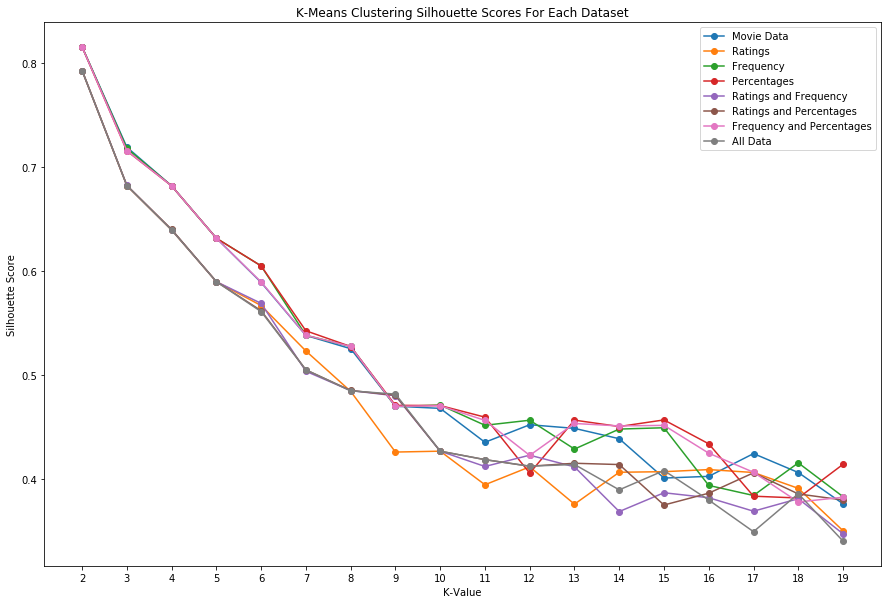

In [14]:
fig, ax = plt.subplots(figsize=(15,10))

# The different lines we're plotting
movieplot = plt.plot(range(2, len(movies_sil_scores) + 2), movies_sil_scores, 'o-', label='Movie Data')
ratingsplot = plt.plot(range(2, len(ratings_sil_scores) + 2), ratings_sil_scores, 'o-', label='Ratings')
talliesplot = plt.plot(range(2, len(tallies_sil_scores) + 2), tallies_sil_scores, 'o-', label='Frequency')
demogrpplot = plt.plot(range(2, len(demogrp_sil_scores) + 2), demogrp_sil_scores, 'o-', label='Percentages')
ratings_tallies_plot = plt.plot(range(2, len(ratings_and_tallies_sil_scores) + 2), ratings_and_tallies_sil_scores, 'o-', label='Ratings and Frequency')
ratings_demogrp_plot = plt.plot(range(2, len(ratings_and_demogrp_sil_scores) + 2), ratings_and_demogrp_sil_scores, 'o-', label='Ratings and Percentages')
tallies_demogrp_plot = plt.plot(range(2, len(tallies_and_demogrp_sil_scores) + 2), tallies_and_demogrp_sil_scores, 'o-', label='Frequency and Percentages')
allplot = plt.plot(range(2, len(all_data_sil_scores) + 2), all_data_sil_scores, 'o-', label='All Data')

# The Stylings for the plot
plt.xticks(np.arange(2, len(movies_sil_scores) + 2), range(2, len(movies_sil_scores) + 2))
plt.title('K-Means Clustering Silhouette Scores For Each Dataset')
ax.legend()
ax.set_xlabel('K-Value')
ax.set_ylabel('Silhouette Score')

# Now plot it!
plt.plot()

#### Choosing the 'best' one
It appears that the dataset with the frequency and percentages data had consistently been the highest Silhouette score before the apparent elbows around K=7 through K=11.  This will be the dataset we'll use!

## Now that we have our Optimum Dataset
Let's use the Elbow Technique to determine the best K

[]

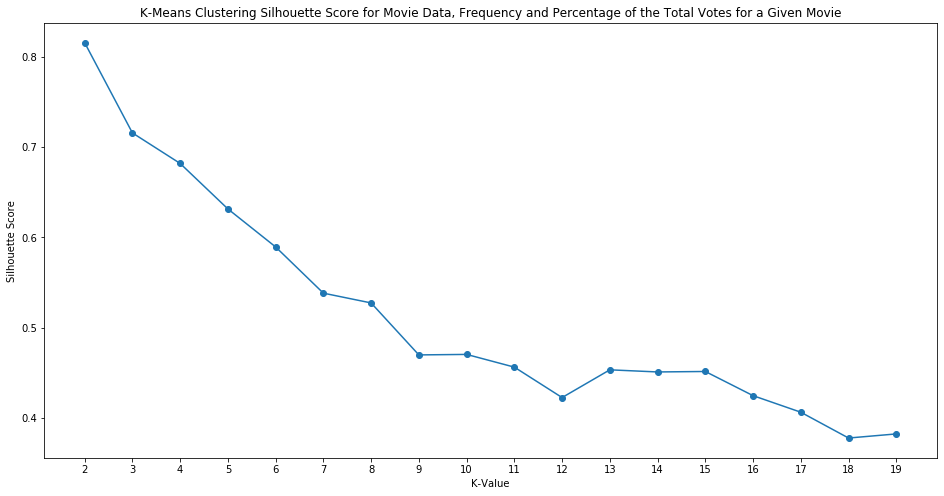

In [15]:
fig, ax = plt.subplots(figsize=(16,8))
mainplot = plt.plot(range(2, len(tallies_and_demogrp_sil_scores) + 2), tallies_and_demogrp_sil_scores, 'o-')
plt.xticks(np.arange(2, len(tallies_and_demogrp_sil_scores) + 2), range(2, len(tallies_and_demogrp_sil_scores) + 2))
plt.title('K-Means Clustering Silhouette Score for Movie Data, Frequency and Percentage of the Total Votes for a Given Movie')
ax.set_xlabel('K-Value')
ax.set_ylabel('Silhouette Score')
plt.plot()

Based on the figure above, it appears that the graph has a potential elbow at K=7 and at K=9.  While the one at K=7 has a higher Silhouette score than the one at K=9, the one at K=9 is the most well-defined cutoff.  We'll use K=9 for this one.

### t-SNE Setup
The t-SNE process, or t-distirbuted schochastic neighbor embedding, is a way to compact our movie data into a 2D map of probabilities for how likely one point is to be another points' neighbor.

In [16]:
tsne = TSNE(verbose=1, perplexity=50, method='exact', n_jobs=-1)

### Chosen K-means Clustering

In [17]:
data = create_np_data(tallies_and_demogrp)

# Create the Training Data and Testing Data
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# t-SNE Call
tsne = TSNE(verbose=1, perplexity=50, method='exact', n_jobs=-1)
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5052
[t-SNE] Computed conditional probabilities for sample 2000 / 5052
[t-SNE] Computed conditional probabilities for sample 3000 / 5052
[t-SNE] Computed conditional probabilities for sample 4000 / 5052
[t-SNE] Computed conditional probabilities for sample 5000 / 5052
[t-SNE] Computed conditional probabilities for sample 5052 / 5052
[t-SNE] Mean sigma: 178783.281187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.800938
[t-SNE] KL divergence after 1000 iterations: 0.781177


In [18]:
# Setting up the K-means model
k = 9

kmeans = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
y_pred = kmeans.fit(X_embedded)
y_train = y_pred
y_test = kmeans.predict(X_embedded)

Initialization complete
Iteration 0, inertia 1527792.0
Iteration 1, inertia 1234325.25
Iteration 2, inertia 1159534.5
Iteration 3, inertia 1137998.875
Iteration 4, inertia 1133782.25
Iteration 5, inertia 1131721.875
Iteration 6, inertia 1131213.125
Iteration 7, inertia 1131043.875
Converged at iteration 7: center shift 0.12234357744455338 within tolerance 0.14286746826171876.
Initialization complete
Iteration 0, inertia 1361671.25
Iteration 1, inertia 1121926.125
Iteration 2, inertia 1087125.625
Iteration 3, inertia 1076626.75
Iteration 4, inertia 1067838.25
Iteration 5, inertia 1061708.875
Iteration 6, inertia 1058340.375
Iteration 7, inertia 1055834.5
Iteration 8, inertia 1054456.375
Iteration 9, inertia 1053572.125
Iteration 10, inertia 1052766.625
Iteration 11, inertia 1052051.0
Iteration 12, inertia 1051692.875
Iteration 13, inertia 1051372.875
Iteration 14, inertia 1050890.125
Iteration 15, inertia 1050398.25
Iteration 16, inertia 1049826.5
Iteration 17, inertia 1049354.0
Iterati

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 0, inertia 1549615.125
Iteration 1, inertia 1124277.125
Iteration 2, inertia 1077582.625
Iteration 3, inertia 1061503.875
Iteration 4, inertia 1054823.25
Iteration 5, inertia 1050638.0
Iteration 6, inertia 1048774.25
Iteration 7, inertia 1048496.6875
Converged at iteration 7: center shift 0.13290543854236603 within tolerance 0.14286746826171876.
Initialization complete
Iteration 0, inertia 1479480.75
Iteration 1, inertia 1198193.75
Iteration 2, inertia 1141097.25
Iteration 3, inertia 1087888.375
Iteration 4, inertia 1059233.125
Iteration 5, inertia 1050204.375
Iteration 6, inertia 1048442.25
Iteration 7, inertia 1048001.8125
Iteration 8, inertia 1047828.5
Converged at iteration 8: center shift 0.05295836925506592 within tolerance 0.14286746826171876.
Initialization complete
Iteration 0, inertia 1669885.25
Iteration 1, inertia 1172201.875
Iteration 2, inertia 1089273.875
Iteration 3, inertia 1063090.75
Iteration 4, inertia 1056700.625
Iteration 5, inertia 1054657.25
Iteration

In [19]:
print(f"Silhouette Score: {metrics.silhouette_score(X_embedded, y_pred.labels_, metric='euclidean')}")

Silhouette Score: 0.4309080243110657


# Interactive Clustering Model

In [20]:
output_notebook()
y_labels = y_test

# data sources
source = ColumnDataSource(data=dict(
    x           = X_embedded[:,0], 
    y           = X_embedded[:,1],
    x_backup    = X_embedded[:,0],
    y_backup    = X_embedded[:,1],
    desc        = y_labels, 
    titles      = movies_df['title'],
    writers     = movies_df['writer'],
    actors      = movies_df['actors'],
    description = movies_df['description'],
    length      = movies_df['duration'],
    metascore   = movies_df['metascore'],
    avg_score   = movies_df['avg_vote'],
    labels      = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Writer(s)", "@writers"),
    ("Actor(s)", "@actors"),
    ("Director(s)", "@actors{safe}"),
    ("Description", "@description"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE IMDB Movie Summaries, Clustered(K-Means), Tf-idf with Plain Text", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

#header
header = Div(text="""<h1>IMDB Movie Clusters</h1>""")

# show
show(column(header, widgetbox(), p))

Loading BokehJS ...